In [1]:
#%pip install --user timm

In [2]:
#!pip show timm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append('/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts')
print(sys.path)
import DataCore_Akhil as DC
import AkhilFunctions as AF
import auxiliary_functions as af
import plotting

import torch
print(f"{torch.cuda.is_available()} good")
print(f"{torch.cuda.device_count()} devices")
print(torch.cuda.mem_get_info())

from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset, Subset, ConcatDataset
from astropy.io import fits
import torchvision
import timm
import torchvision.transforms.v2 as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.cuda.amp import autocast, GradScaler
from collections import Counter

['/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Notebooks', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python311.zip', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/lib-dynload', '', '/Users/users/mahesh/.local/lib/python3.11/site-packages', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages', '/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts']
True good
1 devices
(22494773248, 25339101184)


In [5]:
#torch.cuda.memory_summary()

In [6]:
datadir = "/net/virgo01/data/users/mahesh/DeepLearning/data/"
labeldir = "/net/virgo01/data/users/spirov/Deep/catalog_tng100_jwst_all_50sns.fits"
labels = fits.open(labeldir)[1]

In [7]:
with fits.open(datadir + "mock_v4/F150W/L75n1820TNG/snapnum_053/xy/JWST_50kpc_F150W_TNG100_sn053_xy_broadband_1.fits") as hdu1:
    print(hdu1[0].shape)

(1, 256, 256)


In [8]:
mask1 = labels.data['is_major_merger'] == 0
mask2 = labels.data['is_pre_merger'] == 0
mask3 = labels.data['is_ongoing_merger'] == 1
mask4 = labels.data['is_post_merger'] == 0
#print(len(labels.data[mask1 & mask2 & mask3 & mask4]))
#print(len(labels.data[mask1]))

major: 2383

pre only: 1236\
ongoing only: 511\
post only: 605\
pre and post: 31\
sum: 2383
31

# zoobot

In [9]:
swin_multi = timm.create_model('hf_hub:mwalmsley/zoobot-encoder-efficientnet_b0', pretrained=True, num_classes=3)

# Freeze all parameters first
for param in swin_multi.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in swin_multi.classifier.parameters():
    param.requires_grad = True
    #print('yay')

config = timm.data.resolve_model_data_config(swin_multi)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_multi = swin_multi.to(device)

In [10]:
swin_multi.classifier

Linear(in_features=1280, out_features=3, bias=True)

In [11]:
config

{'input_size': [3, 224, 224],
 'interpolation': 'bicubic',
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225],
 'crop_pct': 0.875,
 'crop_mode': 'center'}

In [12]:
# Validation/test transform without augmentations
val_test_transform = transforms.Compose([
    transforms.Lambda(lambda img: af.aggressive_arcsinh_scaling(img)),
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=config["mean"], std=config["std"])
])

/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [13]:
nonmerger_transform = transforms.Compose([
    transforms.Lambda(lambda img: af.aggressive_arcsinh_scaling(img)),
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),  # Resize to model's expected input size
    #transforms.RandomResizedCrop(256, scale=(0.9, 1.0)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(15), #degrees=(0, 360)
    transforms.Grayscale(num_output_channels=3),   # Convert grayscale to 3 channels
    transforms.ToTensor(),
    #add_noise,
    transforms.Normalize(mean=config["mean"], std=config["std"])  # Use model-specific normalization
])

In [14]:
merger_transform = transforms.Compose([
    transforms.Lambda(lambda img: af.aggressive_arcsinh_scaling(img)),
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),  # Resize to model's expected input size
    #transforms.RandomResizedCrop(256, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(0, 360)), #degrees=(0, 360)
    transforms.Grayscale(num_output_channels=3),   # Convert grayscale to 3 channels
    transforms.ToTensor(),
    #add_noise,
    transforms.Normalize(mean=config["mean"], std=config["std"])  # Use model-specific normalization
])

In [15]:
swin_multidata = DC.nonbinary_ClassificationDataset_v2(datadir, labels, nonmerger_transform = nonmerger_transform, merger_transform = merger_transform)

In [16]:
strat_labels = np.empty(len(labels.data), dtype = int)
mask_pre = labels.data['is_pre_merger'] == 1
mask_post = labels.data['is_post_merger'] == 1
mask_ongoing = labels.data['is_ongoing_merger'] == 1
mask_non = labels.data['is_major_merger'] == 0

strat_labels[mask_pre] = 1
strat_labels[mask_post | mask_ongoing] = 2
strat_labels[mask_non] = 0
strat_labels[mask_pre & mask_post] = 3

In [17]:
# Assume strat_labels is a NumPy array with your labels.
all_indices = np.arange(len(swin_multidata))
print(len(all_indices))
print(len(strat_labels))

# Remove labels with 3 (i.e. samples to be ignored)
noneMask = (strat_labels != 3)
filtered_all_indices = all_indices[noneMask]
filtered_strat_labels = strat_labels[noneMask]

print(len(filtered_all_indices))
print(len(filtered_strat_labels))

# Create relative indices for the filtered dataset
relative_indices = np.arange(len(filtered_strat_labels))

# First split: 80% train, 20% temporary
train_idx_rel, temp_idx_rel = train_test_split(
    relative_indices, test_size=0.20, stratify=filtered_strat_labels, random_state=42
)

# Map the relative indices back to the original indices
train_idx = filtered_all_indices[train_idx_rel]
temp_idx = filtered_all_indices[temp_idx_rel]

train_strat_labels = filtered_strat_labels[train_idx_rel]
first_train_strat_labels = train_strat_labels

desample_factor = 0.9
augmentation_factor = 3

# For the temporary set, get its stratification labels (relative indices)
temp_strat_labels = filtered_strat_labels[temp_idx_rel]

# Second split: split temp indices equally into validation and test sets
val_idx_rel, test_idx_rel = train_test_split(
    temp_idx_rel, test_size=0.5, stratify=filtered_strat_labels[temp_idx_rel], random_state=42
)

# Map these relative indices back to the original indices
val_idx = filtered_all_indices[val_idx_rel]
test_idx = filtered_all_indices[test_idx_rel]

# Create the Subset datasets (using your custom SubsetWithTransform for validation and test)
swin_multi_train_dataset = Subset(swin_multidata, train_idx)
swin_multi_val_dataset = AF.SubsetWithTransform_v2(swin_multidata, val_idx, transform=val_test_transform)
swin_multi_test_dataset = AF.SubsetWithTransform_v2(swin_multidata, test_idx, transform=val_test_transform)

58436
58436
58405
58405


In [18]:
#if I want to include the label 3 data in test and validation

# # Step 1: Create full indices and strat_labels (as you already do)
# all_indices = np.arange(len(swin_multidata))
# print("Full dataset size:", len(all_indices))
# print("Strat labels size:", len(strat_labels))

# # Step 2: Split the entire dataset into training (80%) and temporary (20%) using full strat_labels
# train_idx, temp_idx = train_test_split(
#     all_indices, test_size=0.20, stratify=strat_labels, random_state=42
# )

# # Step 3: For the training set, remove the samples with label 3 (pre+post mergers)
# train_idx = train_idx[strat_labels[train_idx] != 3]
# print("Training set size after filtering label 3:", len(train_idx))

# # Step 4: For validation/test, use the temporary indices as is (which still include label 3)
# temp_strat_labels = strat_labels[temp_idx]
# # Now split temp equally into validation and test, with stratification on the full labels (including label 3)
# val_idx, test_idx = train_test_split(
#     temp_idx, test_size=0.5, stratify=temp_strat_labels, random_state=42
# )

# # Create the Subset datasets
# swin_multi_train_dataset = Subset(swin_multidata, train_idx)
# swin_multi_val_dataset = AF.SubsetWithTransform_v2(swin_multidata, val_idx, transform=val_test_transform)
# swin_multi_test_dataset = AF.SubsetWithTransform_v2(swin_multidata, test_idx, transform=val_test_transform)

In [19]:
all_indices = np.arange(len(swin_multi_train_dataset))

# Create a boolean mask for the majority class (0,0)
mask_majority = train_strat_labels == 0
majority_indices = all_indices[mask_majority]

# Downsample the (0,0) samples to 80% of their original count
new_majority_indices = np.random.choice(majority_indices, 
                                          size=int(desample_factor * len(majority_indices)), 
                                          replace=False)

# For the minority classes, keep all indices
minority_indices = all_indices[~mask_majority]

# Combine the indices and optionally shuffle them
new_indices = np.concatenate([new_majority_indices, minority_indices])
np.random.shuffle(new_indices)

train_strat_labels = train_strat_labels[new_indices]

# Create a new Subset dataset with the new indices
swin_multi_train_dataset = Subset(swin_multi_train_dataset, new_indices)

In [20]:
len(swin_multi_train_dataset)

42239

In [21]:
# Create a boolean mask for minority samples (i.e., not [0,0])
minority_mask = ~(train_strat_labels == 0)
minority_indices = np.where(minority_mask)[0].tolist()

# Create a subset for the minority samples
minority_dataset = Subset(swin_multi_train_dataset, minority_indices)

# Concatenate the original dataset with the minority subset (doubling the minority samples)
for i in range(augmentation_factor-1):
    swin_multi_train_dataset = ConcatDataset([swin_multi_train_dataset, minority_dataset])

In [22]:
len(swin_multi_train_dataset)

46003

In [23]:
# train_size = int(0.81 * len(swin_multidata))
# val_size = int(0.09*len(swin_multidata))
# test_size = len(swin_multidata) - train_size - val_size
# swin_multi_train_dataset, swin_multi_val_dataset, swin_multi_test_dataset = random_split(swin_multidata, [train_size, val_size, test_size])

batch_size = 128
num_workers = 4
prefetch_factor = 2
persistent_workers = True
swin_multi_train_loader = DataLoader(swin_multi_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                          pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
swin_multi_val_loader = DataLoader(swin_multi_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                        pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
swin_multi_test_loader = DataLoader(swin_multi_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                         pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)

# x,y = next(iter(swin_multi_train_loader))
# print("x batch shape:", x.shape)  # Should be [batch_size, 3, 224, 224]
# print("y batch shape:", y.shape)  # Should be [batch_size, 3]

In [24]:
weight = torch.tensor([0.5,10,10], dtype=torch.float32, device = device)
N = len(swin_multi_train_dataset)
n1 = np.sum((train_strat_labels == 1))*1.5#*augmentation_factor
n2 = np.sum((train_strat_labels == 2))*1.53#*augmentation_factor
n0 = np.sum((train_strat_labels == 0))*0.85#*desample_factor
C=3
w0 = N / (C * n0)
w1 = N / (C * n1)
w2 = N / (C * n2)

# weight = torch.tensor([0.5,10,10], dtype=torch.float32, device = device)
# N = len(swin_multi_train_dataset)
# n1 = np.sum((train_strat_labels == 1))*1.4#*augmentation_factor
# n2 = np.sum((train_strat_labels == 2))*1.2#*augmentation_factor
# n0 = np.sum((train_strat_labels == 0))*0.9#*desample_factor
# C=3
# w0 = N / (C * n0)
# w1 = N / (C * n1)
# w2 = N / (C * n2)

weight = torch.tensor([0.7,w1,w2], dtype=torch.float32, device = device)
criterion = nn.CrossEntropyLoss(weight=weight)
#optimizer = optim.Adam(swin_multi.parameters(), lr=0.005, weight_decay=1e-4)
optimizer = optim.AdamW(swin_multi.parameters(),
                        lr=8e-5,            # learning rate, adjust as needed
                        betas=(0.9, 0.999), # momentum parameters
                        eps=1e-8,           # term added to improve numerical stability
                        weight_decay=0.01)  # decoupled weight decay

In [25]:
print(n0,n1,n2)
print(w0,w1,w2)
print(weight)

34303.45 1483.5 1366.29
0.4470201490909321 10.336591394225367 11.223337163657302
tensor([ 0.7000, 10.3366, 11.2233], device='cuda:0')


In [26]:
epochs = 200
num_training_steps = epochs*len(swin_multi_train_loader)  # total steps (e.g., epochs * batches_per_epoch)
num_warmup_steps = int(0.05*num_training_steps)
#scheduler = AF.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

Epoch 1/200 - Learning Rate: 0.000080


Train Loss: 1.137531 | Val Loss: 1.135670 | Val Acc: 0.295 | Balanced Acc: 0.389
Epoch 1/200 took 265.84 seconds
Epoch 2/200 - Learning Rate: 0.000080


Train Loss: 1.067060 | Val Loss: 1.073092 | Val Acc: 0.371 | Balanced Acc: 0.452
Epoch 2/200 took 262.45 seconds
Epoch 3/200 - Learning Rate: 0.000080


Train Loss: 1.027777 | Val Loss: 1.032020 | Val Acc: 0.484 | Balanced Acc: 0.496
Epoch 3/200 took 261.03 seconds


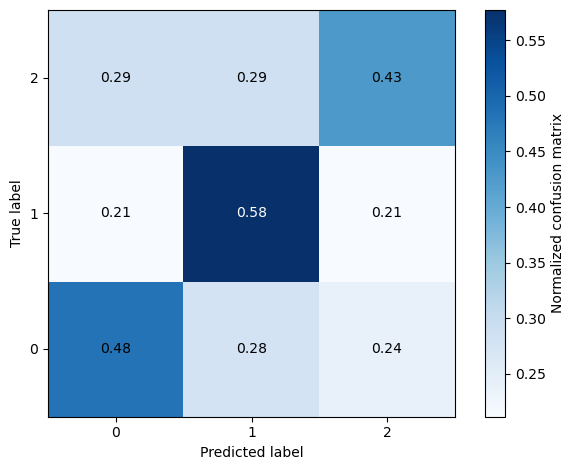

Epoch 4/200 - Learning Rate: 0.000080


Train Loss: 1.005083 | Val Loss: 1.011823 | Val Acc: 0.516 | Balanced Acc: 0.521
Epoch 4/200 took 260.37 seconds


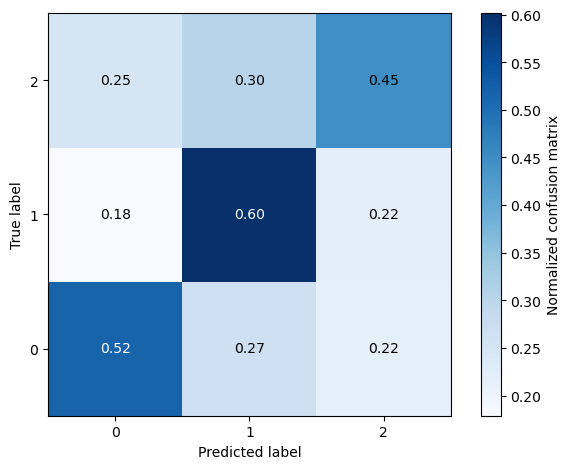

Epoch 5/200 - Learning Rate: 0.000080


Train Loss: 0.986645 | Val Loss: 0.991877 | Val Acc: 0.555 | Balanced Acc: 0.544
Epoch 5/200 took 262.34 seconds


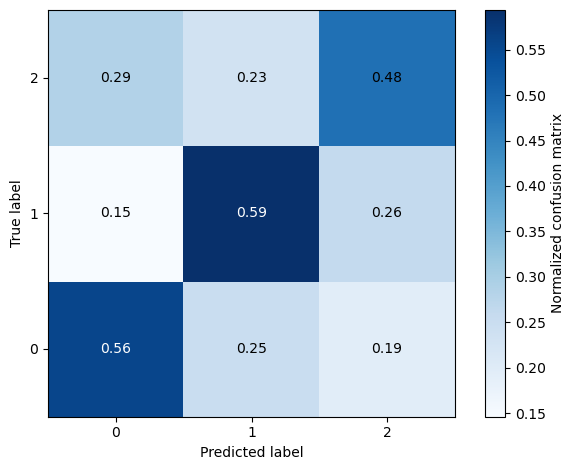

Epoch 6/200 - Learning Rate: 0.000080


Train Loss: 0.971357 | Val Loss: 0.980186 | Val Acc: 0.559 | Balanced Acc: 0.553
Epoch 6/200 took 261.48 seconds


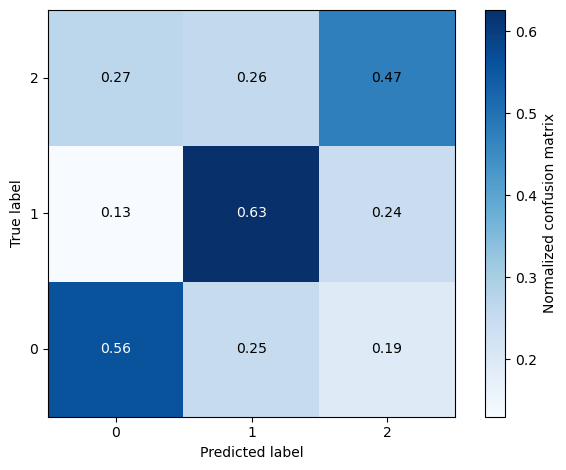

Epoch 7/200 - Learning Rate: 0.000080


Train Loss: 0.959016 | Val Loss: 0.954681 | Val Acc: 0.590 | Balanced Acc: 0.539
Epoch 7/200 took 261.98 seconds


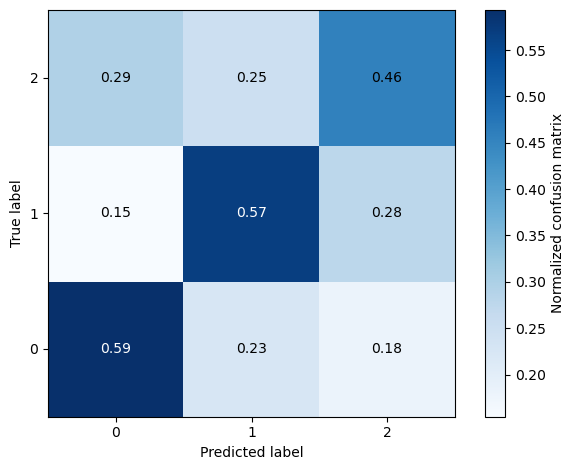

Epoch 8/200 - Learning Rate: 0.000080


Train Loss: 0.950462 | Val Loss: 0.949247 | Val Acc: 0.601 | Balanced Acc: 0.540
Epoch 8/200 took 261.41 seconds


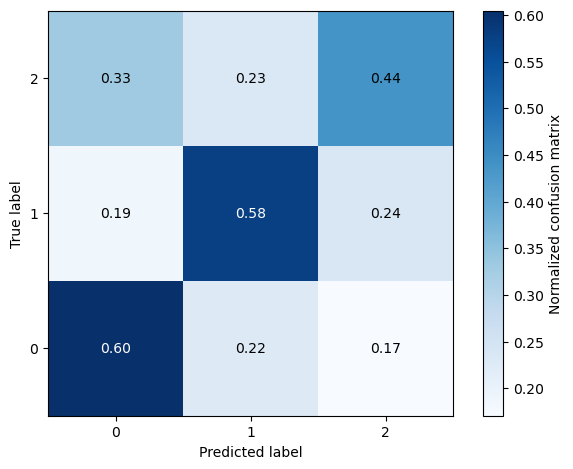

Epoch 9/200 - Learning Rate: 0.000080


Train Loss: 0.939127 | Val Loss: 0.926693 | Val Acc: 0.623 | Balanced Acc: 0.559
Epoch 9/200 took 260.97 seconds


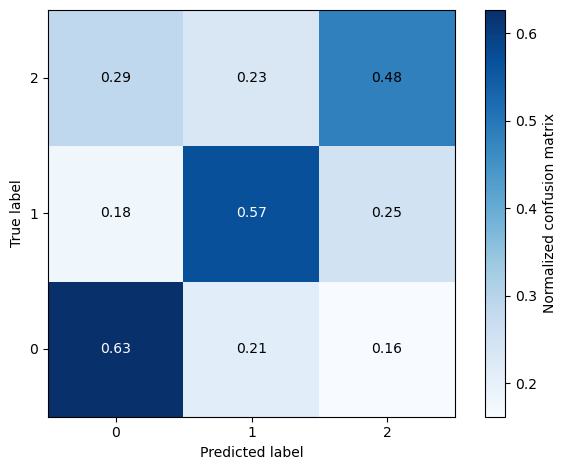

Epoch 10/200 - Learning Rate: 0.000080


Train Loss: 0.931916 | Val Loss: 0.922781 | Val Acc: 0.623 | Balanced Acc: 0.573
Epoch 10/200 took 260.65 seconds


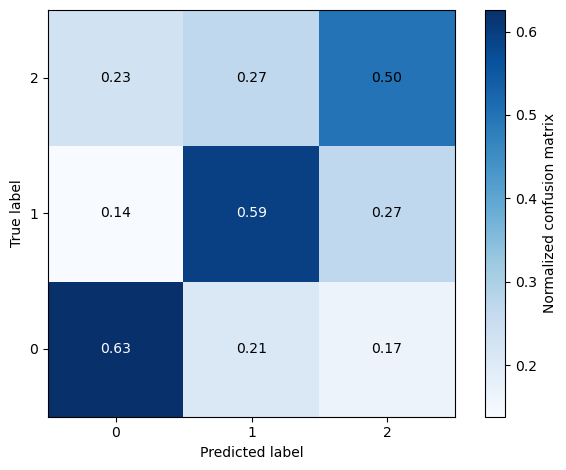

Epoch 11/200 - Learning Rate: 0.000080


Train Loss: 0.922435 | Val Loss: 0.907795 | Val Acc: 0.645 | Balanced Acc: 0.570
Epoch 11/200 took 260.87 seconds


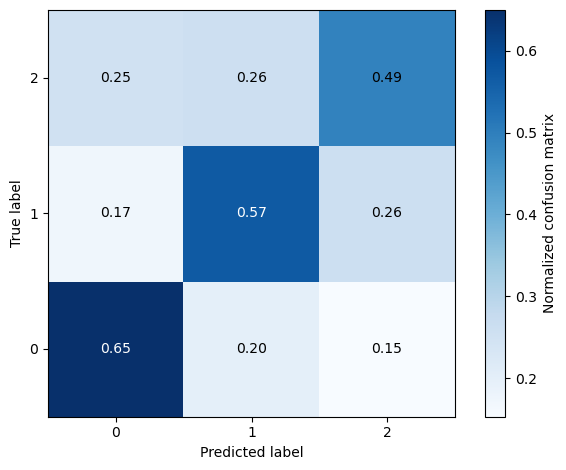

Epoch 12/200 - Learning Rate: 0.000080


Train Loss: 0.916783 | Val Loss: 0.907197 | Val Acc: 0.640 | Balanced Acc: 0.580
Epoch 12/200 took 260.44 seconds


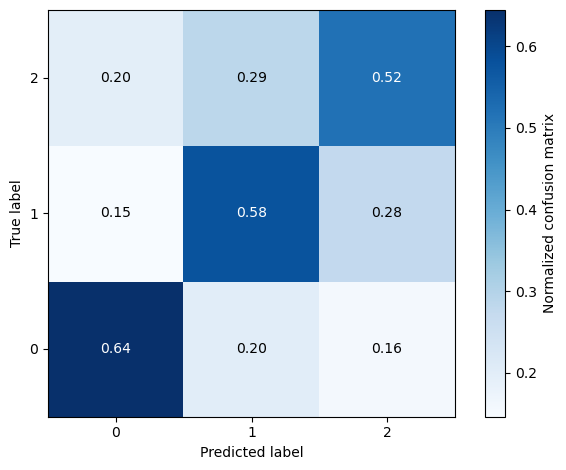

Epoch 13/200 - Learning Rate: 0.000080


Train Loss: 0.908966 | Val Loss: 0.893537 | Val Acc: 0.663 | Balanced Acc: 0.596
Epoch 13/200 took 260.66 seconds


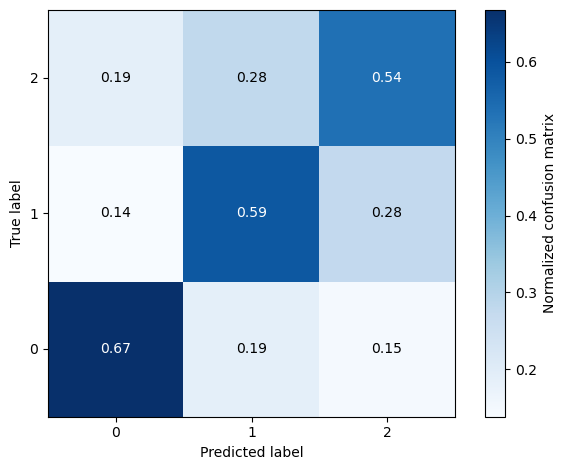

Epoch 14/200 - Learning Rate: 0.000080


Train Loss: 0.902200 | Val Loss: 0.879436 | Val Acc: 0.677 | Balanced Acc: 0.585
Epoch 14/200 took 260.43 seconds


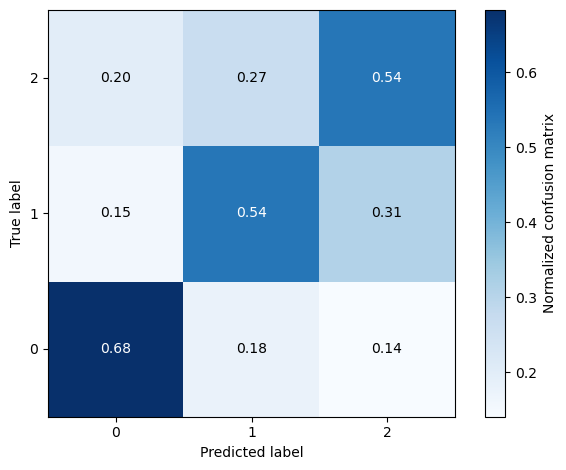

Epoch 15/200 - Learning Rate: 0.000080


Train Loss: 0.894580 | Val Loss: 0.875201 | Val Acc: 0.679 | Balanced Acc: 0.596
Epoch 15/200 took 261.40 seconds


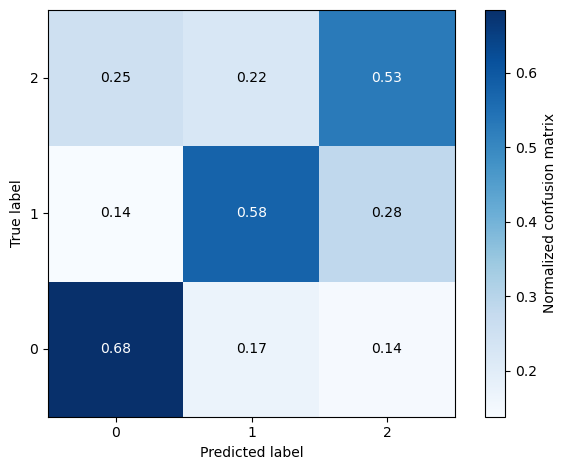

Epoch 16/200 - Learning Rate: 0.000080


Train Loss: 0.890809 | Val Loss: 0.870460 | Val Acc: 0.682 | Balanced Acc: 0.605
Epoch 16/200 took 261.26 seconds


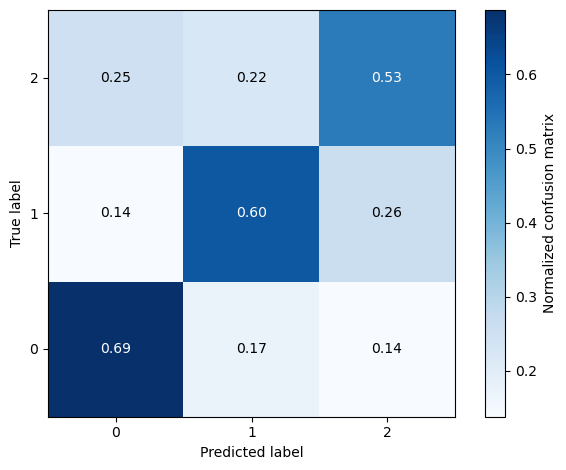

Epoch 17/200 - Learning Rate: 0.000080


Train Loss: 0.883132 | Val Loss: 0.856925 | Val Acc: 0.703 | Balanced Acc: 0.608
Epoch 17/200 took 262.12 seconds


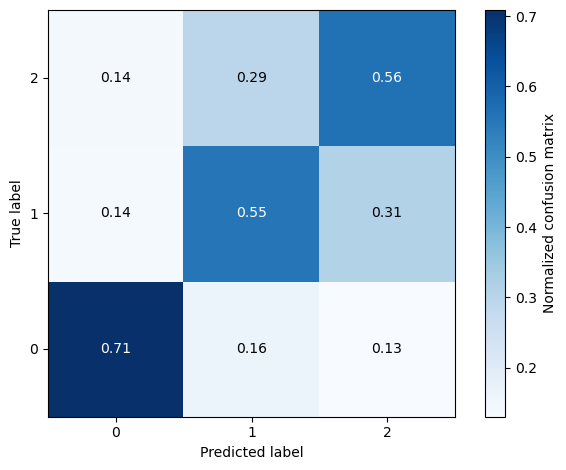

Epoch 18/200 - Learning Rate: 0.000080


Train Loss: 0.877265 | Val Loss: 0.856334 | Val Acc: 0.706 | Balanced Acc: 0.606
Epoch 18/200 took 262.05 seconds


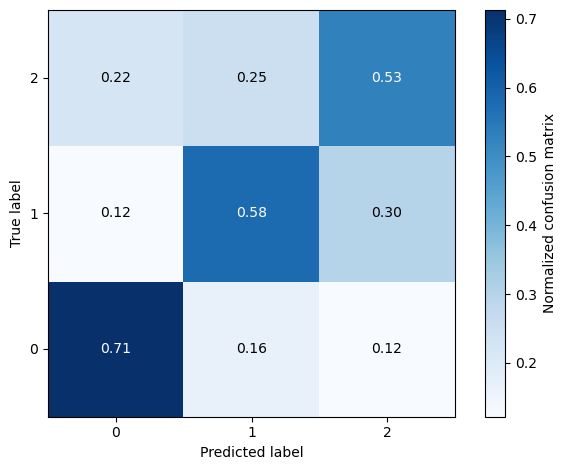

Epoch 19/200 - Learning Rate: 0.000080


Train Loss: 0.875043 | Val Loss: 0.843040 | Val Acc: 0.717 | Balanced Acc: 0.615
Epoch 19/200 took 261.76 seconds


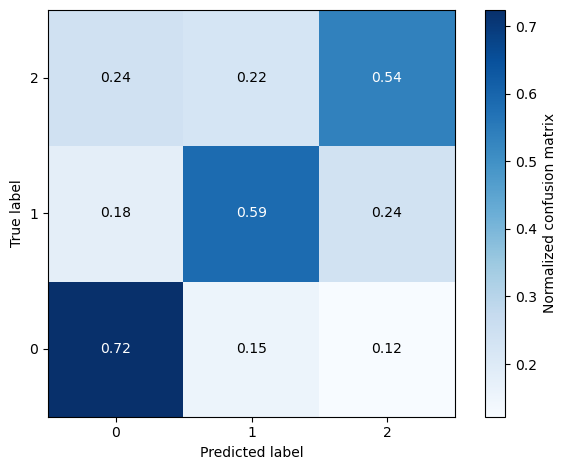

Epoch 20/200 - Learning Rate: 0.000080


Train Loss: 0.870272 | Val Loss: 0.842398 | Val Acc: 0.707 | Balanced Acc: 0.620
Epoch 20/200 took 262.08 seconds


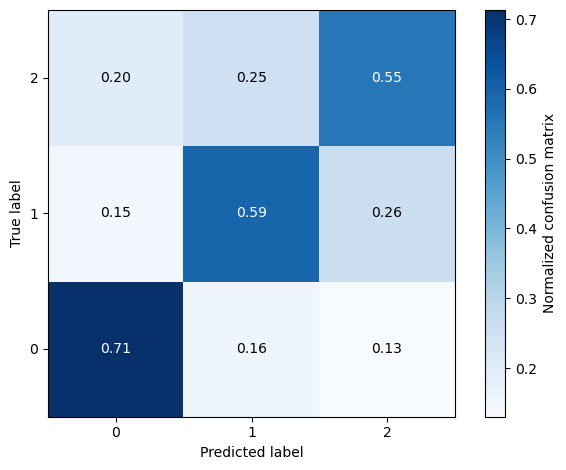

Epoch 21/200 - Learning Rate: 0.000080


Train Loss: 0.862496 | Val Loss: 0.834972 | Val Acc: 0.717 | Balanced Acc: 0.630
Epoch 21/200 took 263.07 seconds


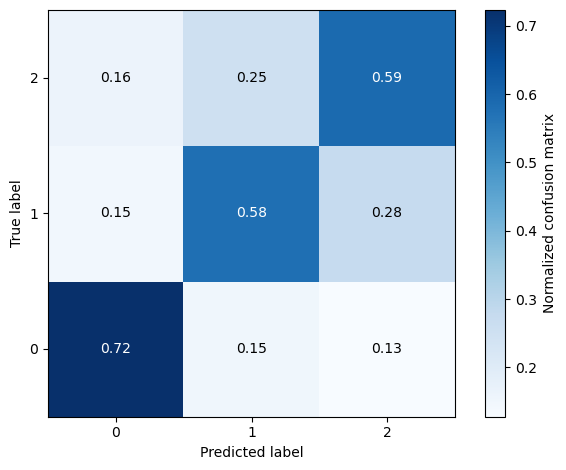

Epoch 22/200 - Learning Rate: 0.000080


Train Loss: 0.861254 | Val Loss: 0.842170 | Val Acc: 0.716 | Balanced Acc: 0.621
Epoch 22/200 took 261.95 seconds


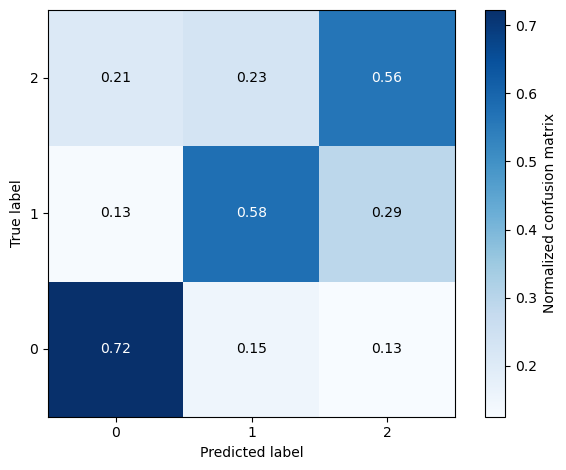

Epoch 23/200 - Learning Rate: 0.000080


Train Loss: 0.855630 | Val Loss: 0.823796 | Val Acc: 0.731 | Balanced Acc: 0.629
Epoch 23/200 took 261.93 seconds


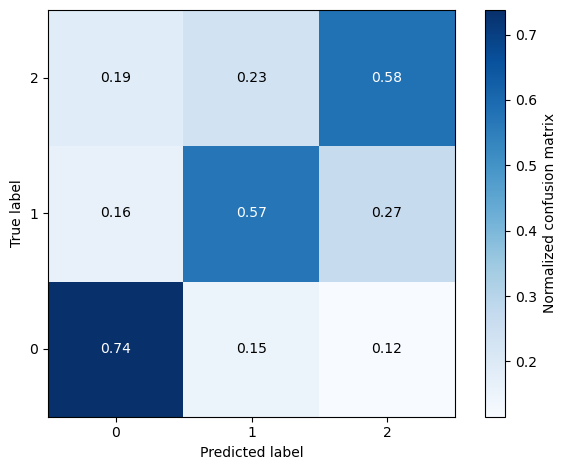

Epoch 24/200 - Learning Rate: 0.000080


Train Loss: 0.848835 | Val Loss: 0.833278 | Val Acc: 0.720 | Balanced Acc: 0.628
Epoch 24/200 took 261.17 seconds


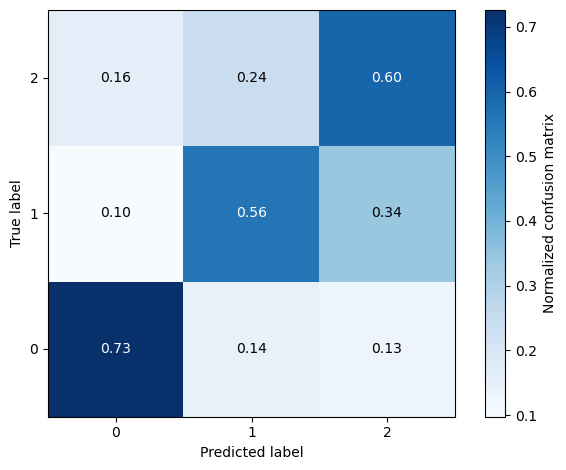

Epoch 25/200 - Learning Rate: 0.000080


Train Loss: 0.844906 | Val Loss: 0.809376 | Val Acc: 0.740 | Balanced Acc: 0.632
Epoch 25/200 took 261.79 seconds


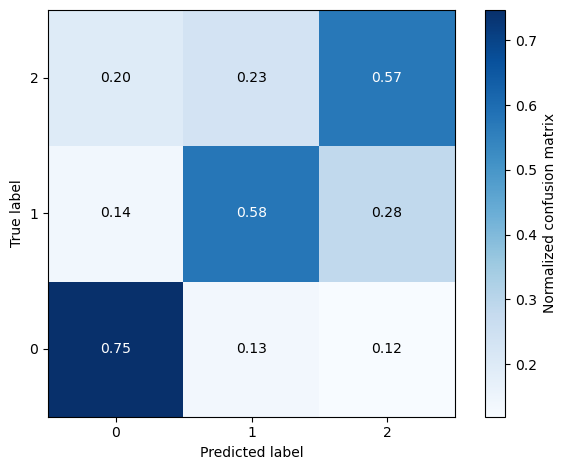

Epoch 26/200 - Learning Rate: 0.000080


Train Loss: 0.842612 | Val Loss: 0.795021 | Val Acc: 0.749 | Balanced Acc: 0.649
Epoch 26/200 took 261.57 seconds


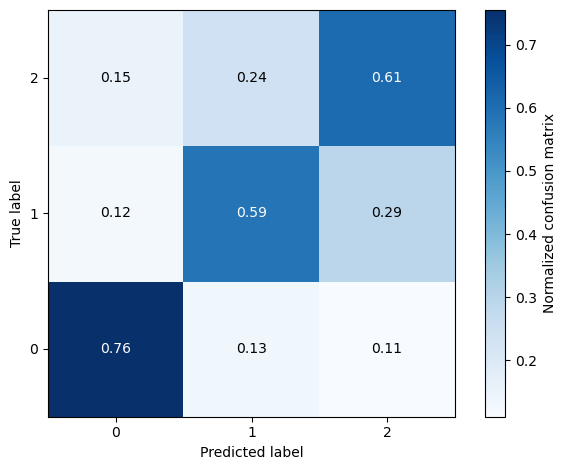

Epoch 27/200 - Learning Rate: 0.000080


Train Loss: 0.840285 | Val Loss: 0.796795 | Val Acc: 0.751 | Balanced Acc: 0.651
Epoch 27/200 took 261.09 seconds


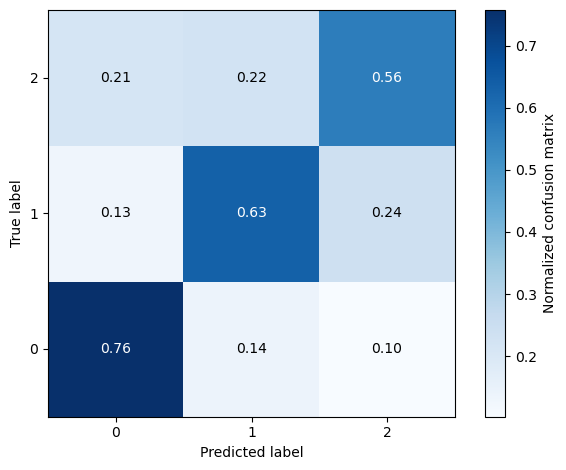

Epoch 28/200 - Learning Rate: 0.000080


Train Loss: 0.832835 | Val Loss: 0.799895 | Val Acc: 0.749 | Balanced Acc: 0.641
Epoch 28/200 took 262.82 seconds


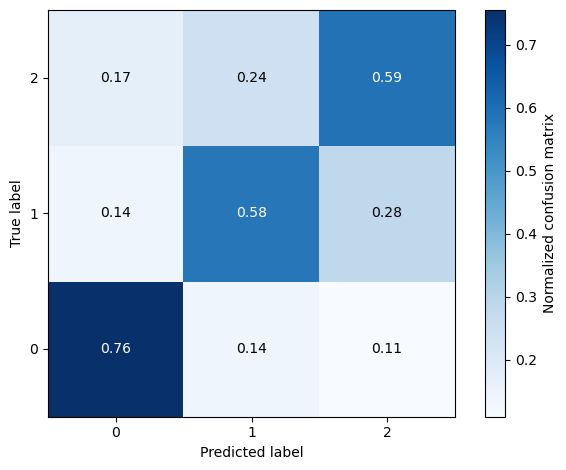

Epoch 29/200 - Learning Rate: 0.000080


Train Loss: 0.833489 | Val Loss: 0.791996 | Val Acc: 0.761 | Balanced Acc: 0.614
Epoch 29/200 took 262.12 seconds


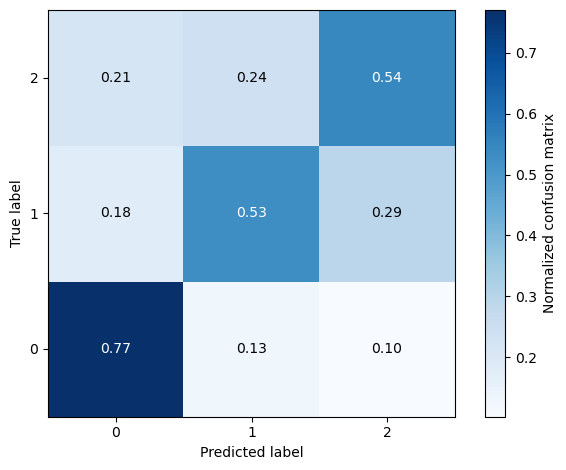

Epoch 30/200 - Learning Rate: 0.000080


Train Loss: 0.829231 | Val Loss: 0.782078 | Val Acc: 0.773 | Balanced Acc: 0.643
Epoch 30/200 took 262.98 seconds


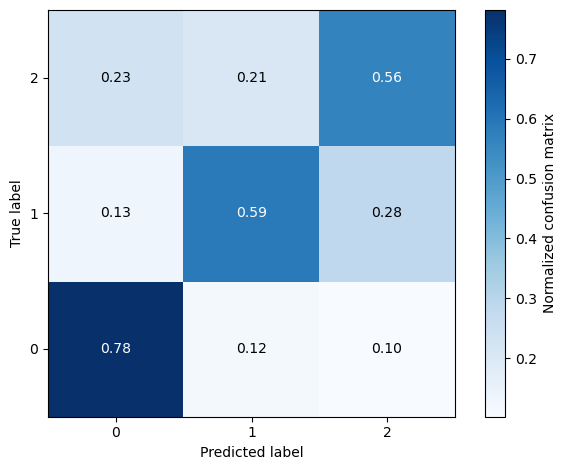

Epoch 31/200 - Learning Rate: 0.000080


Train Loss: 0.823993 | Val Loss: 0.770365 | Val Acc: 0.771 | Balanced Acc: 0.687
Epoch 31/200 took 262.38 seconds


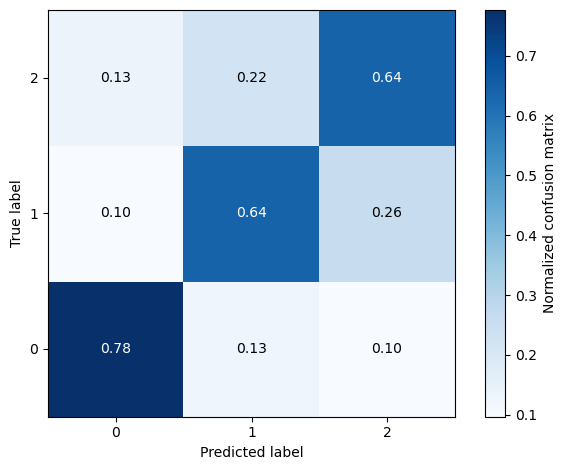

Epoch 32/200 - Learning Rate: 0.000080


Train Loss: 0.822029 | Val Loss: 0.775432 | Val Acc: 0.766 | Balanced Acc: 0.652
Epoch 32/200 took 262.68 seconds


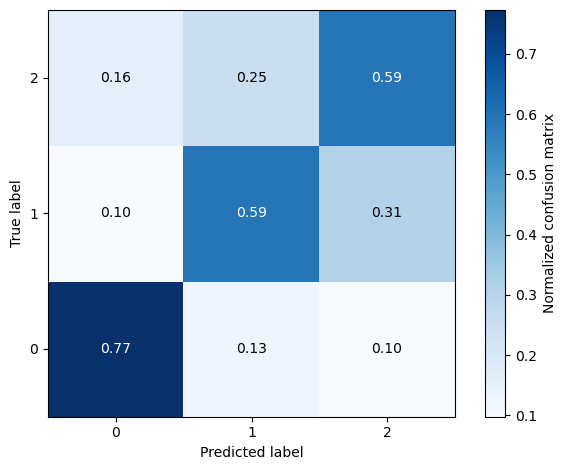

Epoch 33/200 - Learning Rate: 0.000080


Train Loss: 0.818548 | Val Loss: 0.778404 | Val Acc: 0.770 | Balanced Acc: 0.667
Epoch 33/200 took 262.54 seconds


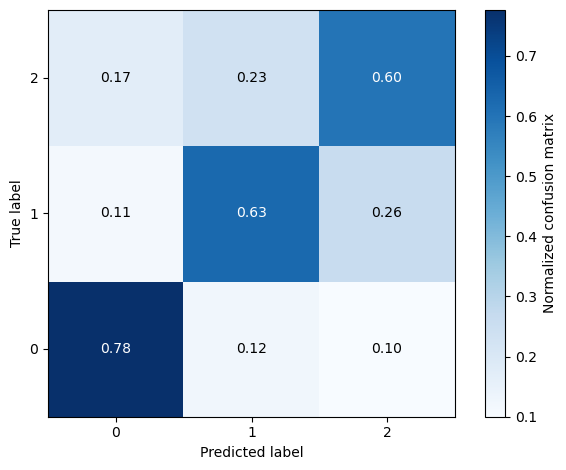

Epoch 34/200 - Learning Rate: 0.000080


Train Loss: 0.817361 | Val Loss: 0.778534 | Val Acc: 0.765 | Balanced Acc: 0.658
Epoch 34/200 took 263.63 seconds


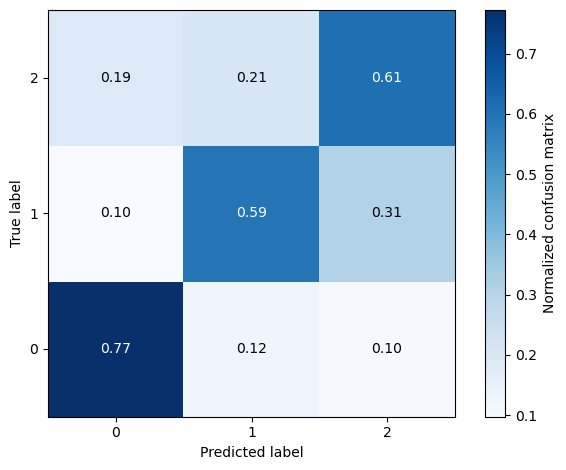

Epoch 35/200 - Learning Rate: 0.000080


Train Loss: 0.813334 | Val Loss: 0.768560 | Val Acc: 0.773 | Balanced Acc: 0.672
Epoch 35/200 took 262.46 seconds


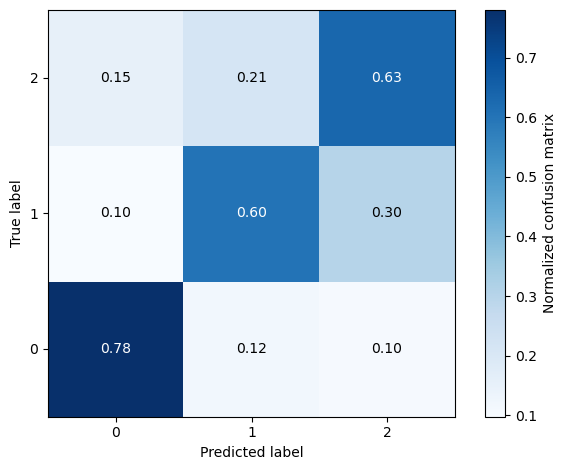

Epoch 36/200 - Learning Rate: 0.000080


Train Loss: 0.809036 | Val Loss: 0.754694 | Val Acc: 0.790 | Balanced Acc: 0.655
Epoch 36/200 took 261.79 seconds


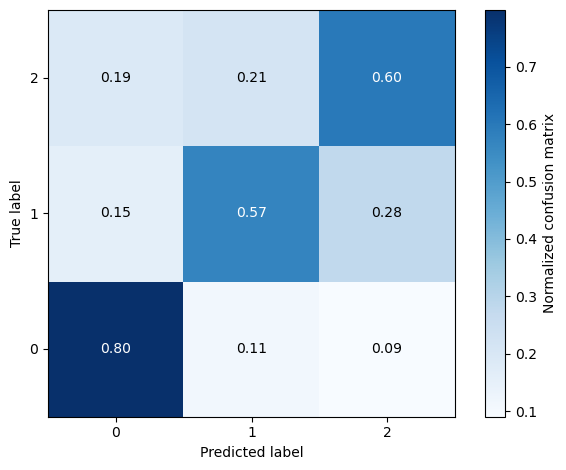

Epoch 37/200 - Learning Rate: 0.000080


Train Loss: 0.808425 | Val Loss: 0.748293 | Val Acc: 0.796 | Balanced Acc: 0.671
Epoch 37/200 took 264.85 seconds


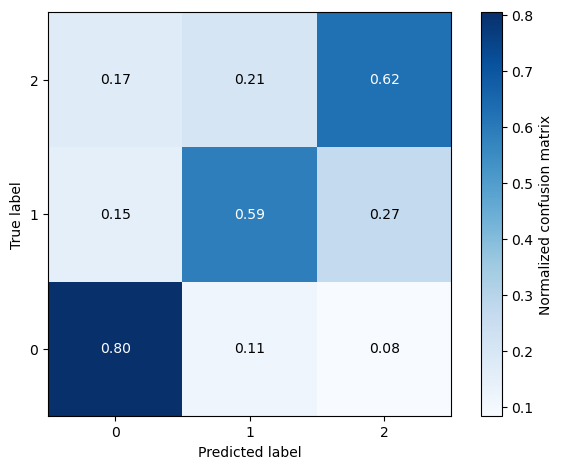

Epoch 38/200 - Learning Rate: 0.000080


Train Loss: 0.802691 | Val Loss: 0.748655 | Val Acc: 0.791 | Balanced Acc: 0.683
Epoch 38/200 took 265.09 seconds


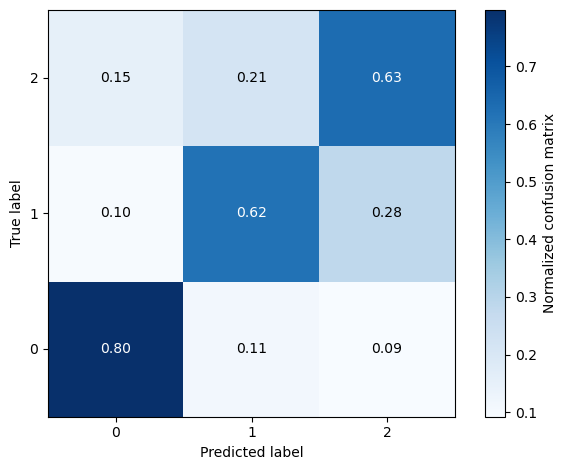

Epoch 39/200 - Learning Rate: 0.000080


Train Loss: 0.801953 | Val Loss: 0.755386 | Val Acc: 0.793 | Balanced Acc: 0.649
Epoch 39/200 took 264.15 seconds


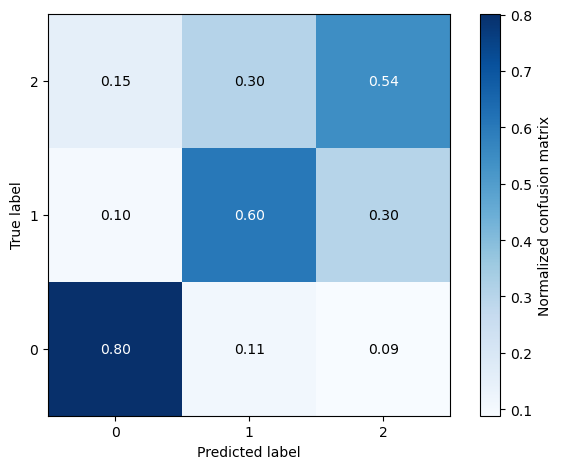

Epoch 40/200 - Learning Rate: 0.000080


Train Loss: 0.803770 | Val Loss: 0.759925 | Val Acc: 0.778 | Balanced Acc: 0.680
Epoch 40/200 took 263.92 seconds


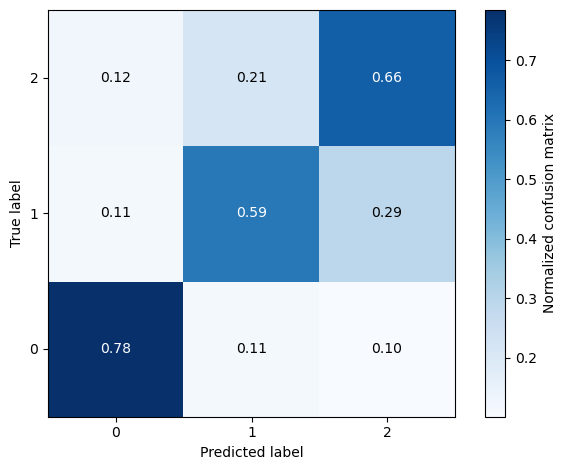

Epoch 41/200 - Learning Rate: 0.000080


Train Loss: 0.796176 | Val Loss: 0.750076 | Val Acc: 0.790 | Balanced Acc: 0.673
Epoch 41/200 took 263.98 seconds


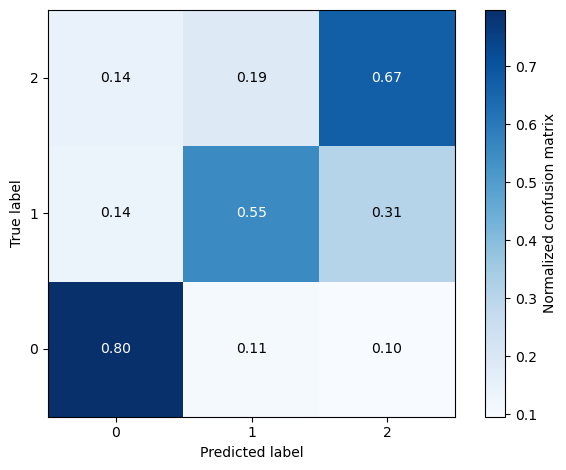

Epoch 42/200 - Learning Rate: 0.000080


Train Loss: 0.794526 | Val Loss: 0.743625 | Val Acc: 0.798 | Balanced Acc: 0.642
Epoch 42/200 took 263.65 seconds


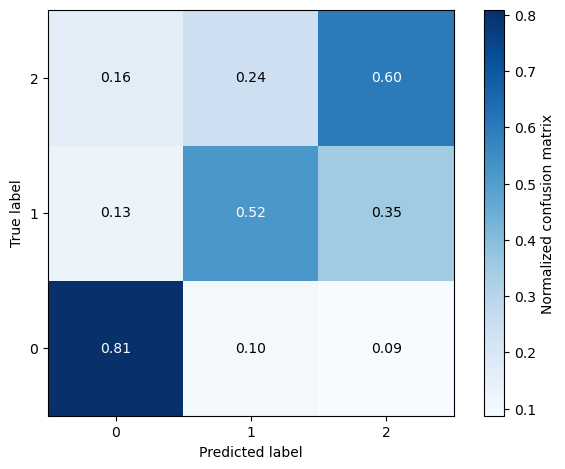

Epoch 43/200 - Learning Rate: 0.000080


Train Loss: 0.787075 | Val Loss: 0.735685 | Val Acc: 0.798 | Balanced Acc: 0.672
Epoch 43/200 took 263.33 seconds


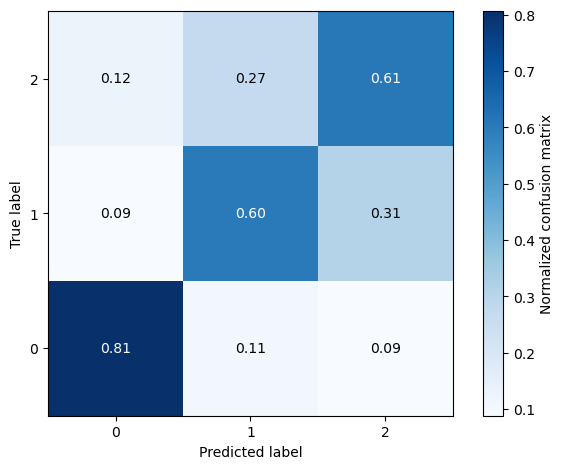

Epoch 44/200 - Learning Rate: 0.000080


Train Loss: 0.789440 | Val Loss: 0.732339 | Val Acc: 0.797 | Balanced Acc: 0.658
Epoch 44/200 took 263.69 seconds


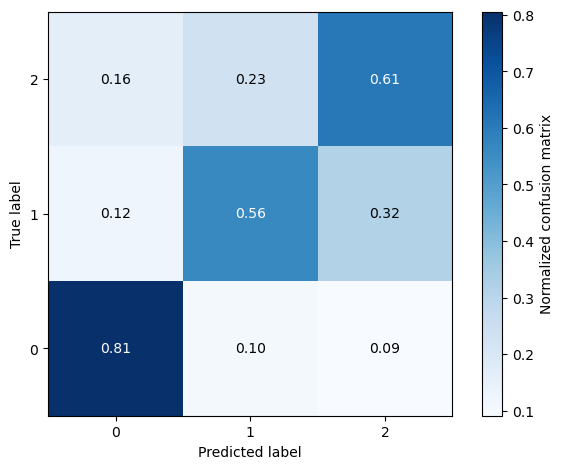

Epoch 45/200 - Learning Rate: 0.000080


Train Loss: 0.786494 | Val Loss: 0.720570 | Val Acc: 0.808 | Balanced Acc: 0.692
Epoch 45/200 took 264.86 seconds


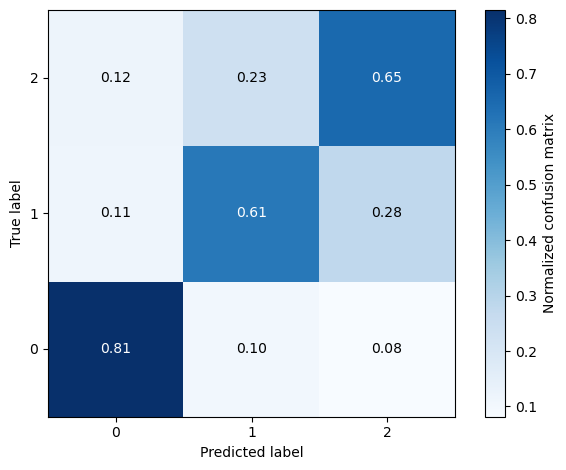

Epoch 46/200 - Learning Rate: 0.000080


Train Loss: 0.785504 | Val Loss: 0.734511 | Val Acc: 0.798 | Balanced Acc: 0.686
Epoch 46/200 took 265.60 seconds


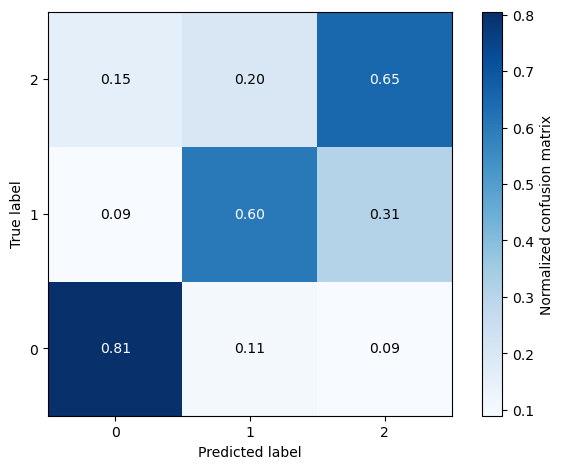

Epoch 47/200 - Learning Rate: 0.000080


Train Loss: 0.782631 | Val Loss: 0.726517 | Val Acc: 0.811 | Balanced Acc: 0.666
Epoch 47/200 took 264.83 seconds


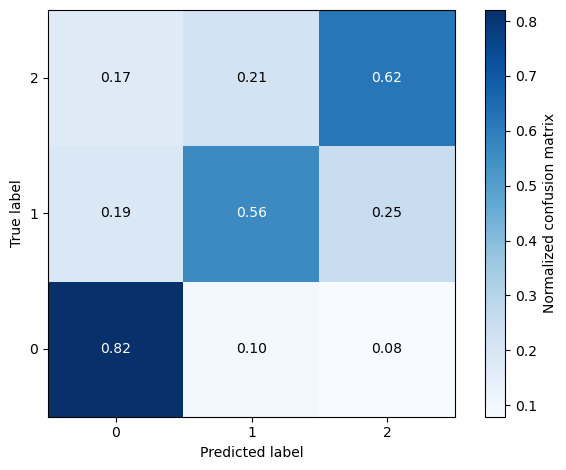

Epoch 48/200 - Learning Rate: 0.000080


Train Loss: 0.779718 | Val Loss: 0.733230 | Val Acc: 0.805 | Balanced Acc: 0.647
Epoch 48/200 took 263.77 seconds


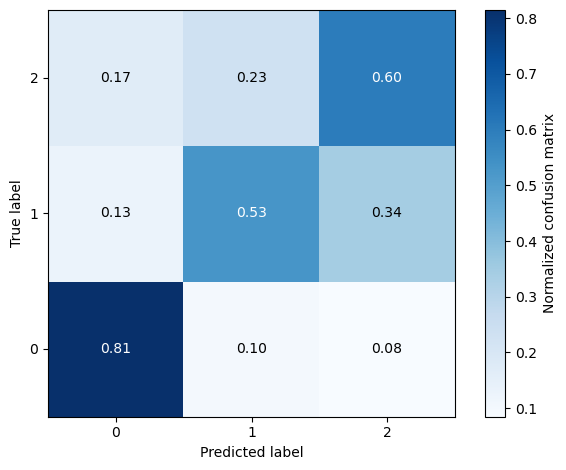

Epoch 49/200 - Learning Rate: 0.000080


Train Loss: 0.781605 | Val Loss: 0.723572 | Val Acc: 0.804 | Balanced Acc: 0.691
Epoch 49/200 took 263.79 seconds


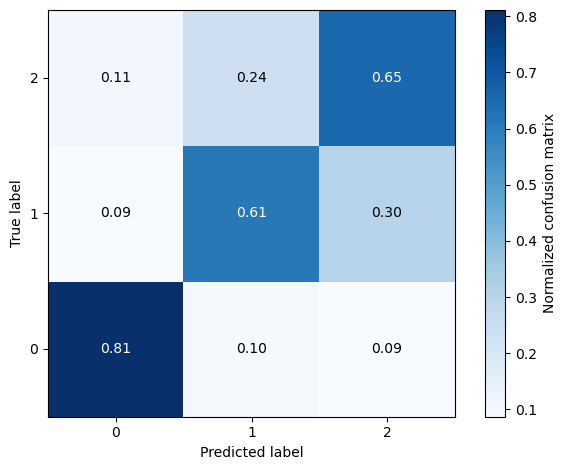

Epoch 50/200 - Learning Rate: 0.000080


Train Loss: 0.777318 | Val Loss: 0.719667 | Val Acc: 0.816 | Balanced Acc: 0.670
Epoch 50/200 took 290.14 seconds


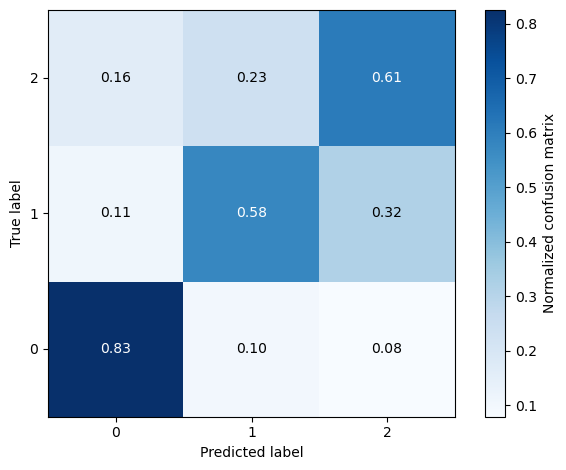

Epoch 51/200 - Learning Rate: 0.000080


Train Loss: 0.776247 | Val Loss: 0.713855 | Val Acc: 0.814 | Balanced Acc: 0.708
Epoch 51/200 took 326.93 seconds


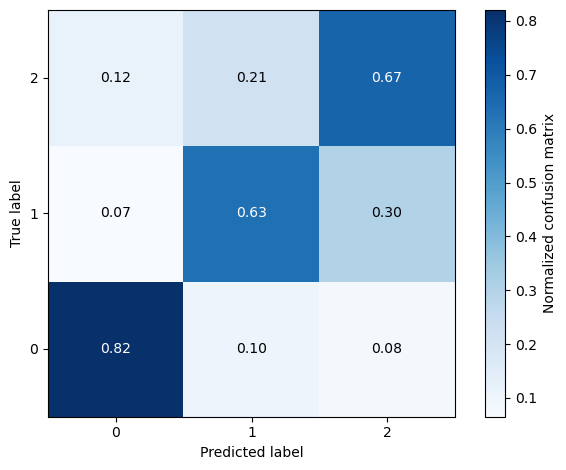

Epoch 52/200 - Learning Rate: 0.000080


Train Loss: 0.772205 | Val Loss: 0.704794 | Val Acc: 0.817 | Balanced Acc: 0.685
Epoch 52/200 took 324.92 seconds


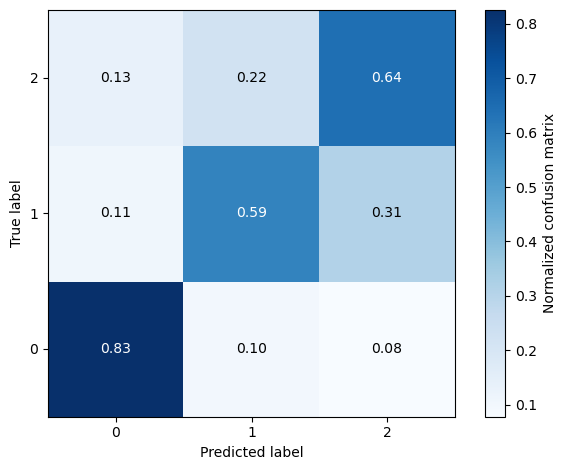

Epoch 53/200 - Learning Rate: 0.000080


Train Loss: 0.773698 | Val Loss: 0.703797 | Val Acc: 0.817 | Balanced Acc: 0.677
Epoch 53/200 took 323.23 seconds


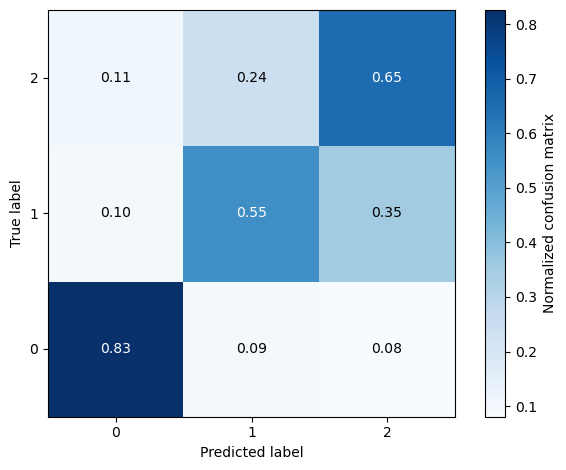

Epoch 54/200 - Learning Rate: 0.000080


Train Loss: 0.771127 | Val Loss: 0.701695 | Val Acc: 0.821 | Balanced Acc: 0.681
Epoch 54/200 took 323.86 seconds


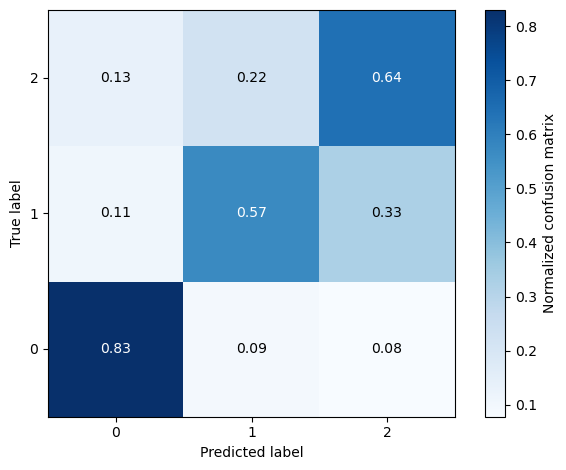

Epoch 55/200 - Learning Rate: 0.000080


Train Loss: 0.766451 | Val Loss: 0.701079 | Val Acc: 0.817 | Balanced Acc: 0.687
Epoch 55/200 took 330.72 seconds


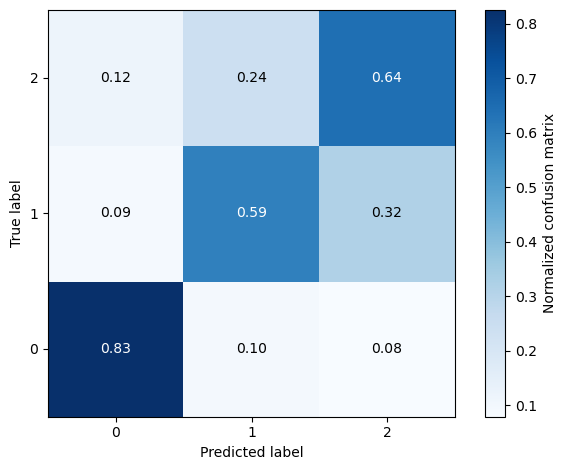

Epoch 56/200 - Learning Rate: 0.000080


Train Loss: 0.761846 | Val Loss: 0.697927 | Val Acc: 0.825 | Balanced Acc: 0.679
Epoch 56/200 took 324.08 seconds


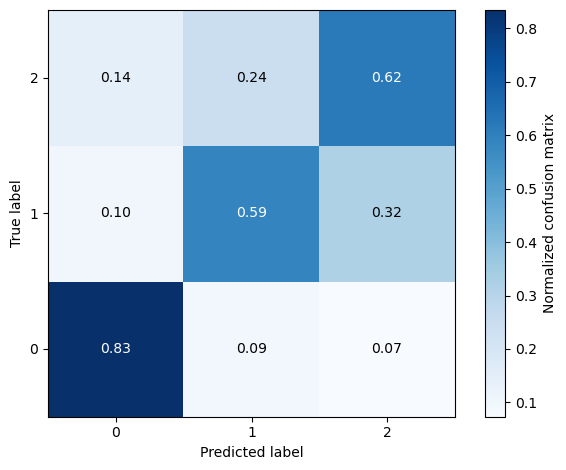

Epoch 57/200 - Learning Rate: 0.000080


Train Loss: 0.764908 | Val Loss: 0.696436 | Val Acc: 0.824 | Balanced Acc: 0.685
Epoch 57/200 took 317.24 seconds


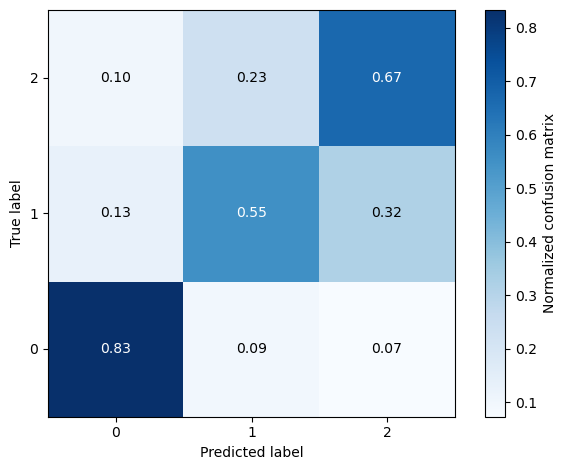

Epoch 58/200 - Learning Rate: 0.000080


Train Loss: 0.762472 | Val Loss: 0.700380 | Val Acc: 0.825 | Balanced Acc: 0.675
Epoch 58/200 took 328.05 seconds


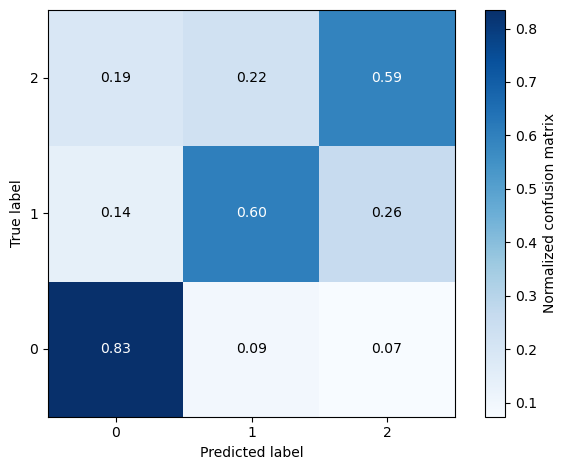

Epoch 59/200 - Learning Rate: 0.000080


Train Loss: 0.760600 | Val Loss: 0.699358 | Val Acc: 0.824 | Balanced Acc: 0.669
Epoch 59/200 took 329.58 seconds


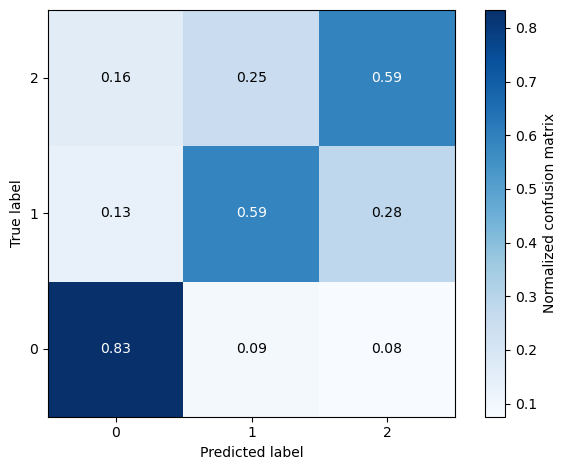

Epoch 60/200 - Learning Rate: 0.000080


Train Loss: 0.753364 | Val Loss: 0.693491 | Val Acc: 0.830 | Balanced Acc: 0.683
Epoch 60/200 took 322.55 seconds


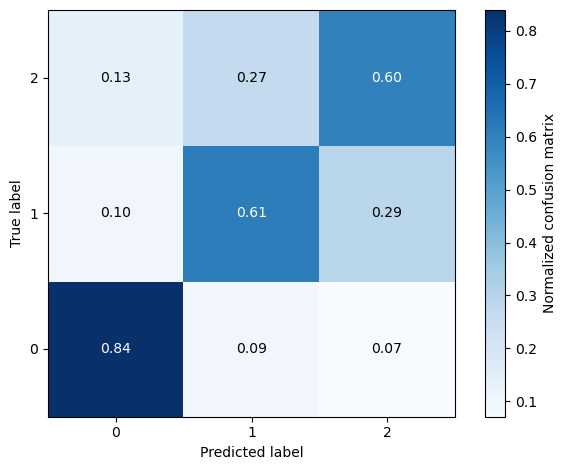

Epoch 61/200 - Learning Rate: 0.000080


Train Loss: 0.755849 | Val Loss: 0.685752 | Val Acc: 0.838 | Balanced Acc: 0.683
Epoch 61/200 took 332.41 seconds


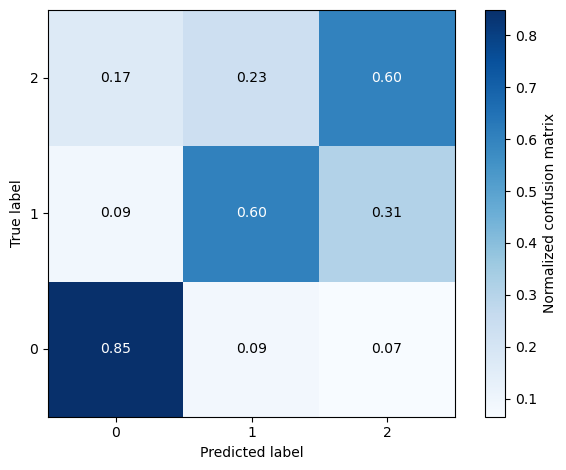

Epoch 62/200 - Learning Rate: 0.000080


Train Loss: 0.754169 | Val Loss: 0.689946 | Val Acc: 0.820 | Balanced Acc: 0.699
Epoch 62/200 took 315.72 seconds


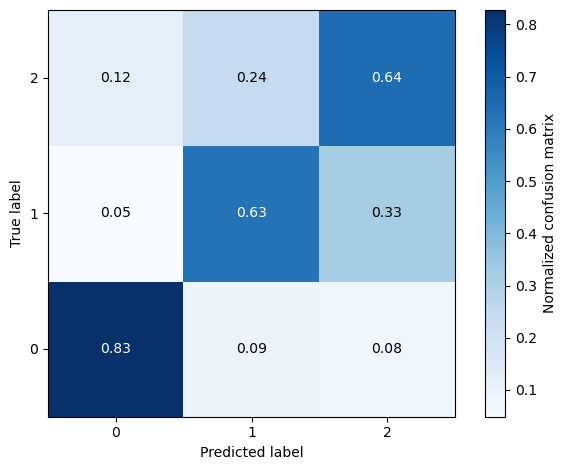

Epoch 63/200 - Learning Rate: 0.000080


Train Loss: 0.750731 | Val Loss: 0.682318 | Val Acc: 0.834 | Balanced Acc: 0.682
Epoch 63/200 took 332.13 seconds


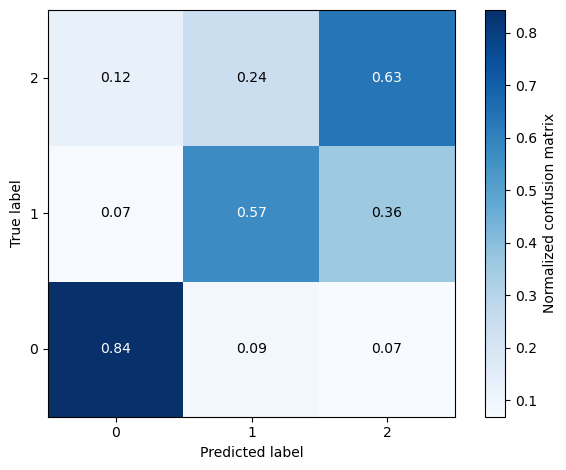

Epoch 64/200 - Learning Rate: 0.000080


Train Loss: 0.751218 | Val Loss: 0.690900 | Val Acc: 0.820 | Balanced Acc: 0.671
Epoch 64/200 took 325.39 seconds


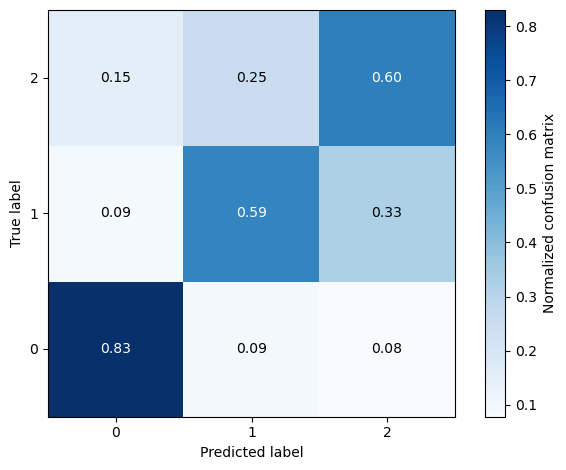

Epoch 65/200 - Learning Rate: 0.000080


Train Loss: 0.751174 | Val Loss: 0.683495 | Val Acc: 0.831 | Balanced Acc: 0.687
Epoch 65/200 took 332.04 seconds


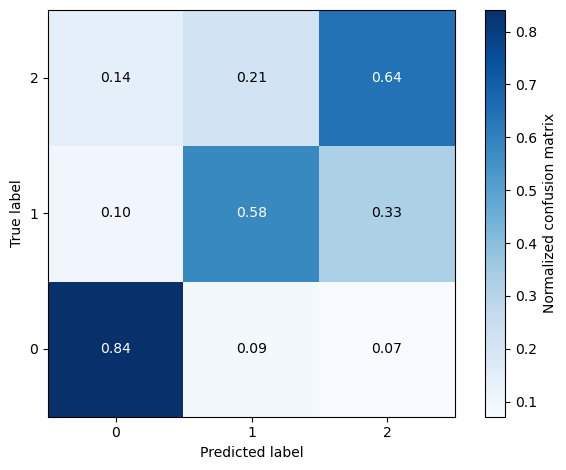

Epoch 66/200 - Learning Rate: 0.000080


Train Loss: 0.745592 | Val Loss: 0.684367 | Val Acc: 0.826 | Balanced Acc: 0.694
Epoch 66/200 took 326.50 seconds


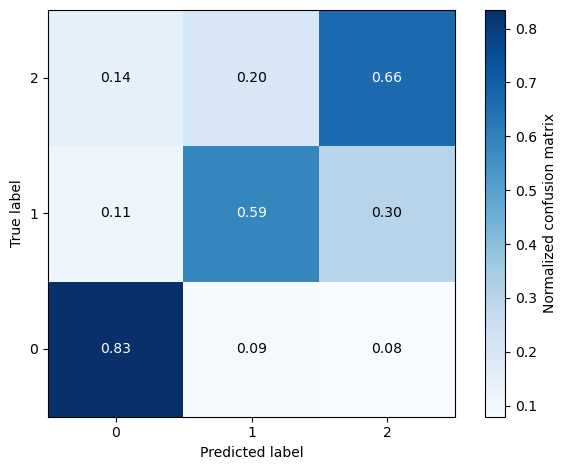

Epoch 67/200 - Learning Rate: 0.000080


Train Loss: 0.746680 | Val Loss: 0.687998 | Val Acc: 0.816 | Balanced Acc: 0.678
Epoch 67/200 took 326.13 seconds


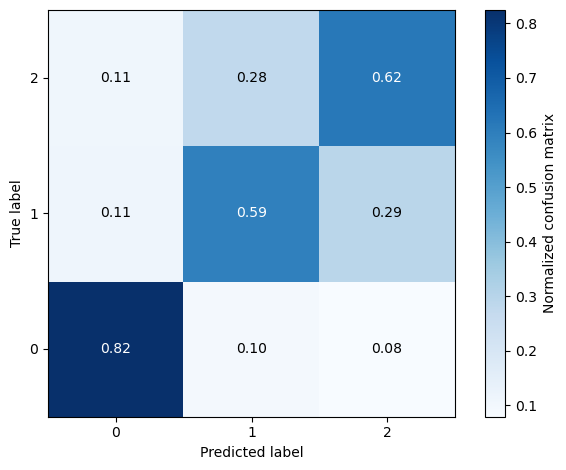

Epoch 68/200 - Learning Rate: 0.000080


Train Loss: 0.747107 | Val Loss: 0.683557 | Val Acc: 0.825 | Balanced Acc: 0.701
Epoch 68/200 took 333.62 seconds


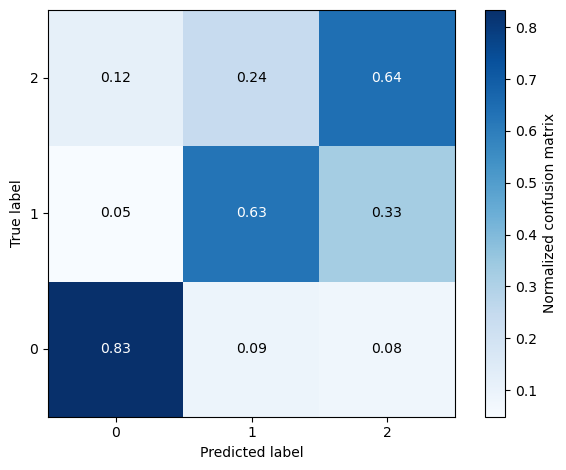

Epoch 69/200 - Learning Rate: 0.000080


Train Loss: 0.746695 | Val Loss: 0.683568 | Val Acc: 0.833 | Balanced Acc: 0.673
Epoch 69/200 took 333.04 seconds


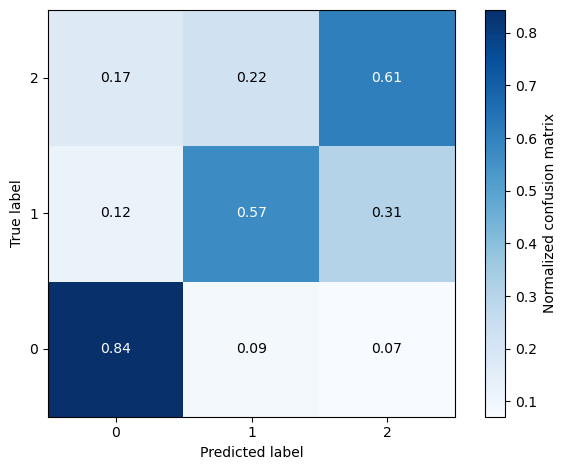

Epoch 70/200 - Learning Rate: 0.000080


Train Loss: 0.743191 | Val Loss: 0.672447 | Val Acc: 0.833 | Balanced Acc: 0.701
Epoch 70/200 took 332.97 seconds


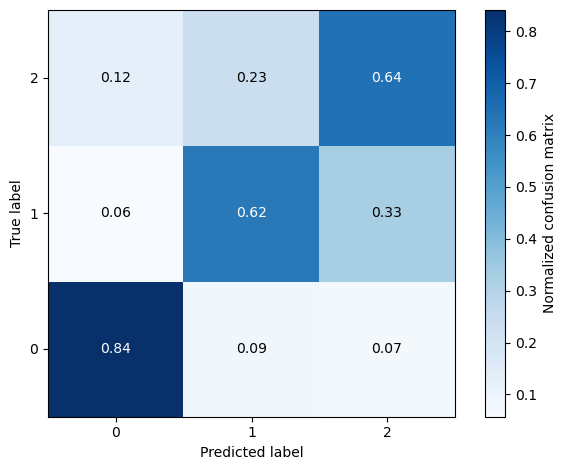

Epoch 71/200 - Learning Rate: 0.000080


Train Loss: 0.739680 | Val Loss: 0.681171 | Val Acc: 0.831 | Balanced Acc: 0.687
Epoch 71/200 took 330.87 seconds


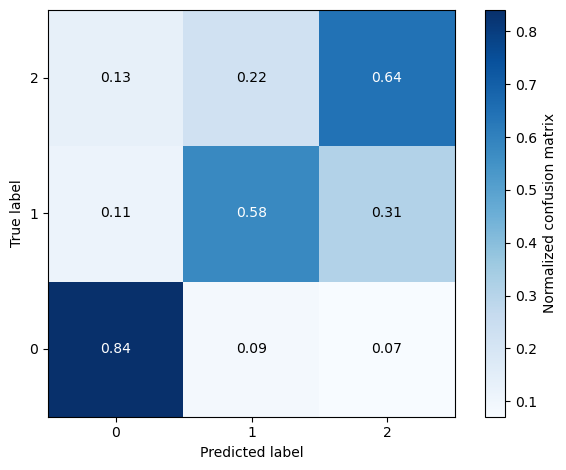

Epoch 72/200 - Learning Rate: 0.000080


Train Loss: 0.737364 | Val Loss: 0.671968 | Val Acc: 0.831 | Balanced Acc: 0.698
Epoch 72/200 took 330.26 seconds


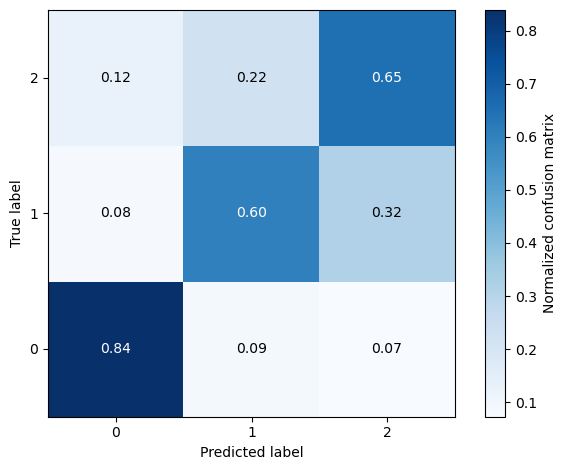

Epoch 73/200 - Learning Rate: 0.000080


Train Loss: 0.742127 | Val Loss: 0.685870 | Val Acc: 0.832 | Balanced Acc: 0.696
Epoch 73/200 took 331.78 seconds


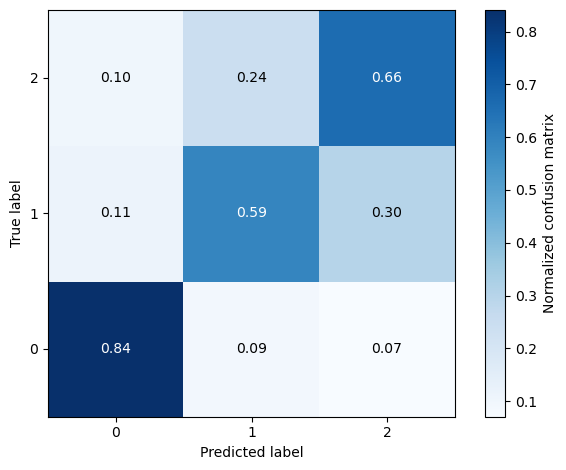

Epoch 74/200 - Learning Rate: 0.000080


Train Loss: 0.740459 | Val Loss: 0.680551 | Val Acc: 0.830 | Balanced Acc: 0.684
Epoch 74/200 took 331.74 seconds


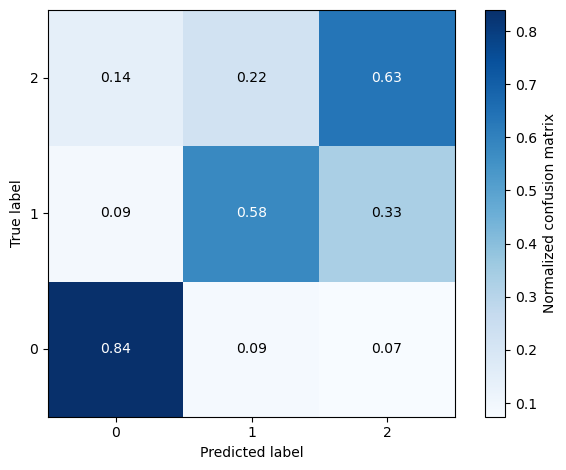

Epoch 75/200 - Learning Rate: 0.000080


Train Loss: 0.735040 | Val Loss: 0.675986 | Val Acc: 0.827 | Balanced Acc: 0.705
Epoch 75/200 took 322.64 seconds


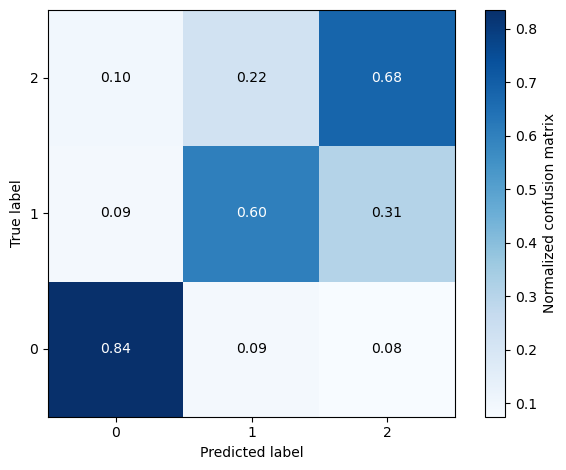

Epoch 76/200 - Learning Rate: 0.000080


Train Loss: 0.732937 | Val Loss: 0.657232 | Val Acc: 0.851 | Balanced Acc: 0.700
Epoch 76/200 took 333.11 seconds


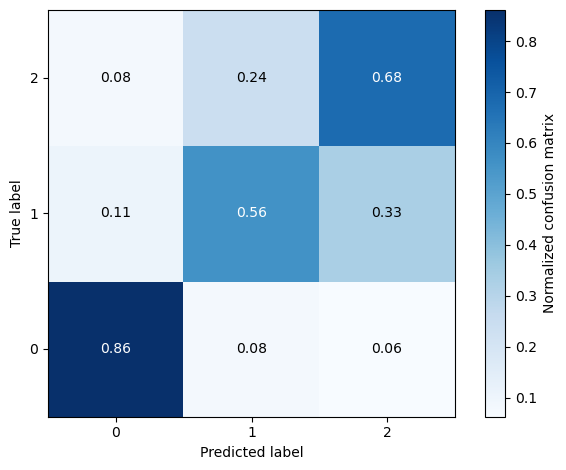

Epoch 77/200 - Learning Rate: 0.000080


Train Loss: 0.732758 | Val Loss: 0.661670 | Val Acc: 0.843 | Balanced Acc: 0.688
Epoch 77/200 took 333.28 seconds


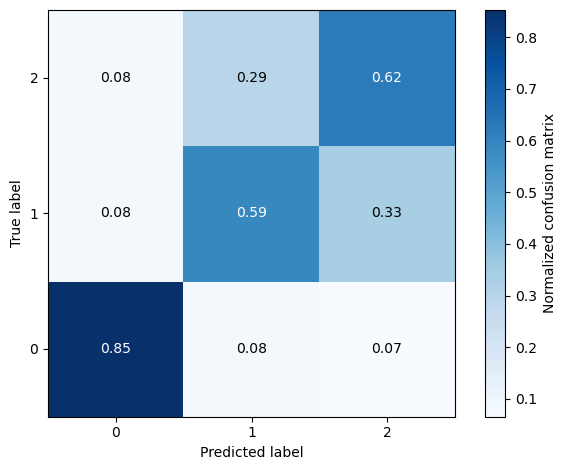

Epoch 78/200 - Learning Rate: 0.000080


Train Loss: 0.736031 | Val Loss: 0.661393 | Val Acc: 0.844 | Balanced Acc: 0.708
Epoch 78/200 took 323.16 seconds


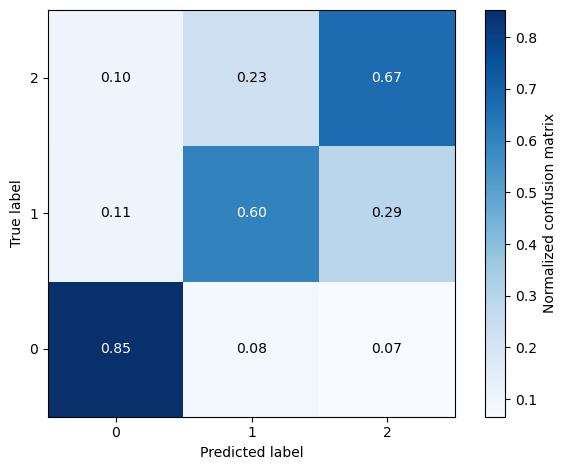

Epoch 79/200 - Learning Rate: 0.000080


Train Loss: 0.731177 | Val Loss: 0.669745 | Val Acc: 0.838 | Balanced Acc: 0.686
Epoch 79/200 took 323.17 seconds


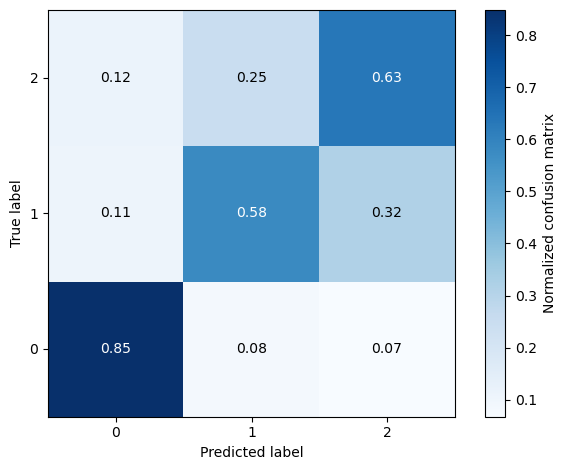

Epoch 80/200 - Learning Rate: 0.000080


Train Loss: 0.729547 | Val Loss: 0.665417 | Val Acc: 0.846 | Balanced Acc: 0.675
Epoch 80/200 took 330.90 seconds


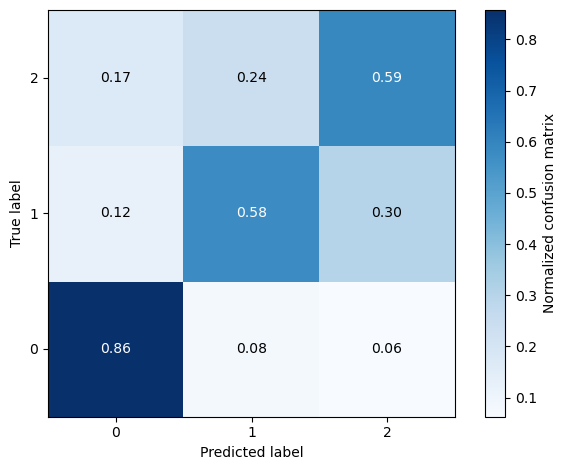

Epoch 81/200 - Learning Rate: 0.000080


Train Loss: 0.725940 | Val Loss: 0.659964 | Val Acc: 0.843 | Balanced Acc: 0.704
Epoch 81/200 took 329.26 seconds


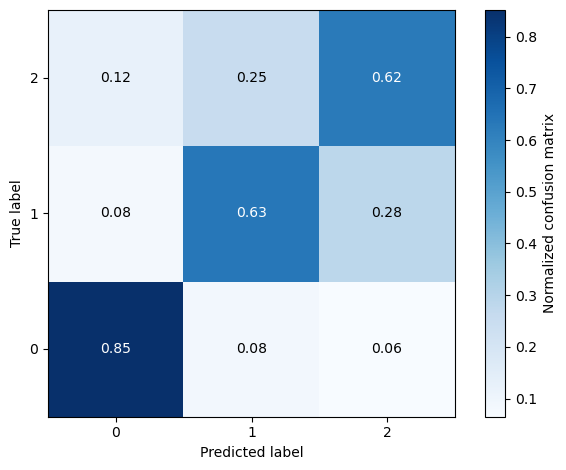

Epoch 82/200 - Learning Rate: 0.000080


Train Loss: 0.725900 | Val Loss: 0.656656 | Val Acc: 0.845 | Balanced Acc: 0.686
Epoch 82/200 took 332.00 seconds


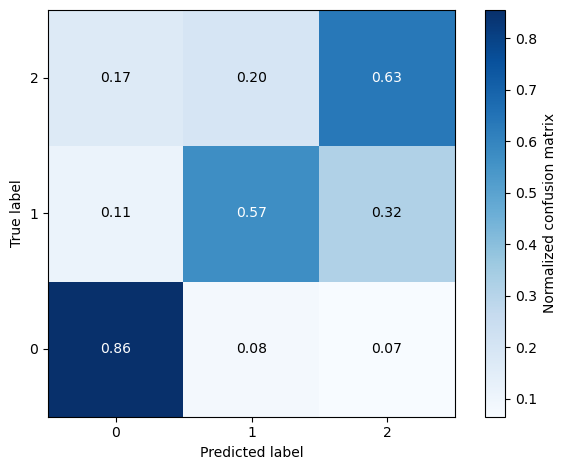

Epoch 83/200 - Learning Rate: 0.000080


Train Loss: 0.727204 | Val Loss: 0.663394 | Val Acc: 0.833 | Balanced Acc: 0.701
Epoch 83/200 took 332.50 seconds


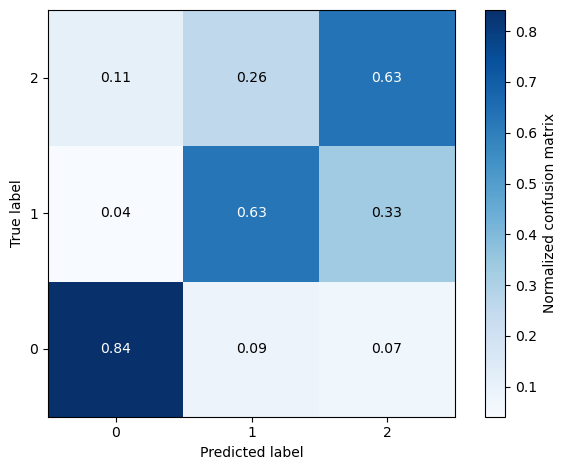

Epoch 84/200 - Learning Rate: 0.000080


Train Loss: 0.722391 | Val Loss: 0.652063 | Val Acc: 0.845 | Balanced Acc: 0.708
Epoch 84/200 took 332.90 seconds


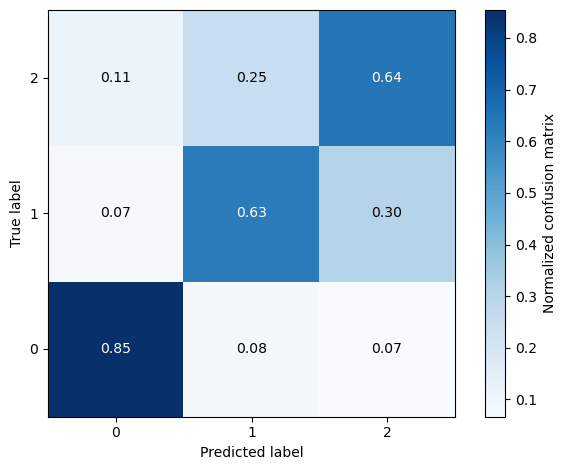

Epoch 85/200 - Learning Rate: 0.000080


Train Loss: 0.720803 | Val Loss: 0.654466 | Val Acc: 0.843 | Balanced Acc: 0.702
Epoch 85/200 took 317.80 seconds


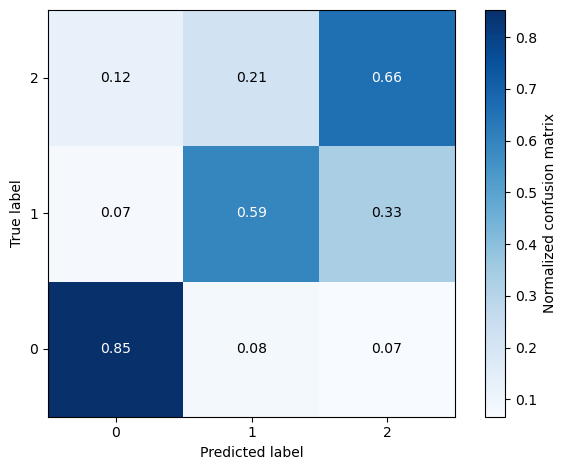

Epoch 86/200 - Learning Rate: 0.000080


Train Loss: 0.723811 | Val Loss: 0.653529 | Val Acc: 0.841 | Balanced Acc: 0.712
Epoch 86/200 took 308.85 seconds


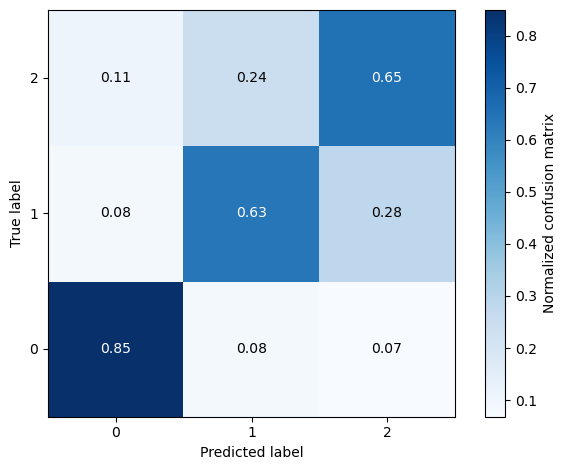

Epoch 87/200 - Learning Rate: 0.000080


Train Loss: 0.725358 | Val Loss: 0.646790 | Val Acc: 0.844 | Balanced Acc: 0.724
Epoch 87/200 took 260.20 seconds


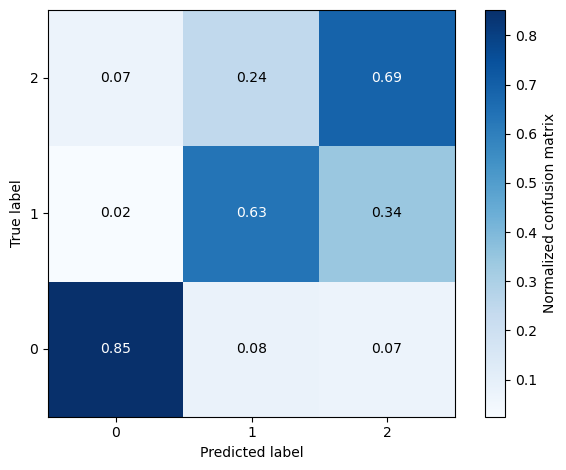

Epoch 88/200 - Learning Rate: 0.000080


Train Loss: 0.723958 | Val Loss: 0.660570 | Val Acc: 0.838 | Balanced Acc: 0.700
Epoch 88/200 took 259.90 seconds


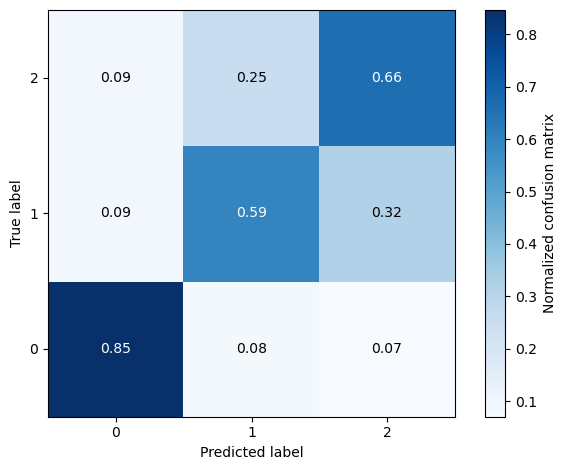

Epoch 89/200 - Learning Rate: 0.000080


Train Loss: 0.722202 | Val Loss: 0.648041 | Val Acc: 0.845 | Balanced Acc: 0.688
Epoch 89/200 took 259.95 seconds


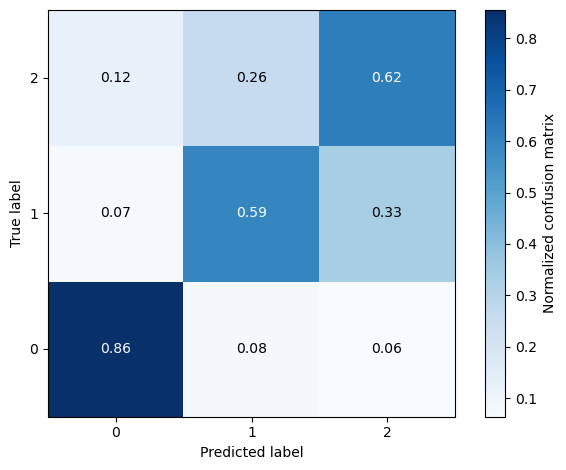

Epoch 90/200 - Learning Rate: 0.000080


Train Loss: 0.716330 | Val Loss: 0.649277 | Val Acc: 0.845 | Balanced Acc: 0.691
Epoch 90/200 took 259.73 seconds


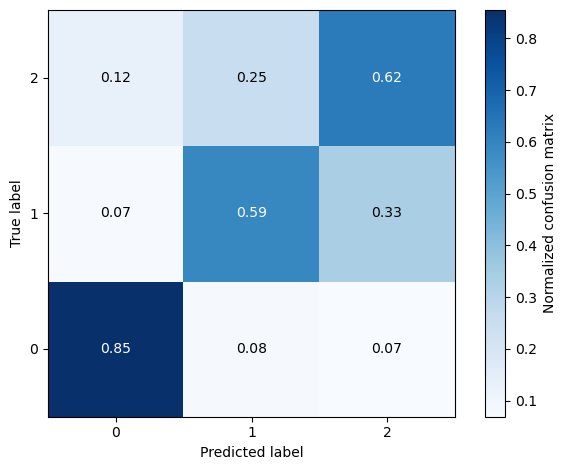

Epoch 91/200 - Learning Rate: 0.000080


Train Loss: 0.715934 | Val Loss: 0.645396 | Val Acc: 0.851 | Balanced Acc: 0.691
Epoch 91/200 took 259.11 seconds


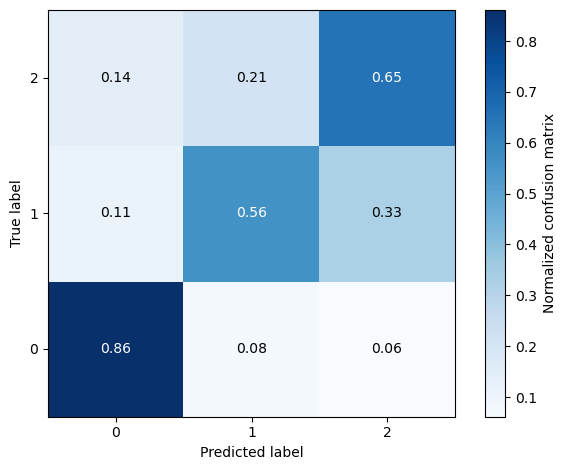

Epoch 92/200 - Learning Rate: 0.000080


Train Loss: 0.718467 | Val Loss: 0.641676 | Val Acc: 0.847 | Balanced Acc: 0.689
Epoch 92/200 took 258.92 seconds


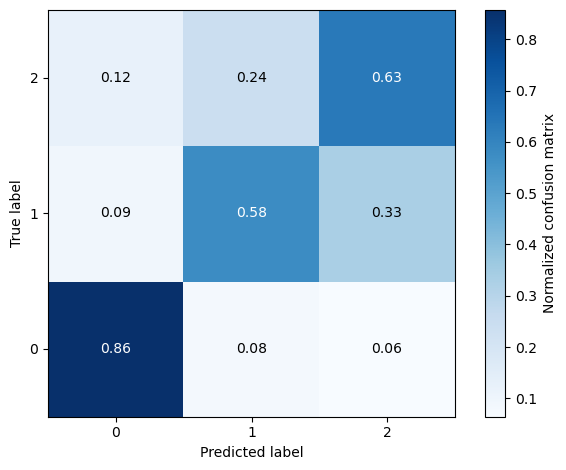

Epoch 93/200 - Learning Rate: 0.000080


Train Loss: 0.716813 | Val Loss: 0.644707 | Val Acc: 0.845 | Balanced Acc: 0.722
Epoch 93/200 took 259.70 seconds


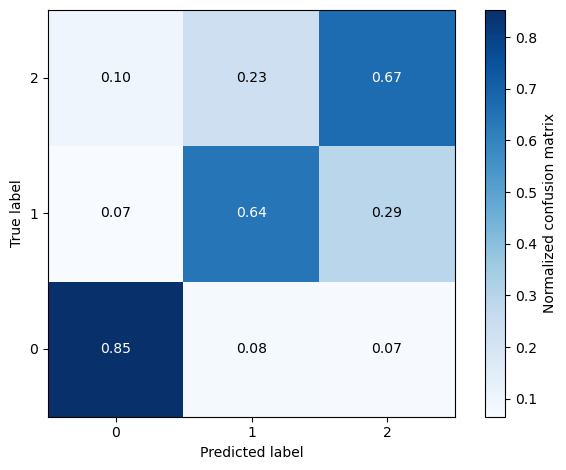

Epoch 94/200 - Learning Rate: 0.000080


Train Loss: 0.712446 | Val Loss: 0.639711 | Val Acc: 0.848 | Balanced Acc: 0.718
Epoch 94/200 took 259.35 seconds


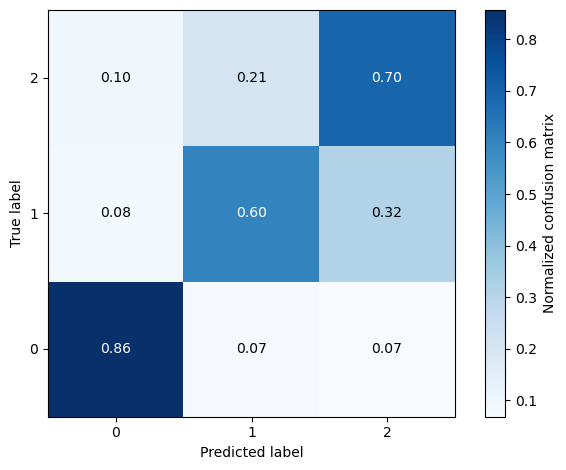

Epoch 95/200 - Learning Rate: 0.000080


Train Loss: 0.716983 | Val Loss: 0.638852 | Val Acc: 0.842 | Balanced Acc: 0.710
Epoch 95/200 took 260.52 seconds


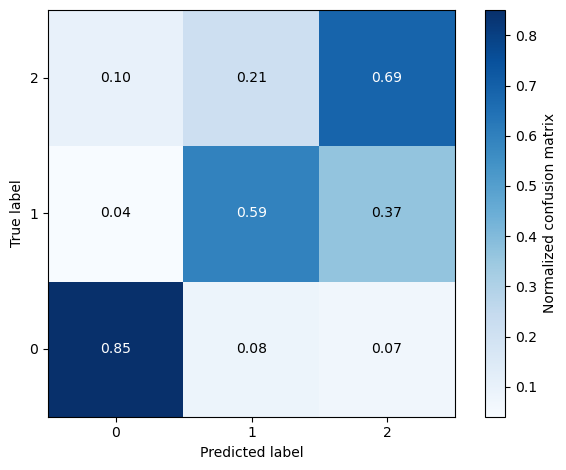

Epoch 96/200 - Learning Rate: 0.000080


Train Loss: 0.712375 | Val Loss: 0.645748 | Val Acc: 0.836 | Balanced Acc: 0.697
Epoch 96/200 took 259.31 seconds


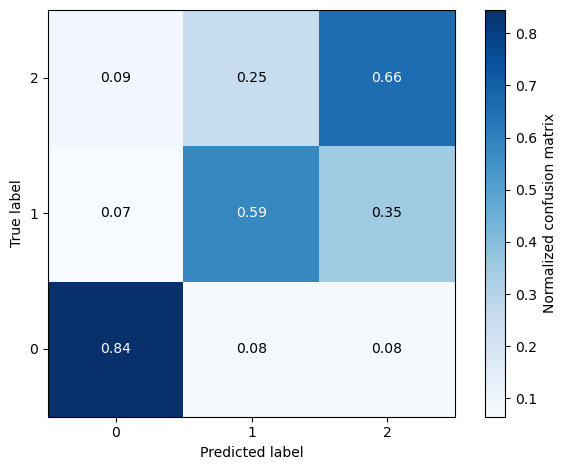

Epoch 97/200 - Learning Rate: 0.000080


Train Loss: 0.713464 | Val Loss: 0.627198 | Val Acc: 0.854 | Balanced Acc: 0.713
Epoch 97/200 took 259.46 seconds


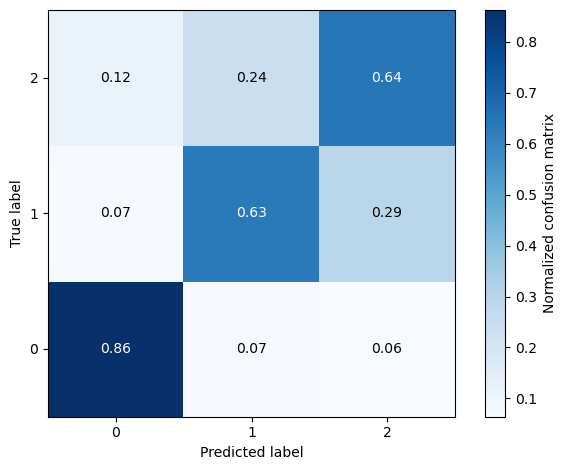

Epoch 98/200 - Learning Rate: 0.000080


Train Loss: 0.715173 | Val Loss: 0.621046 | Val Acc: 0.853 | Balanced Acc: 0.725
Epoch 98/200 took 260.25 seconds


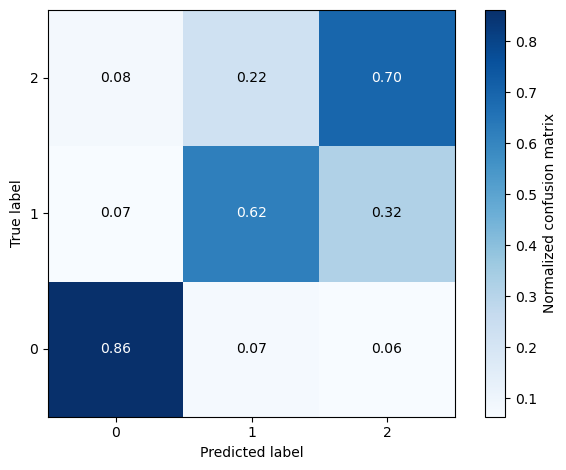

Epoch 99/200 - Learning Rate: 0.000080


Train Loss: 0.711294 | Val Loss: 0.644472 | Val Acc: 0.849 | Balanced Acc: 0.712
Epoch 99/200 took 259.13 seconds


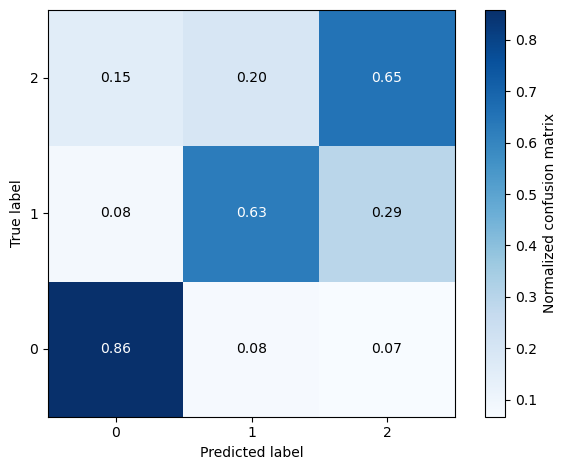

Epoch 100/200 - Learning Rate: 0.000080


Train Loss: 0.712356 | Val Loss: 0.621641 | Val Acc: 0.853 | Balanced Acc: 0.719
Epoch 100/200 took 259.09 seconds


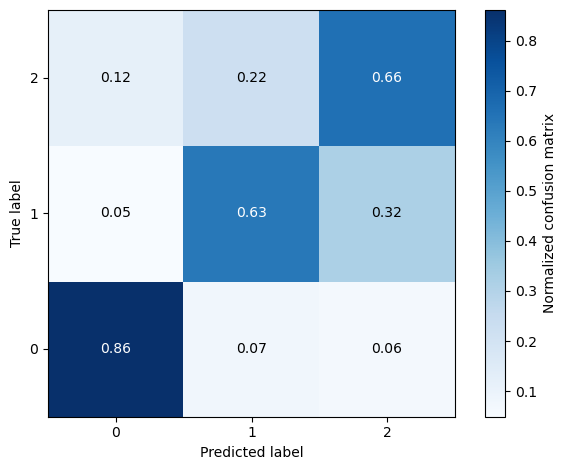

Epoch 101/200 - Learning Rate: 0.000080


Train Loss: 0.711184 | Val Loss: 0.622629 | Val Acc: 0.858 | Balanced Acc: 0.708
Epoch 101/200 took 259.00 seconds


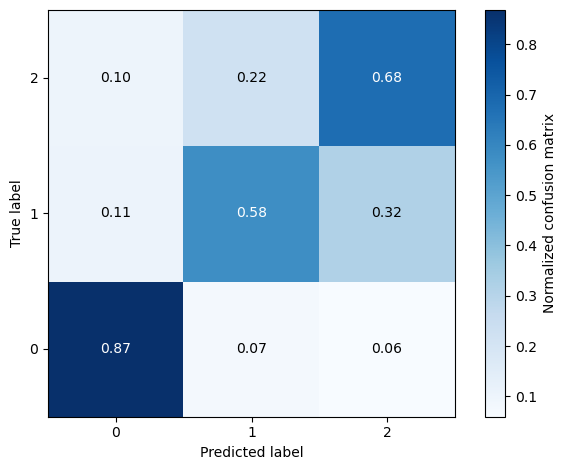

Epoch 102/200 - Learning Rate: 0.000080


Train Loss: 0.711401 | Val Loss: 0.622072 | Val Acc: 0.859 | Balanced Acc: 0.707
Epoch 102/200 took 259.19 seconds


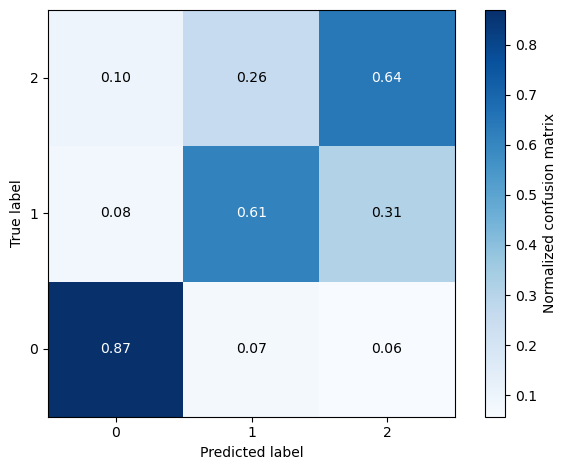

Epoch 103/200 - Learning Rate: 0.000080


Train Loss: 0.710358 | Val Loss: 0.635618 | Val Acc: 0.853 | Balanced Acc: 0.699
Epoch 103/200 took 259.45 seconds


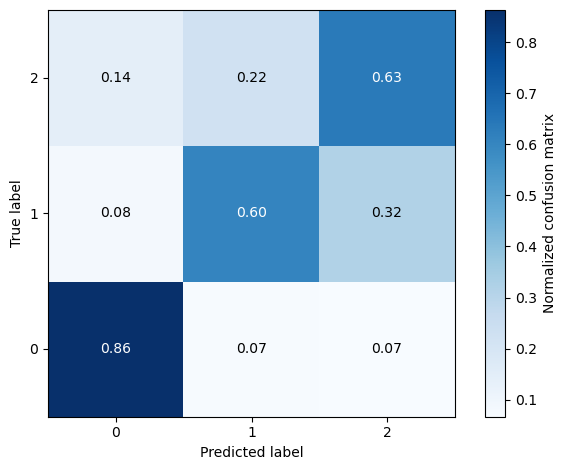

Epoch 104/200 - Learning Rate: 0.000080


Train Loss: 0.707618 | Val Loss: 0.625157 | Val Acc: 0.852 | Balanced Acc: 0.705
Epoch 104/200 took 258.88 seconds


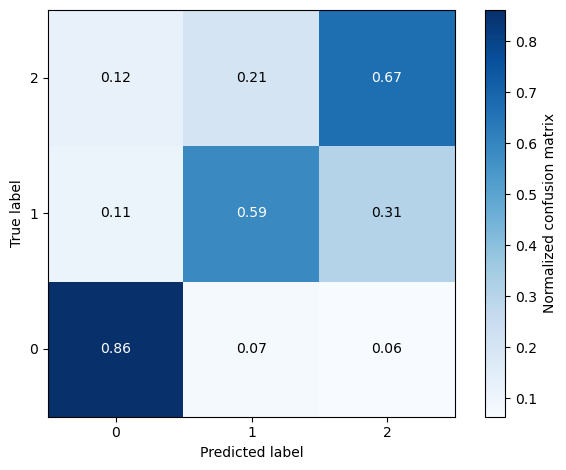

Epoch 105/200 - Learning Rate: 0.000080


Train Loss: 0.704984 | Val Loss: 0.636059 | Val Acc: 0.856 | Balanced Acc: 0.707
Epoch 105/200 took 258.91 seconds


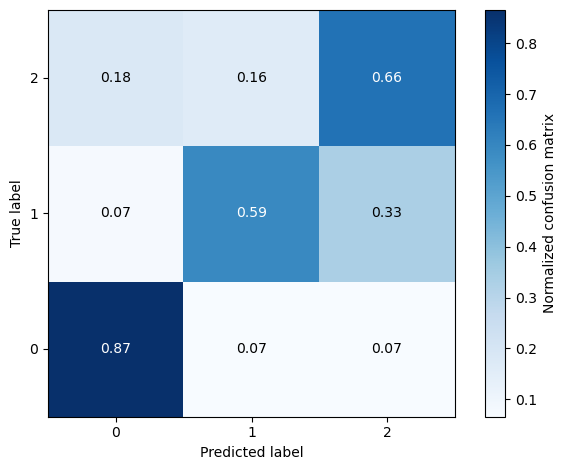

Epoch 106/200 - Learning Rate: 0.000080


Train Loss: 0.707453 | Val Loss: 0.621494 | Val Acc: 0.871 | Balanced Acc: 0.715
Epoch 106/200 took 259.63 seconds


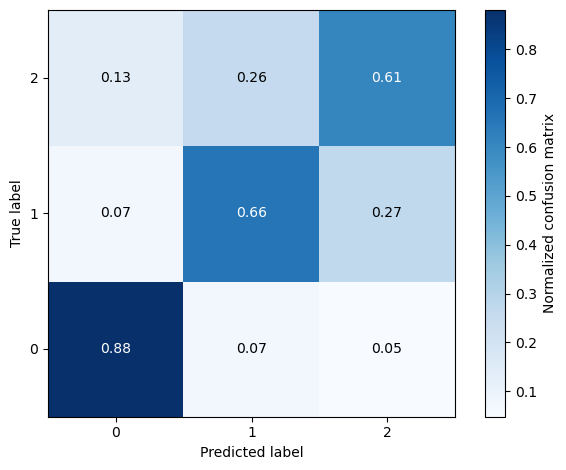

Epoch 107/200 - Learning Rate: 0.000080


Train Loss: 0.704158 | Val Loss: 0.634819 | Val Acc: 0.852 | Balanced Acc: 0.705
Epoch 107/200 took 258.18 seconds


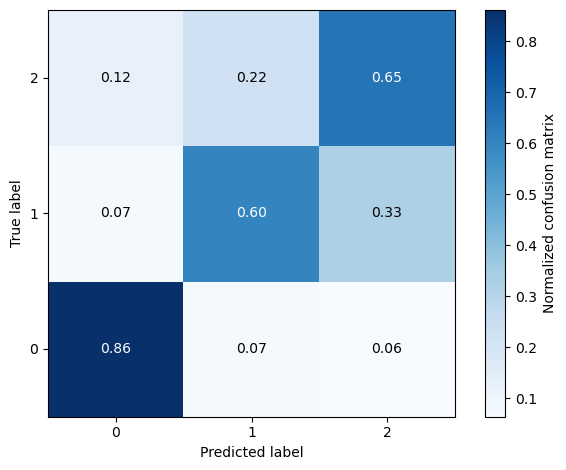

Epoch 108/200 - Learning Rate: 0.000080


Train Loss: 0.706341 | Val Loss: 0.623251 | Val Acc: 0.853 | Balanced Acc: 0.712
Epoch 108/200 took 259.78 seconds


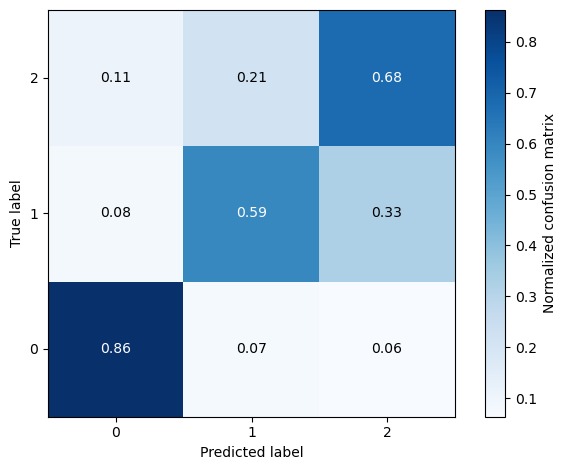

Epoch 109/200 - Learning Rate: 0.000080


Train Loss: 0.703705 | Val Loss: 0.627174 | Val Acc: 0.857 | Balanced Acc: 0.713
Epoch 109/200 took 259.09 seconds


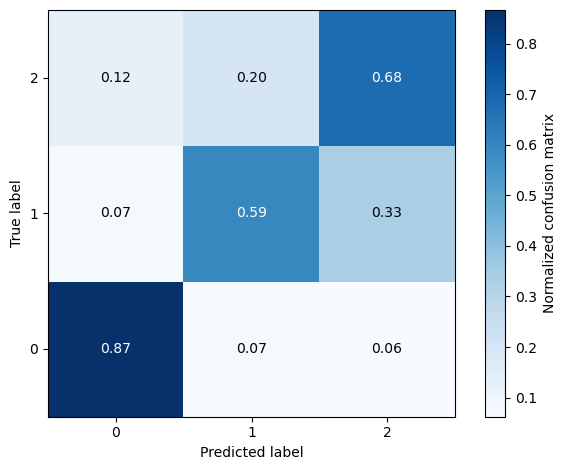

Epoch 110/200 - Learning Rate: 0.000080


Train Loss: 0.703928 | Val Loss: 0.644364 | Val Acc: 0.844 | Balanced Acc: 0.700
Epoch 110/200 took 258.54 seconds


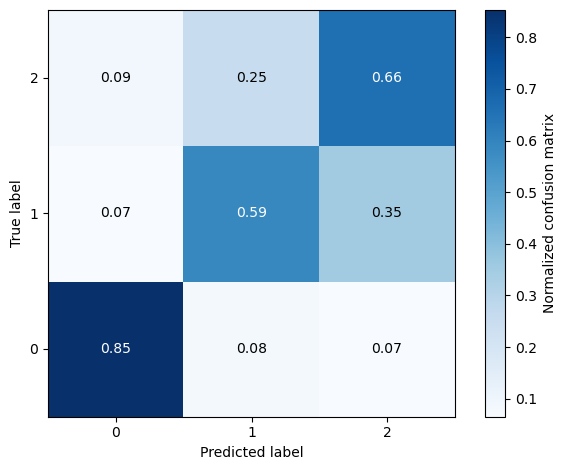

Epoch 111/200 - Learning Rate: 0.000080


Train Loss: 0.704630 | Val Loss: 0.644670 | Val Acc: 0.864 | Balanced Acc: 0.667
Epoch 111/200 took 257.98 seconds


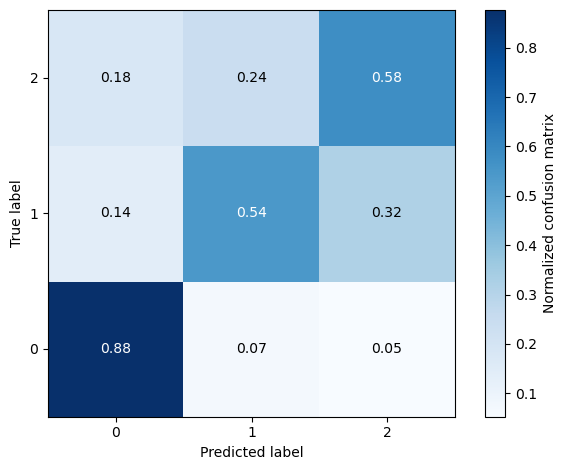

Epoch 112/200 - Learning Rate: 0.000080


Train Loss: 0.698976 | Val Loss: 0.627602 | Val Acc: 0.860 | Balanced Acc: 0.699
Epoch 112/200 took 259.30 seconds


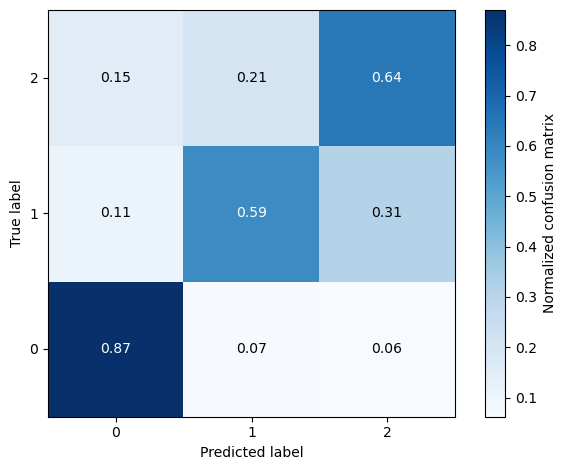

Epoch 113/200 - Learning Rate: 0.000080


Train Loss: 0.704079 | Val Loss: 0.620922 | Val Acc: 0.859 | Balanced Acc: 0.718
Epoch 113/200 took 259.75 seconds


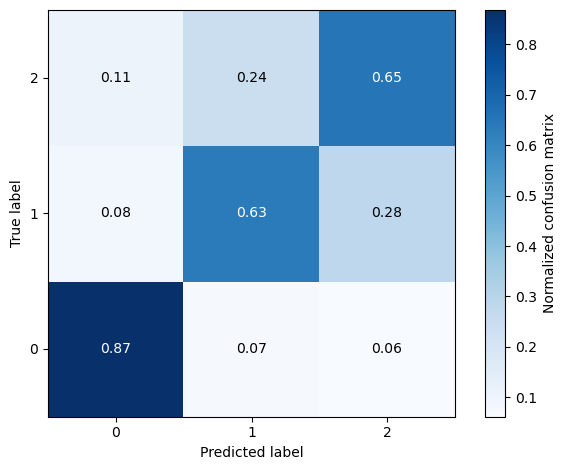

Epoch 114/200 - Learning Rate: 0.000080


Train Loss: 0.698867 | Val Loss: 0.623288 | Val Acc: 0.861 | Balanced Acc: 0.719
Epoch 114/200 took 260.64 seconds


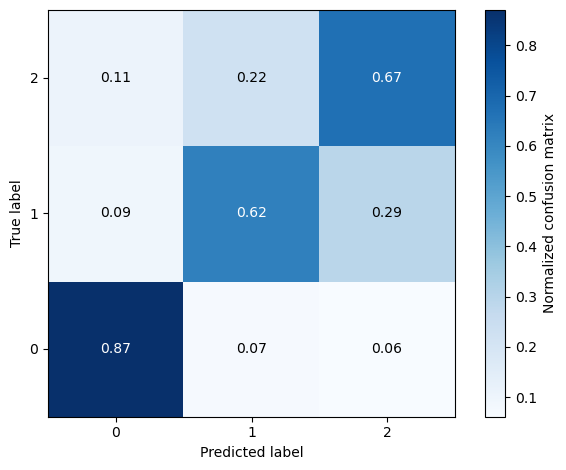

Epoch 115/200 - Learning Rate: 0.000080


Train Loss: 0.700107 | Val Loss: 0.623522 | Val Acc: 0.860 | Balanced Acc: 0.705
Epoch 115/200 took 254.39 seconds


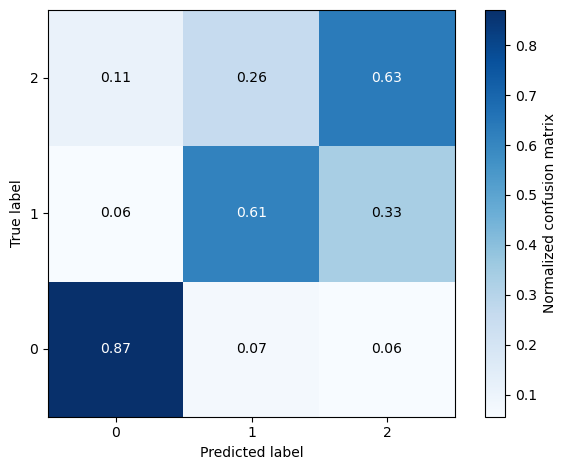

Epoch 116/200 - Learning Rate: 0.000080


Train Loss: 0.697578 | Val Loss: 0.618696 | Val Acc: 0.860 | Balanced Acc: 0.685
Epoch 116/200 took 250.55 seconds


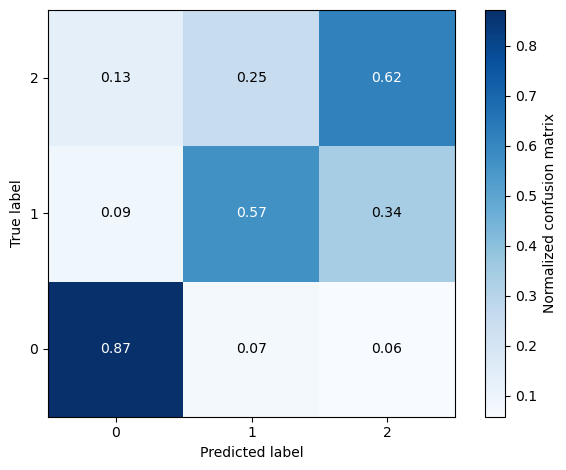

Epoch 117/200 - Learning Rate: 0.000080


Train Loss: 0.696179 | Val Loss: 0.624404 | Val Acc: 0.856 | Balanced Acc: 0.706
Epoch 117/200 took 251.27 seconds


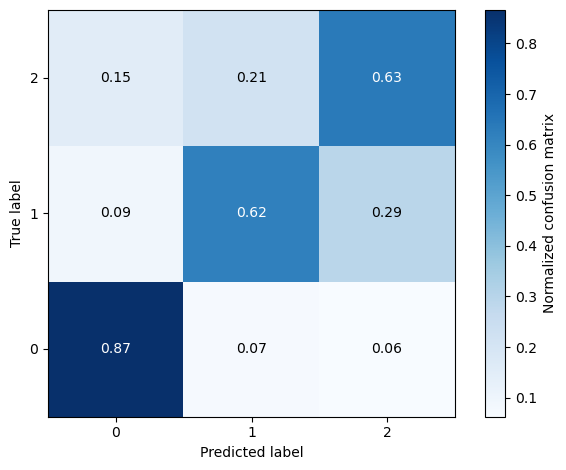

Epoch 118/200 - Learning Rate: 0.000080


Train Loss: 0.695722 | Val Loss: 0.613558 | Val Acc: 0.855 | Balanced Acc: 0.721
Epoch 118/200 took 250.78 seconds


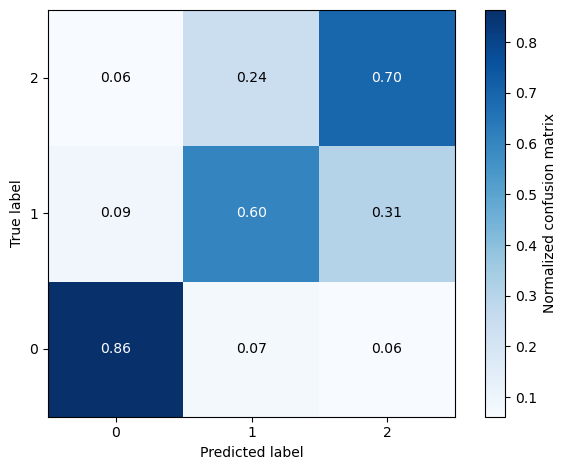

Epoch 119/200 - Learning Rate: 0.000080


Train Loss: 0.700882 | Val Loss: 0.628532 | Val Acc: 0.863 | Balanced Acc: 0.702
Epoch 119/200 took 250.53 seconds


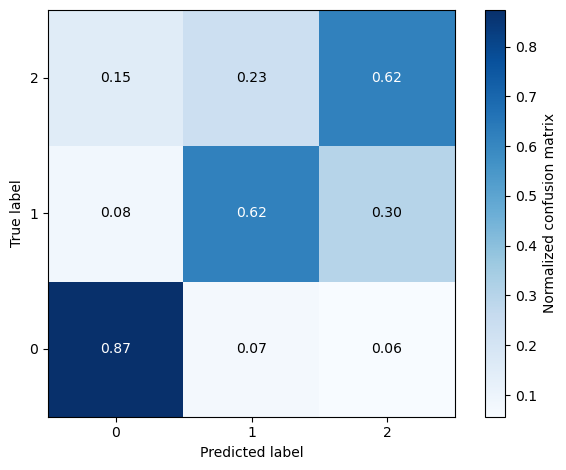

Epoch 120/200 - Learning Rate: 0.000080


Train Loss: 0.694234 | Val Loss: 0.619045 | Val Acc: 0.857 | Balanced Acc: 0.707
Epoch 120/200 took 250.81 seconds


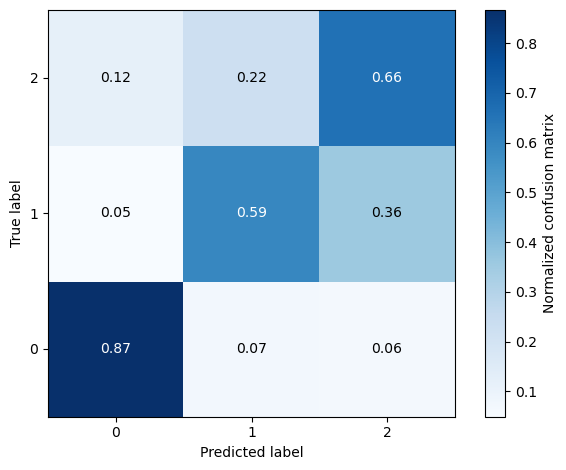

Epoch 121/200 - Learning Rate: 0.000080


Train Loss: 0.698797 | Val Loss: 0.610835 | Val Acc: 0.866 | Balanced Acc: 0.720
Epoch 121/200 took 251.66 seconds


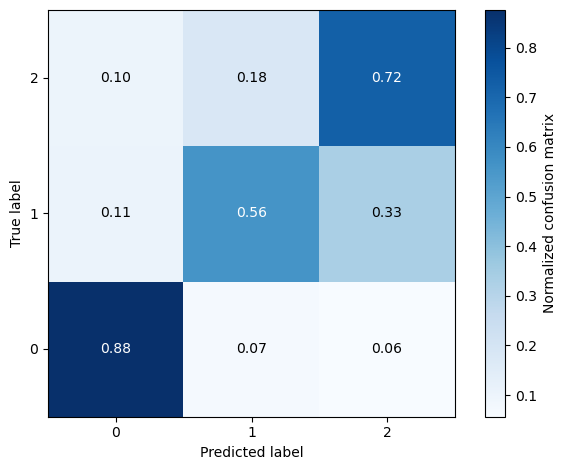

Epoch 122/200 - Learning Rate: 0.000080


Train Loss: 0.692831 | Val Loss: 0.608871 | Val Acc: 0.875 | Balanced Acc: 0.682
Epoch 122/200 took 251.33 seconds


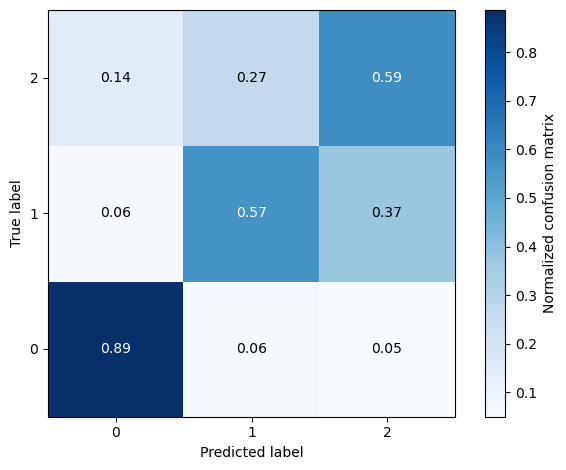

Epoch 123/200 - Learning Rate: 0.000080


Train Loss: 0.694125 | Val Loss: 0.608266 | Val Acc: 0.868 | Balanced Acc: 0.724
Epoch 123/200 took 252.52 seconds


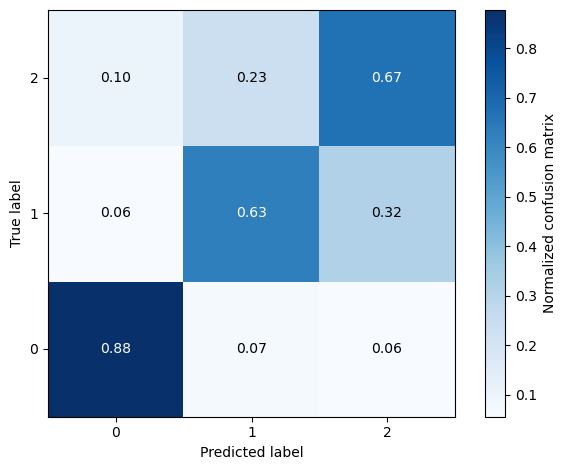

Epoch 124/200 - Learning Rate: 0.000080


Train Loss: 0.691219 | Val Loss: 0.605886 | Val Acc: 0.866 | Balanced Acc: 0.719
Epoch 124/200 took 250.87 seconds


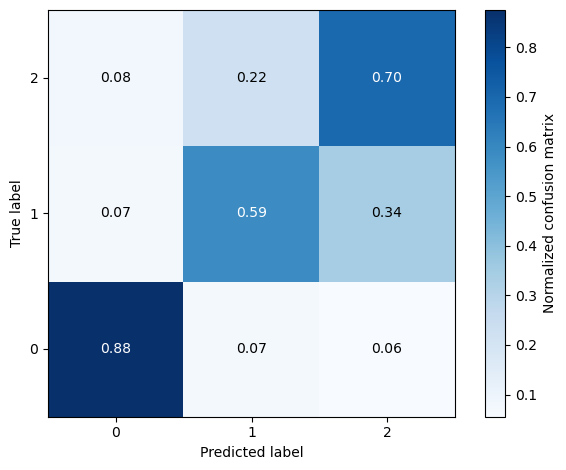

Epoch 125/200 - Learning Rate: 0.000080


Train Loss: 0.691821 | Val Loss: 0.620944 | Val Acc: 0.854 | Balanced Acc: 0.709
Epoch 125/200 took 249.43 seconds


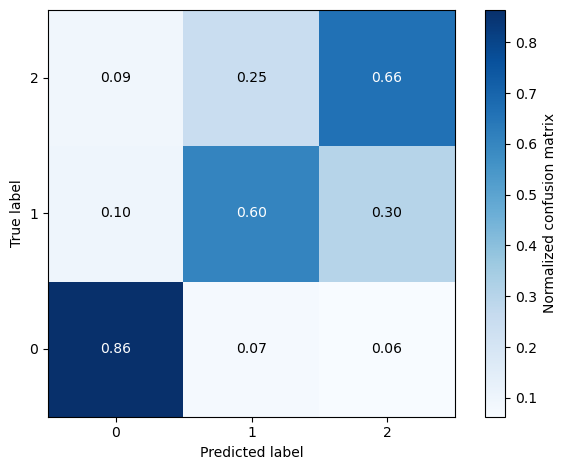

Epoch 126/200 - Learning Rate: 0.000080


Train Loss: 0.693549 | Val Loss: 0.614414 | Val Acc: 0.855 | Balanced Acc: 0.701
Epoch 126/200 took 250.37 seconds


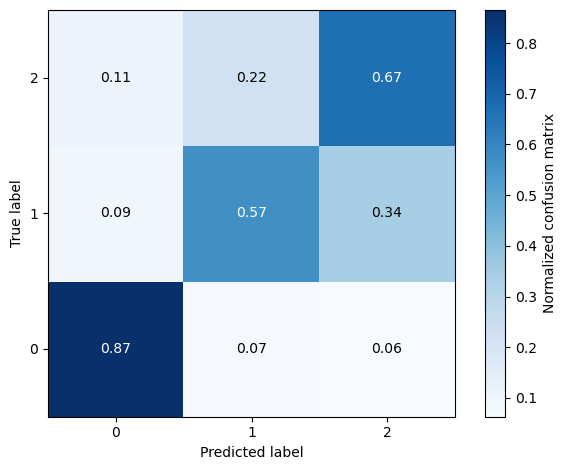

Epoch 127/200 - Learning Rate: 0.000080


Train Loss: 0.694924 | Val Loss: 0.615105 | Val Acc: 0.860 | Balanced Acc: 0.710
Epoch 127/200 took 250.12 seconds


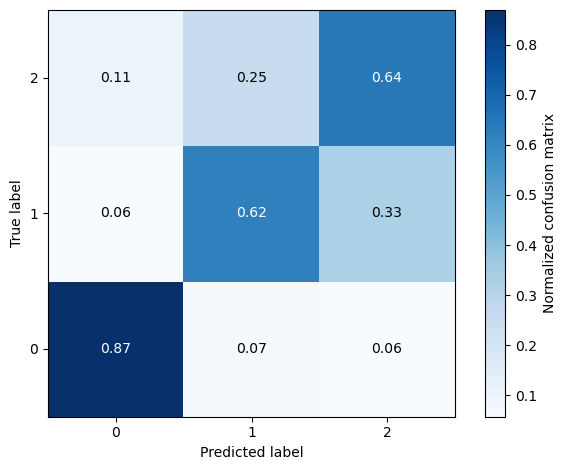

Epoch 128/200 - Learning Rate: 0.000080


Train Loss: 0.689059 | Val Loss: 0.601455 | Val Acc: 0.863 | Balanced Acc: 0.717
Epoch 128/200 took 249.45 seconds


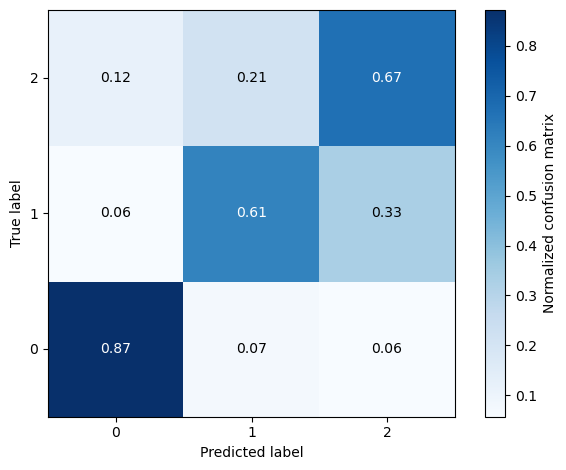

Epoch 129/200 - Learning Rate: 0.000080


Train Loss: 0.688321 | Val Loss: 0.607819 | Val Acc: 0.860 | Balanced Acc: 0.721
Epoch 129/200 took 249.97 seconds


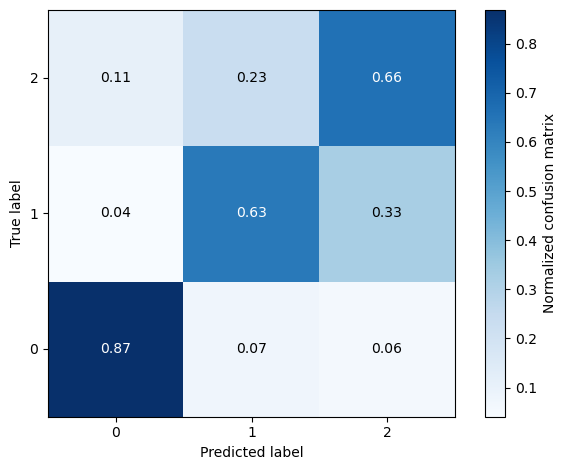

Epoch 130/200 - Learning Rate: 0.000080


Train Loss: 0.688899 | Val Loss: 0.611902 | Val Acc: 0.866 | Balanced Acc: 0.704
Epoch 130/200 took 249.54 seconds


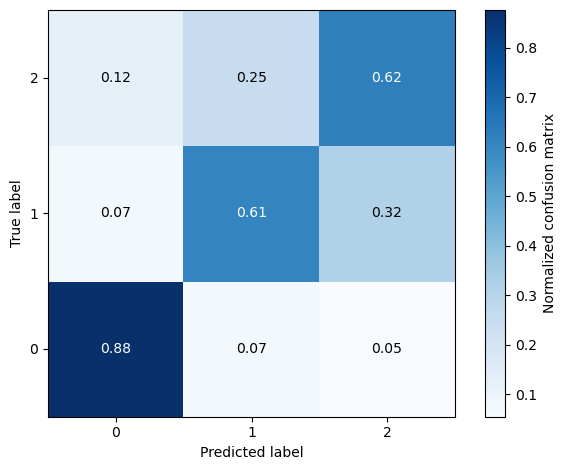

Epoch 131/200 - Learning Rate: 0.000080


Train Loss: 0.692991 | Val Loss: 0.617658 | Val Acc: 0.864 | Balanced Acc: 0.714
Epoch 131/200 took 249.92 seconds


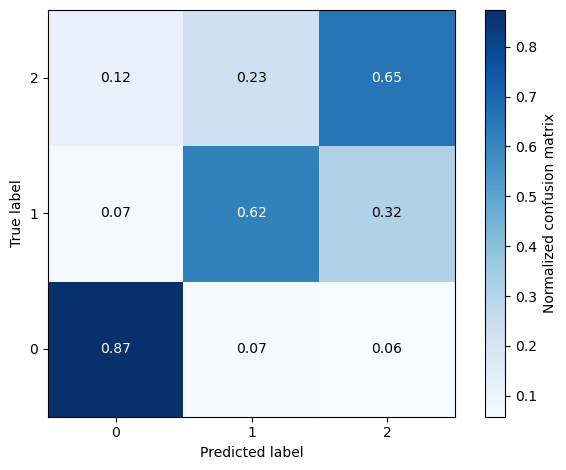

Epoch 132/200 - Learning Rate: 0.000080


Train Loss: 0.688806 | Val Loss: 0.606768 | Val Acc: 0.867 | Balanced Acc: 0.730
Epoch 132/200 took 250.56 seconds


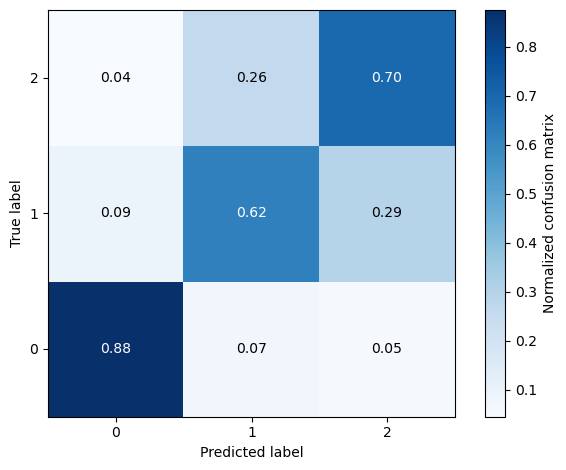

Epoch 133/200 - Learning Rate: 0.000080


Train Loss: 0.683690 | Val Loss: 0.595978 | Val Acc: 0.871 | Balanced Acc: 0.728
Epoch 133/200 took 250.41 seconds


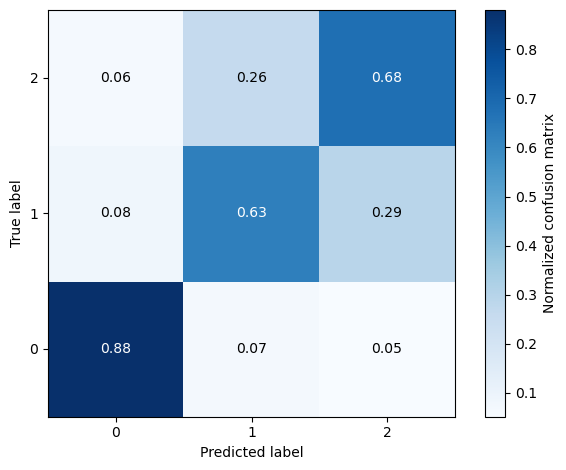

Epoch 134/200 - Learning Rate: 0.000080


Train Loss: 0.688798 | Val Loss: 0.606836 | Val Acc: 0.864 | Balanced Acc: 0.707
Epoch 134/200 took 250.64 seconds


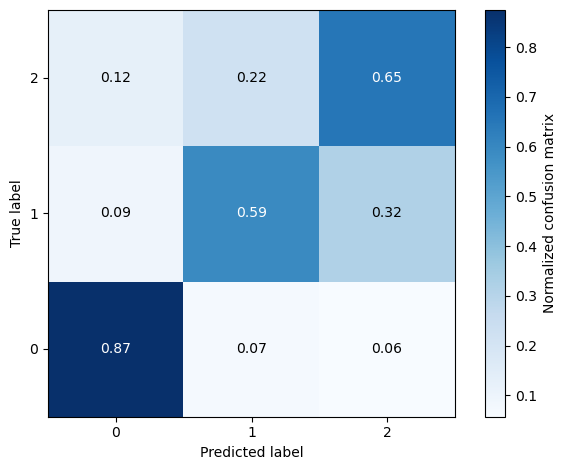

Epoch 135/200 - Learning Rate: 0.000080


Train Loss: 0.686778 | Val Loss: 0.608814 | Val Acc: 0.878 | Balanced Acc: 0.707
Epoch 135/200 took 250.46 seconds


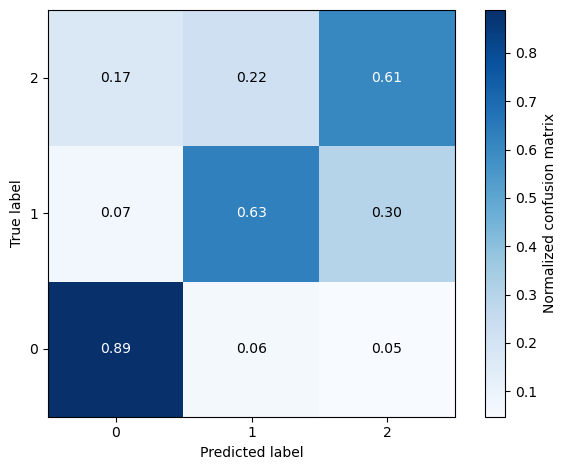

Epoch 136/200 - Learning Rate: 0.000080


Train Loss: 0.689445 | Val Loss: 0.601533 | Val Acc: 0.862 | Balanced Acc: 0.720
Epoch 136/200 took 249.57 seconds


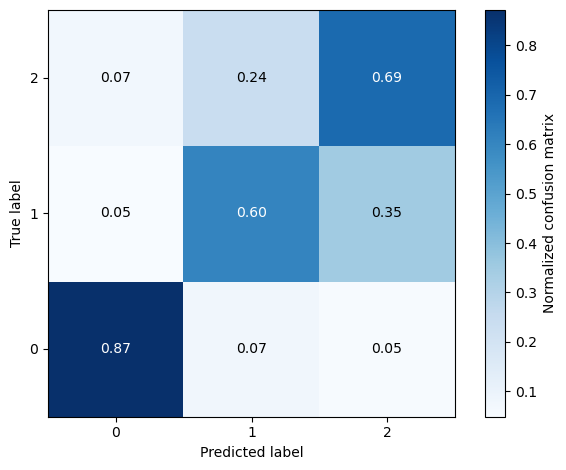

Epoch 137/200 - Learning Rate: 0.000080


Train Loss: 0.688844 | Val Loss: 0.609048 | Val Acc: 0.863 | Balanced Acc: 0.711
Epoch 137/200 took 249.46 seconds


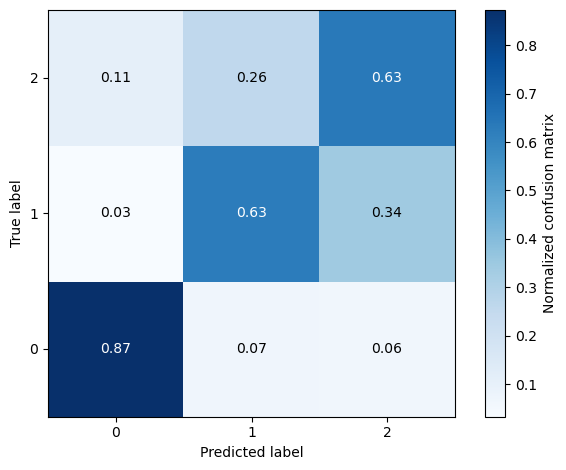

Epoch 138/200 - Learning Rate: 0.000080


Train Loss: 0.686205 | Val Loss: 0.601279 | Val Acc: 0.880 | Balanced Acc: 0.715
Epoch 138/200 took 249.24 seconds


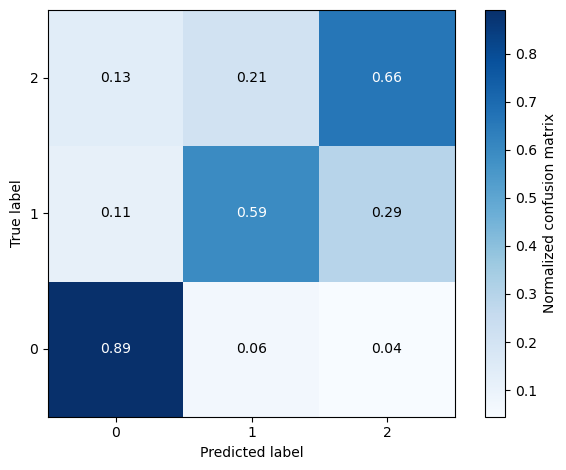

Epoch 139/200 - Learning Rate: 0.000080


Train Loss: 0.687980 | Val Loss: 0.604427 | Val Acc: 0.871 | Balanced Acc: 0.723
Epoch 139/200 took 249.67 seconds


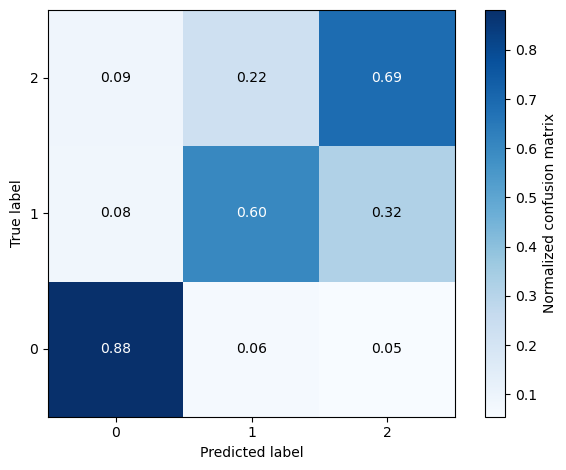

Epoch 140/200 - Learning Rate: 0.000080


Train Loss: 0.685612 | Val Loss: 0.589443 | Val Acc: 0.865 | Balanced Acc: 0.727
Epoch 140/200 took 249.72 seconds


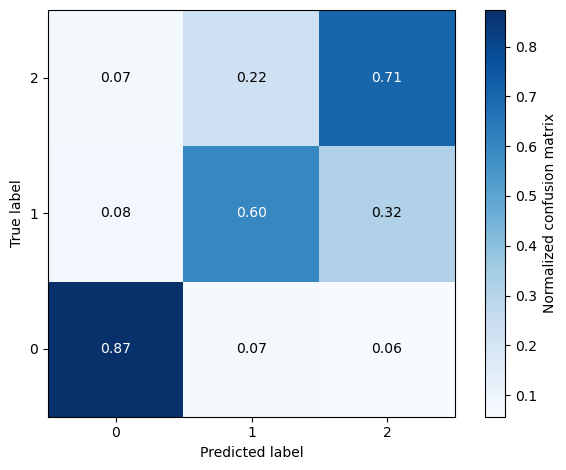

Epoch 141/200 - Learning Rate: 0.000080


Train Loss: 0.690416 | Val Loss: 0.599139 | Val Acc: 0.872 | Balanced Acc: 0.730
Epoch 141/200 took 250.29 seconds


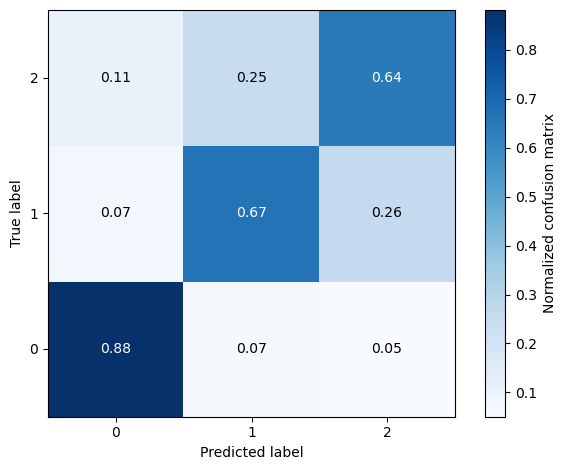

Epoch 142/200 - Learning Rate: 0.000080


Train Loss: 0.683279 | Val Loss: 0.596431 | Val Acc: 0.865 | Balanced Acc: 0.720
Epoch 142/200 took 250.33 seconds


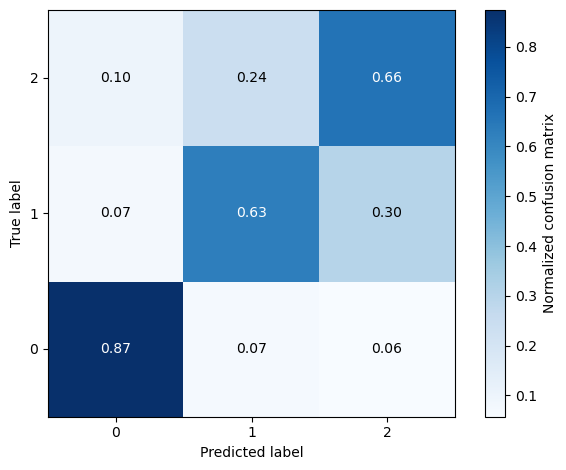

Epoch 143/200 - Learning Rate: 0.000080


Train Loss: 0.678570 | Val Loss: 0.597543 | Val Acc: 0.870 | Balanced Acc: 0.710
Epoch 143/200 took 249.71 seconds


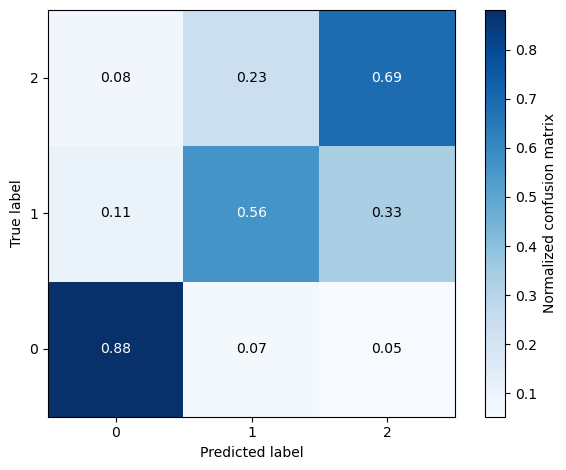

Epoch 144/200 - Learning Rate: 0.000080


Train Loss: 0.682819 | Val Loss: 0.601177 | Val Acc: 0.862 | Balanced Acc: 0.730
Epoch 144/200 took 249.79 seconds


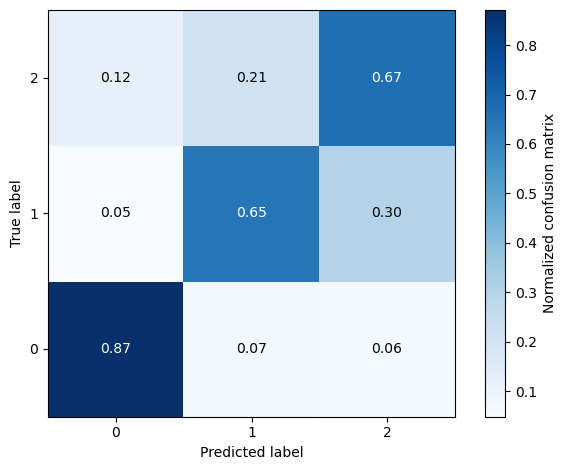

Epoch 145/200 - Learning Rate: 0.000080


Train Loss: 0.680881 | Val Loss: 0.586672 | Val Acc: 0.872 | Balanced Acc: 0.715
Epoch 145/200 took 252.19 seconds


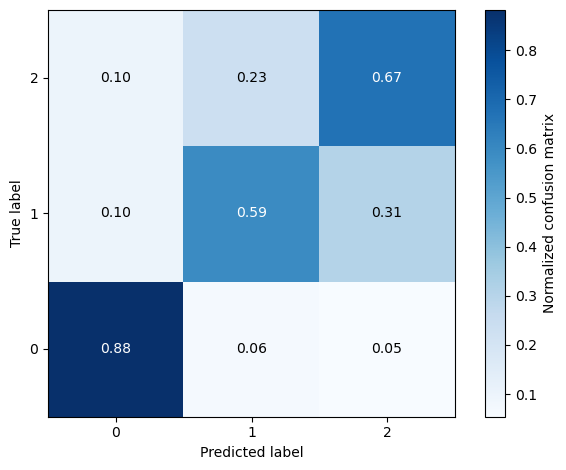

Epoch 146/200 - Learning Rate: 0.000080


Train Loss: 0.682001 | Val Loss: 0.586405 | Val Acc: 0.863 | Balanced Acc: 0.734
Epoch 146/200 took 250.85 seconds


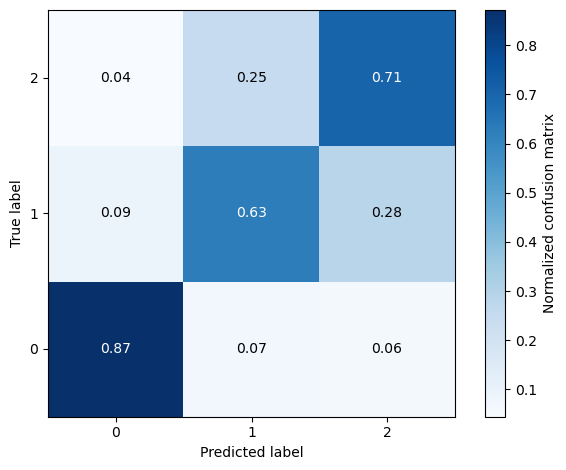

Epoch 147/200 - Learning Rate: 0.000080


Train Loss: 0.677197 | Val Loss: 0.587630 | Val Acc: 0.878 | Balanced Acc: 0.715
Epoch 147/200 took 249.99 seconds


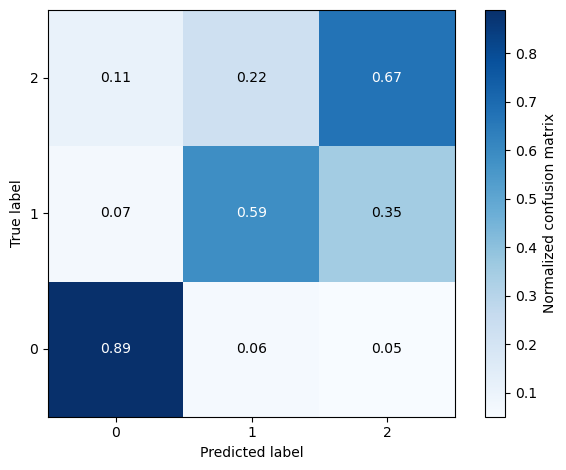

Epoch 148/200 - Learning Rate: 0.000080


Train Loss: 0.678292 | Val Loss: 0.596022 | Val Acc: 0.867 | Balanced Acc: 0.714
Epoch 148/200 took 250.32 seconds


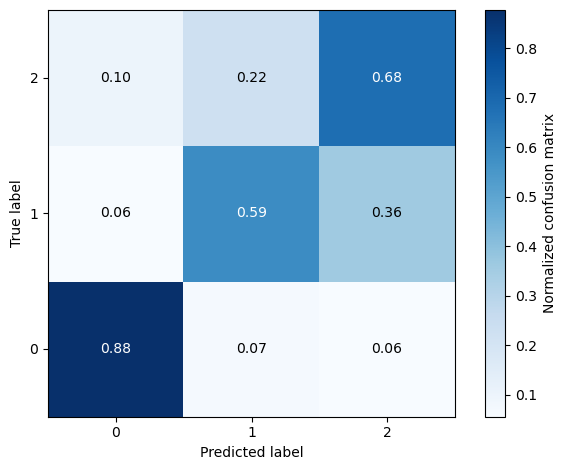

Epoch 149/200 - Learning Rate: 0.000080


Train Loss: 0.690663 | Val Loss: 0.584634 | Val Acc: 0.872 | Balanced Acc: 0.734
Epoch 149/200 took 249.89 seconds


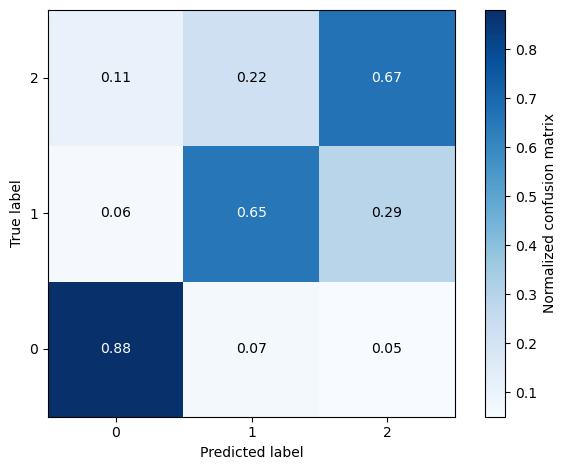

Epoch 150/200 - Learning Rate: 0.000080


Train Loss: 0.681256 | Val Loss: 0.598294 | Val Acc: 0.866 | Balanced Acc: 0.718
Epoch 150/200 took 249.91 seconds


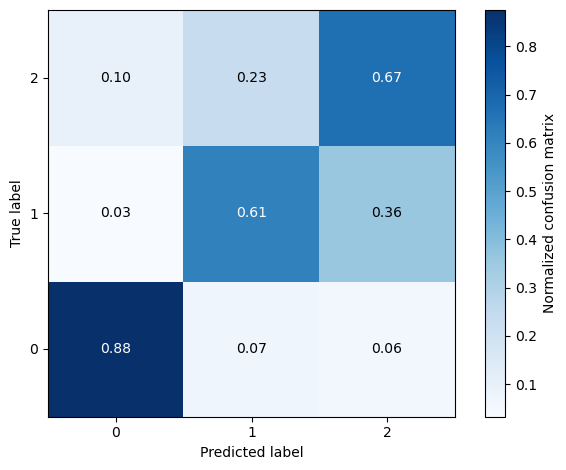

Epoch 151/200 - Learning Rate: 0.000080


Train Loss: 0.681456 | Val Loss: 0.581996 | Val Acc: 0.869 | Balanced Acc: 0.723
Epoch 151/200 took 250.17 seconds


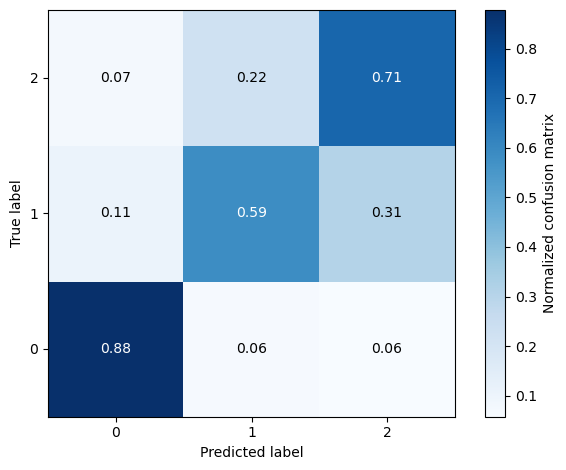

Epoch 152/200 - Learning Rate: 0.000080


Train Loss: 0.675454 | Val Loss: 0.598818 | Val Acc: 0.863 | Balanced Acc: 0.720
Epoch 152/200 took 250.43 seconds


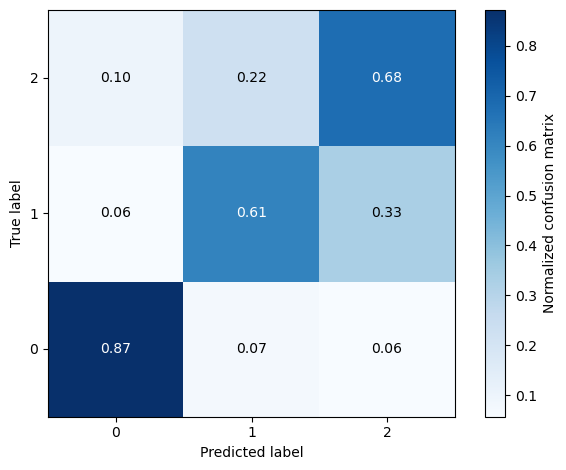

Epoch 153/200 - Learning Rate: 0.000080


Train Loss: 0.673742 | Val Loss: 0.601867 | Val Acc: 0.857 | Balanced Acc: 0.718
Epoch 153/200 took 250.34 seconds


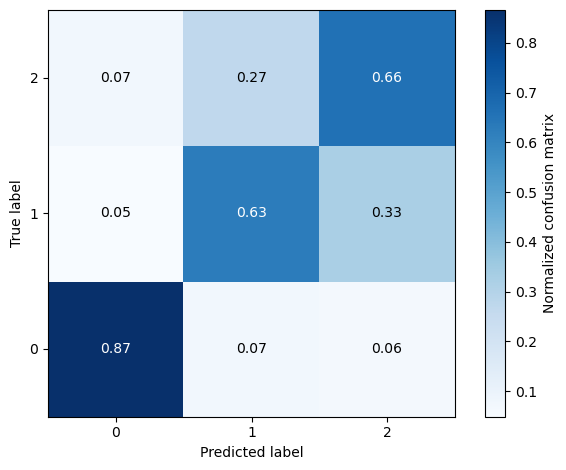

Epoch 154/200 - Learning Rate: 0.000080


Train Loss: 0.679961 | Val Loss: 0.580012 | Val Acc: 0.874 | Balanced Acc: 0.730
Epoch 154/200 took 251.21 seconds


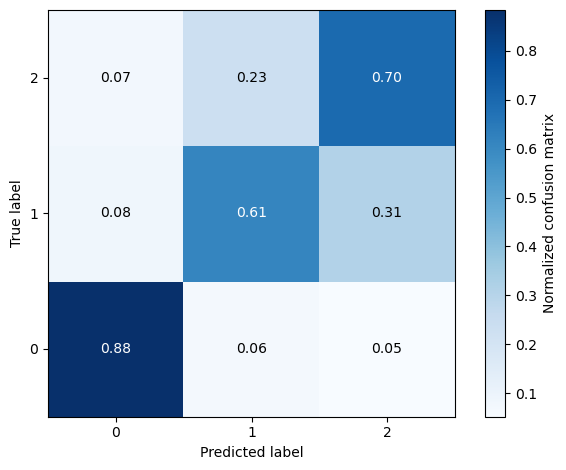

Epoch 155/200 - Learning Rate: 0.000080


Train Loss: 0.682792 | Val Loss: 0.595952 | Val Acc: 0.871 | Balanced Acc: 0.722
Epoch 155/200 took 250.16 seconds


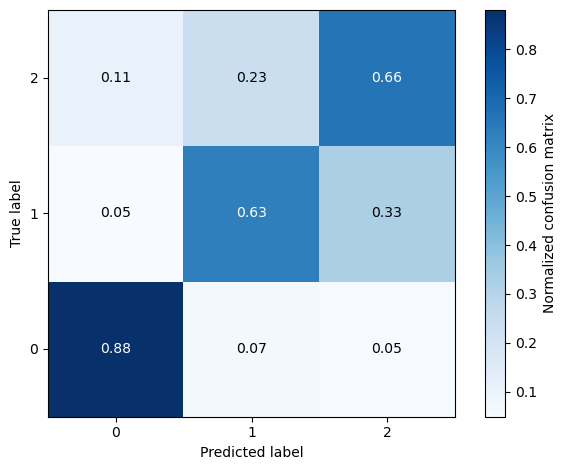

Epoch 156/200 - Learning Rate: 0.000080


Train Loss: 0.676770 | Val Loss: 0.564650 | Val Acc: 0.892 | Balanced Acc: 0.719
Epoch 156/200 took 250.41 seconds


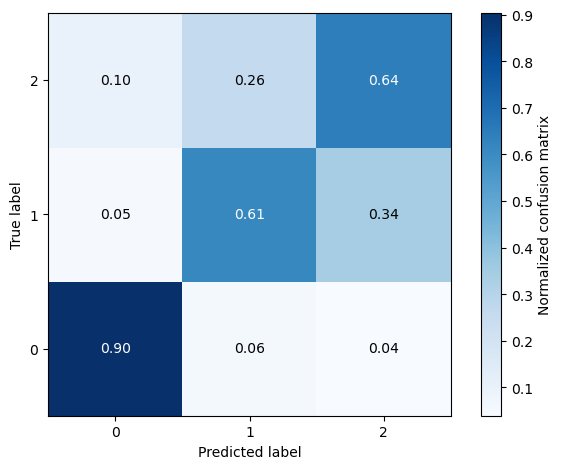

Epoch 157/200 - Learning Rate: 0.000080


Train Loss: 0.673259 | Val Loss: 0.623458 | Val Acc: 0.856 | Balanced Acc: 0.695
Epoch 157/200 took 250.31 seconds


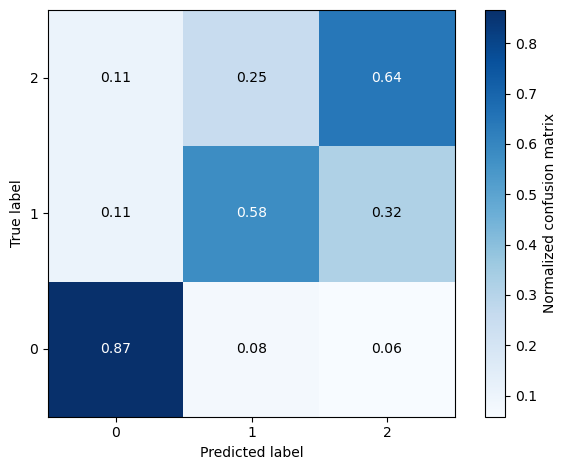

Epoch 158/200 - Learning Rate: 0.000080


Train Loss: 0.674927 | Val Loss: 0.578727 | Val Acc: 0.885 | Balanced Acc: 0.721
Epoch 158/200 took 250.00 seconds


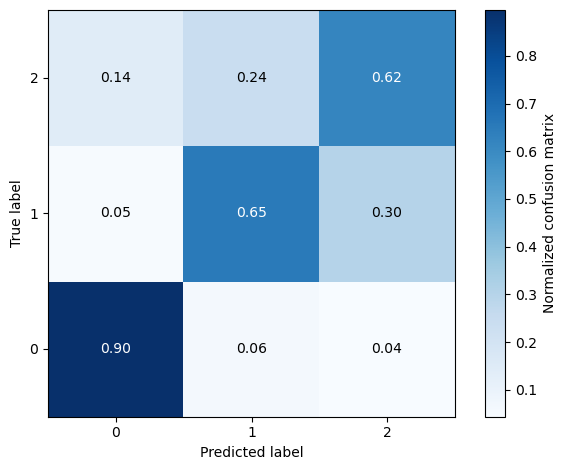

Epoch 159/200 - Learning Rate: 0.000080


Train Loss: 0.678814 | Val Loss: 0.594307 | Val Acc: 0.882 | Balanced Acc: 0.714
Epoch 159/200 took 250.04 seconds


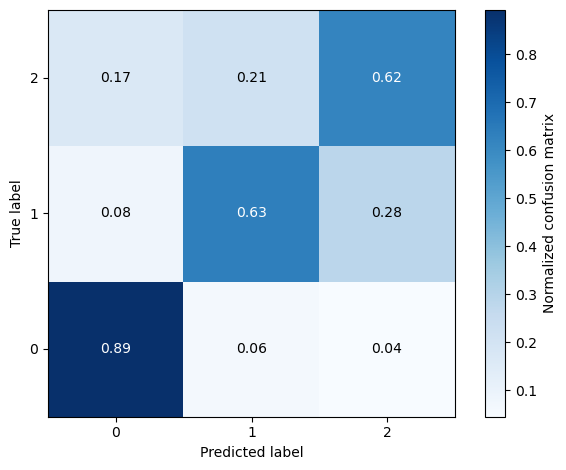

Epoch 160/200 - Learning Rate: 0.000080


Train Loss: 0.673394 | Val Loss: 0.583869 | Val Acc: 0.868 | Balanced Acc: 0.712
Epoch 160/200 took 250.71 seconds


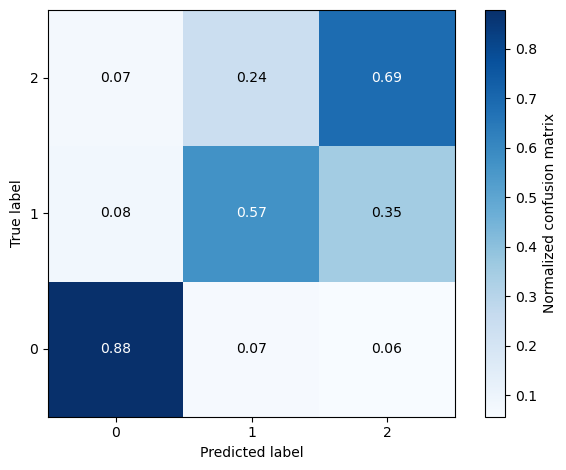

Epoch 161/200 - Learning Rate: 0.000080


Train Loss: 0.675584 | Val Loss: 0.597313 | Val Acc: 0.871 | Balanced Acc: 0.728
Epoch 161/200 took 249.80 seconds


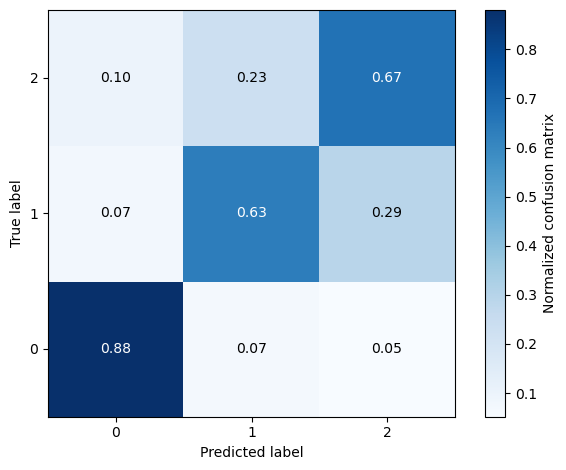

Epoch 162/200 - Learning Rate: 0.000080


Train Loss: 0.679377 | Val Loss: 0.594921 | Val Acc: 0.860 | Balanced Acc: 0.710
Epoch 162/200 took 250.14 seconds


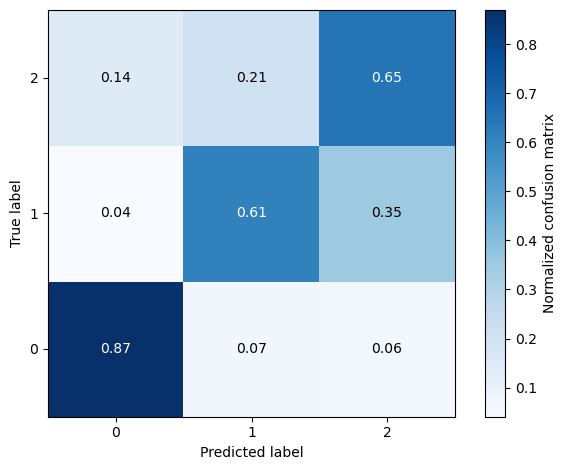

Epoch 163/200 - Learning Rate: 0.000080


Train Loss: 0.675919 | Val Loss: 0.591203 | Val Acc: 0.879 | Balanced Acc: 0.706
Epoch 163/200 took 249.75 seconds


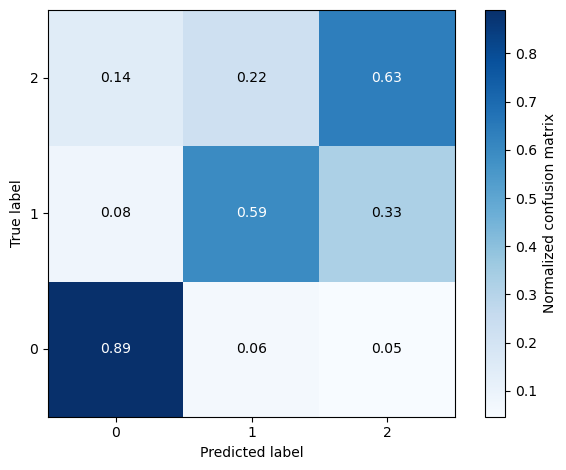

Epoch 164/200 - Learning Rate: 0.000080


Train Loss: 0.666605 | Val Loss: 0.581818 | Val Acc: 0.871 | Balanced Acc: 0.709
Epoch 164/200 took 249.93 seconds


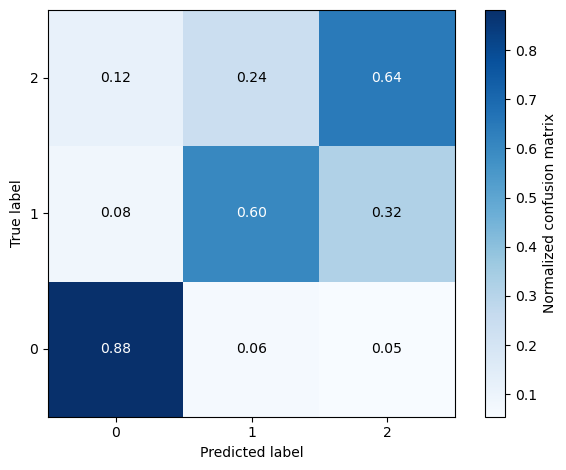

Epoch 165/200 - Learning Rate: 0.000080


Train Loss: 0.673375 | Val Loss: 0.585148 | Val Acc: 0.869 | Balanced Acc: 0.728
Epoch 165/200 took 249.84 seconds


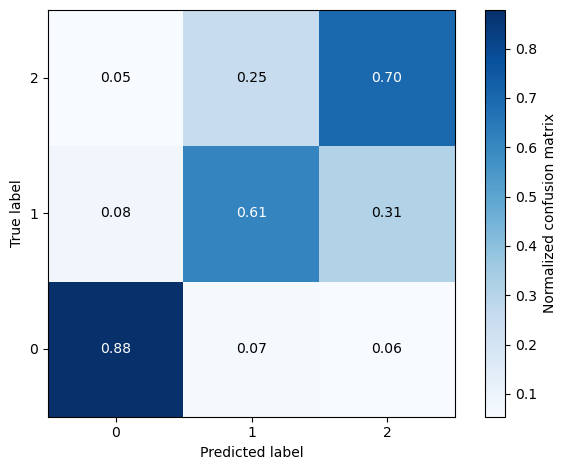

Epoch 166/200 - Learning Rate: 0.000080


Train Loss: 0.676362 | Val Loss: 0.577645 | Val Acc: 0.870 | Balanced Acc: 0.732
Epoch 166/200 took 250.04 seconds


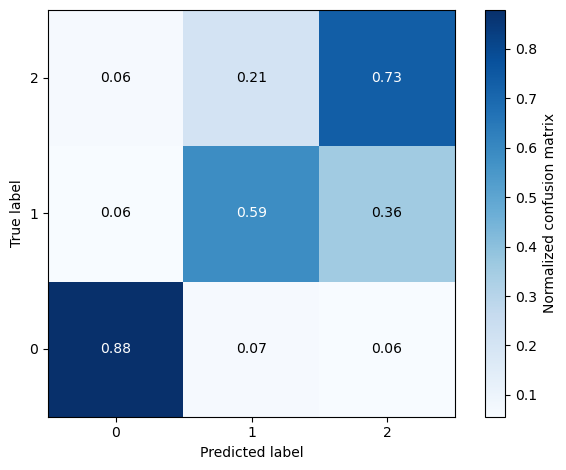

Epoch 167/200 - Learning Rate: 0.000080


Train Loss: 0.673129 | Val Loss: 0.577433 | Val Acc: 0.877 | Balanced Acc: 0.725
Epoch 167/200 took 249.68 seconds


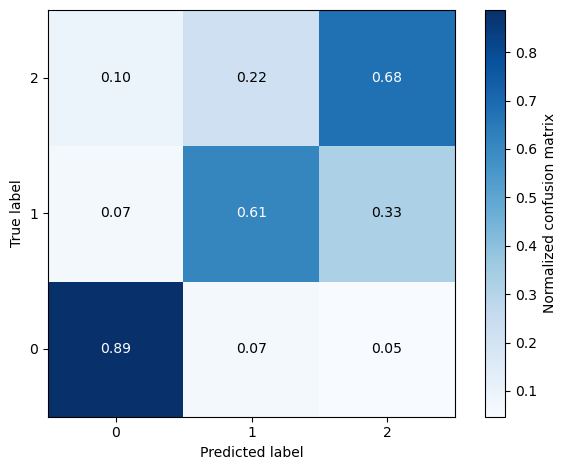

Epoch 168/200 - Learning Rate: 0.000080


Train Loss: 0.670925 | Val Loss: 0.584341 | Val Acc: 0.882 | Balanced Acc: 0.708
Epoch 168/200 took 251.03 seconds


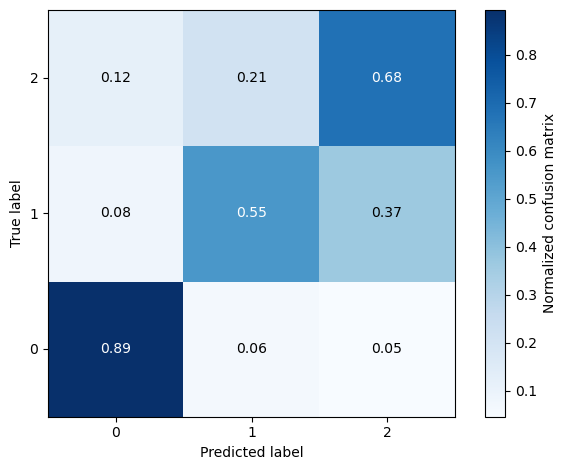

Epoch 169/200 - Learning Rate: 0.000080


Train Loss: 0.676050 | Val Loss: 0.574845 | Val Acc: 0.866 | Balanced Acc: 0.724
Epoch 169/200 took 252.63 seconds


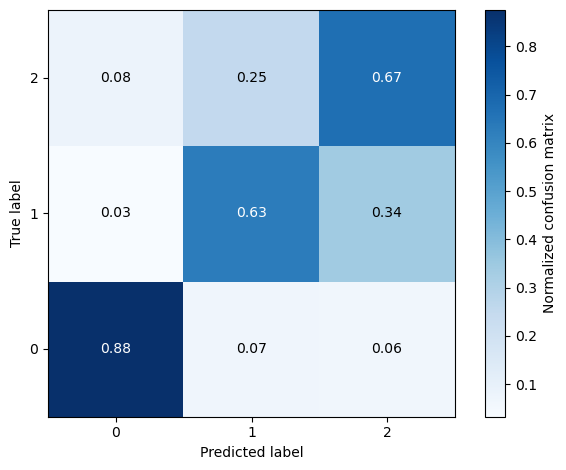

Epoch 170/200 - Learning Rate: 0.000080


Train Loss: 0.677986 | Val Loss: 0.576649 | Val Acc: 0.881 | Balanced Acc: 0.719
Epoch 170/200 took 252.06 seconds


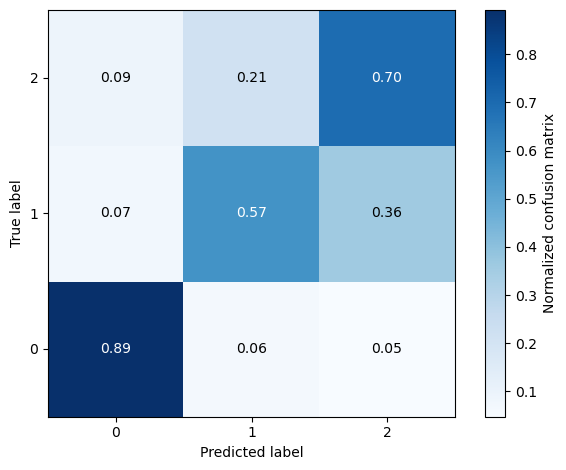

Epoch 171/200 - Learning Rate: 0.000080


Train Loss: 0.669377 | Val Loss: 0.580710 | Val Acc: 0.873 | Balanced Acc: 0.701
Epoch 171/200 took 253.58 seconds


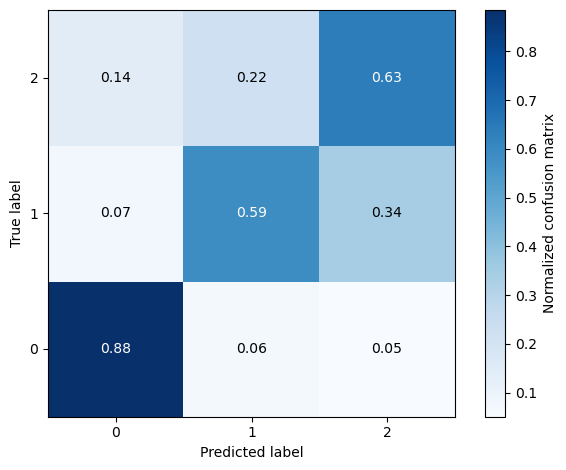

Epoch 172/200 - Learning Rate: 0.000080


Train Loss: 0.672052 | Val Loss: 0.589998 | Val Acc: 0.868 | Balanced Acc: 0.708
Epoch 172/200 took 251.35 seconds


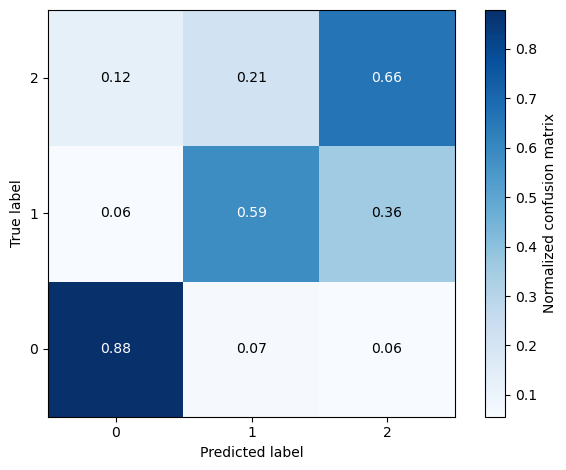

Epoch 173/200 - Learning Rate: 0.000080


Train Loss: 0.670581 | Val Loss: 0.589972 | Val Acc: 0.871 | Balanced Acc: 0.709
Epoch 173/200 took 254.33 seconds


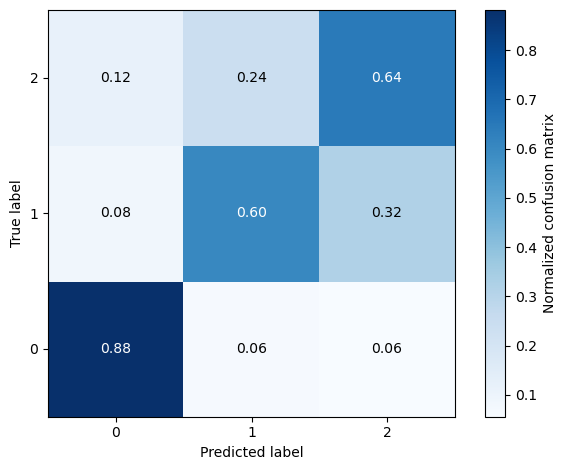

Epoch 174/200 - Learning Rate: 0.000080


Train Loss: 0.665097 | Val Loss: 0.582260 | Val Acc: 0.882 | Balanced Acc: 0.721
Epoch 174/200 took 253.84 seconds


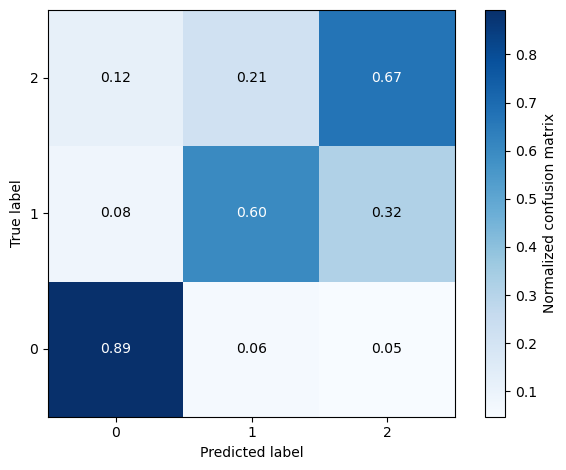

Epoch 175/200 - Learning Rate: 0.000080


Train Loss: 0.671732 | Val Loss: 0.571674 | Val Acc: 0.877 | Balanced Acc: 0.728
Epoch 175/200 took 252.05 seconds


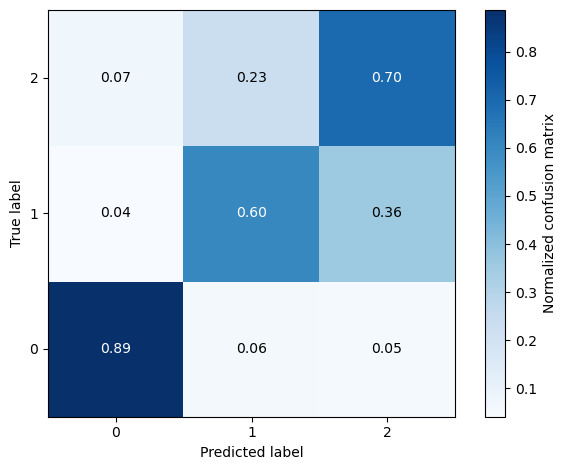

Epoch 176/200 - Learning Rate: 0.000080


Train Loss: 0.673102 | Val Loss: 0.576480 | Val Acc: 0.868 | Balanced Acc: 0.725
Epoch 176/200 took 253.31 seconds


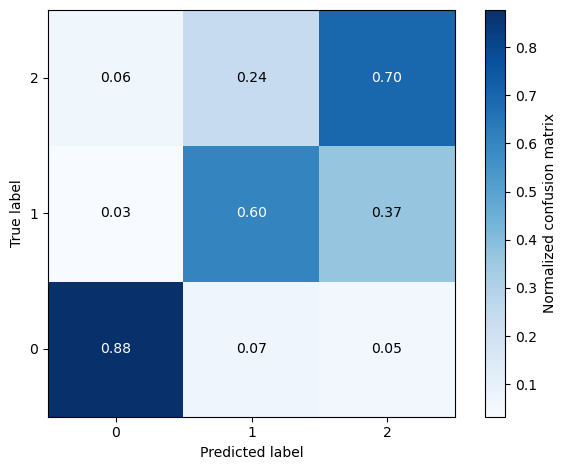

Epoch 177/200 - Learning Rate: 0.000080


Train Loss: 0.667900 | Val Loss: 0.581269 | Val Acc: 0.882 | Balanced Acc: 0.710
Epoch 177/200 took 251.41 seconds


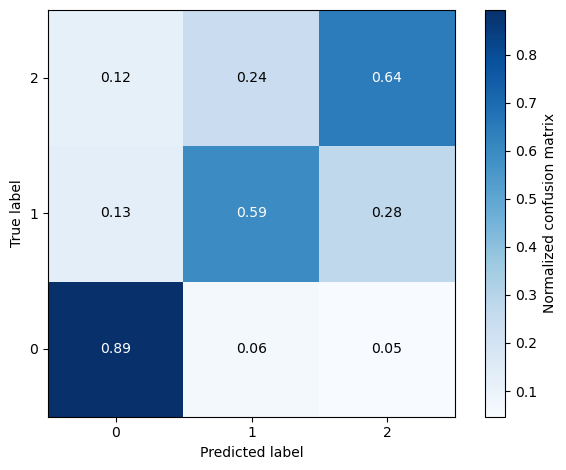

Epoch 178/200 - Learning Rate: 0.000080


Train Loss: 0.666891 | Val Loss: 0.580398 | Val Acc: 0.874 | Balanced Acc: 0.727
Epoch 178/200 took 251.08 seconds


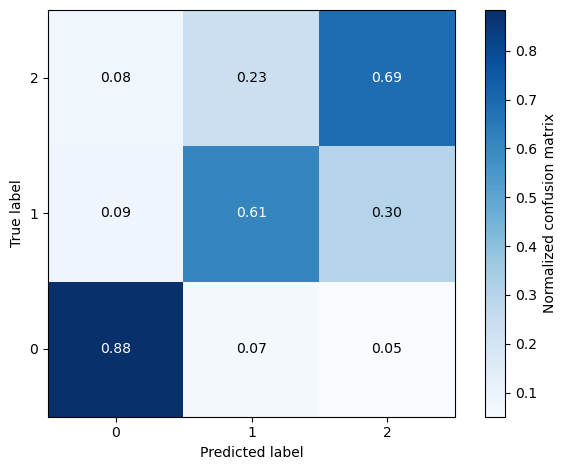

Epoch 179/200 - Learning Rate: 0.000080


Train Loss: 0.665073 | Val Loss: 0.577063 | Val Acc: 0.877 | Balanced Acc: 0.712
Epoch 179/200 took 254.55 seconds


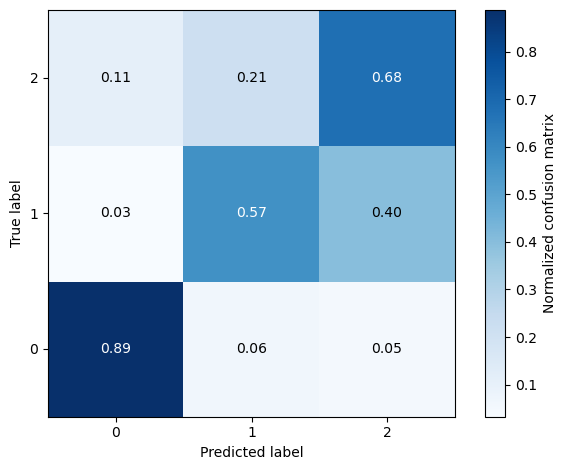

Epoch 180/200 - Learning Rate: 0.000080


Train Loss: 0.666641 | Val Loss: 0.588643 | Val Acc: 0.868 | Balanced Acc: 0.714
Epoch 180/200 took 253.63 seconds


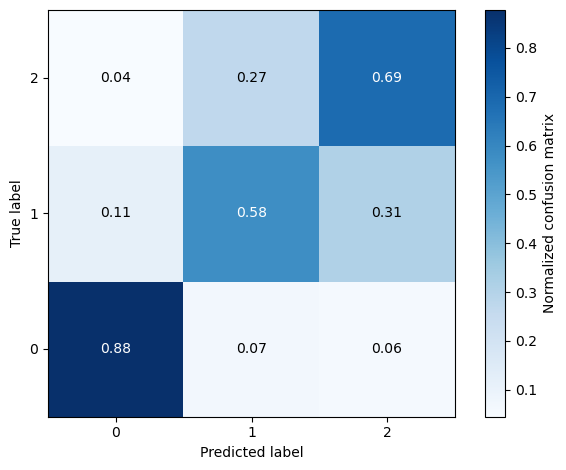

Epoch 181/200 - Learning Rate: 0.000080


Train Loss: 0.664968 | Val Loss: 0.581980 | Val Acc: 0.876 | Balanced Acc: 0.728
Epoch 181/200 took 253.35 seconds


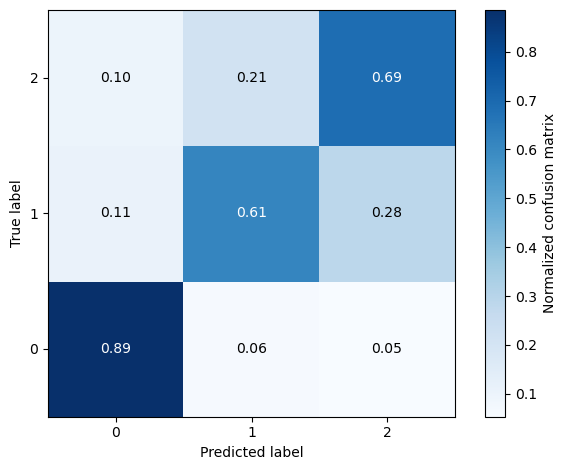

Epoch 182/200 - Learning Rate: 0.000080


Train Loss: 0.665950 | Val Loss: 0.576158 | Val Acc: 0.865 | Balanced Acc: 0.733
Epoch 182/200 took 254.84 seconds


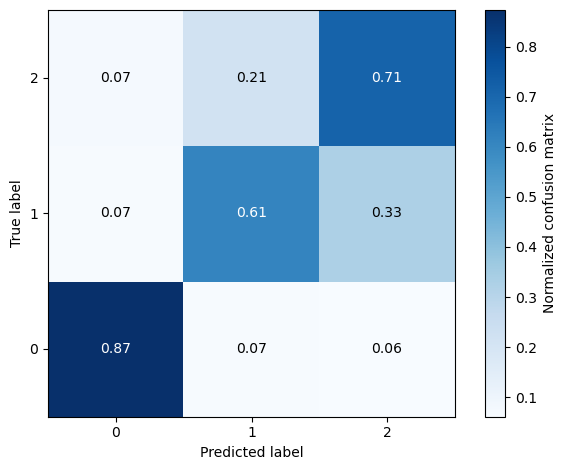

Epoch 183/200 - Learning Rate: 0.000080


Train Loss: 0.668231 | Val Loss: 0.580836 | Val Acc: 0.874 | Balanced Acc: 0.727
Epoch 183/200 took 254.29 seconds


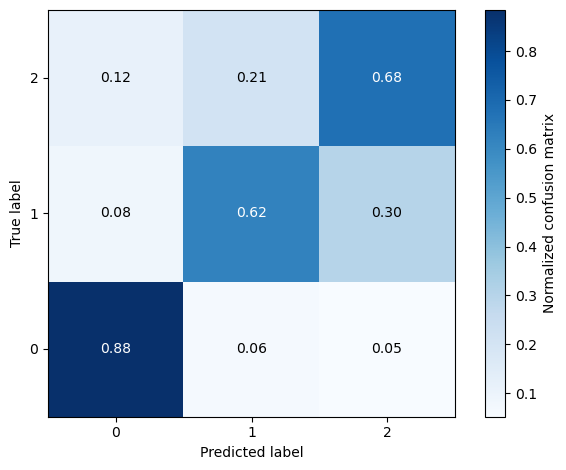

Epoch 184/200 - Learning Rate: 0.000080


Train Loss: 0.665002 | Val Loss: 0.572714 | Val Acc: 0.890 | Balanced Acc: 0.732
Epoch 184/200 took 253.54 seconds


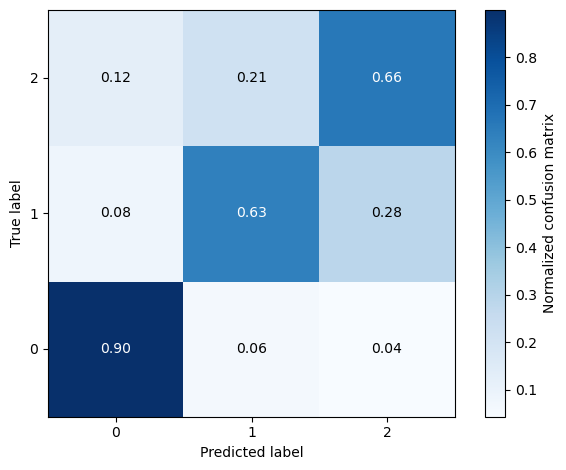

Epoch 185/200 - Learning Rate: 0.000080


Train Loss: 0.663648 | Val Loss: 0.584013 | Val Acc: 0.873 | Balanced Acc: 0.717
Epoch 185/200 took 254.48 seconds


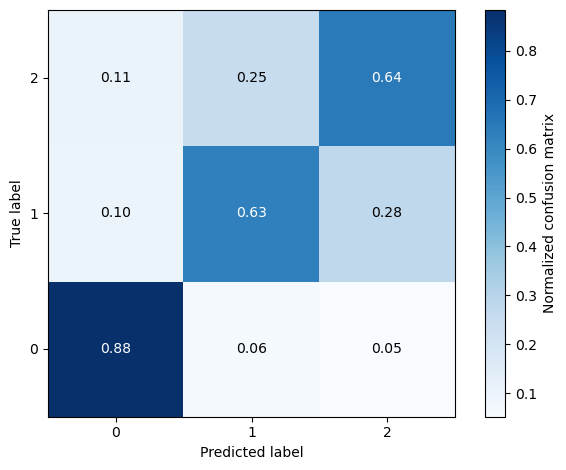

Epoch 186/200 - Learning Rate: 0.000080


Train Loss: 0.665075 | Val Loss: 0.566958 | Val Acc: 0.878 | Balanced Acc: 0.722
Epoch 186/200 took 252.90 seconds


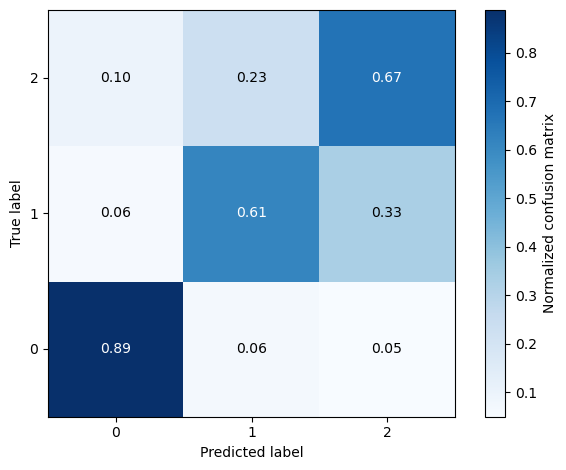

Epoch 187/200 - Learning Rate: 0.000080


Train Loss: 0.656752 | Val Loss: 0.569762 | Val Acc: 0.889 | Balanced Acc: 0.722
Epoch 187/200 took 251.29 seconds


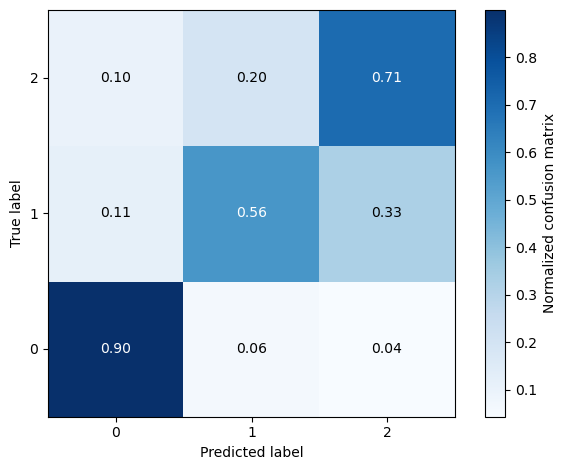

Epoch 188/200 - Learning Rate: 0.000080


Train Loss: 0.665410 | Val Loss: 0.598991 | Val Acc: 0.882 | Balanced Acc: 0.676
Epoch 188/200 took 253.51 seconds


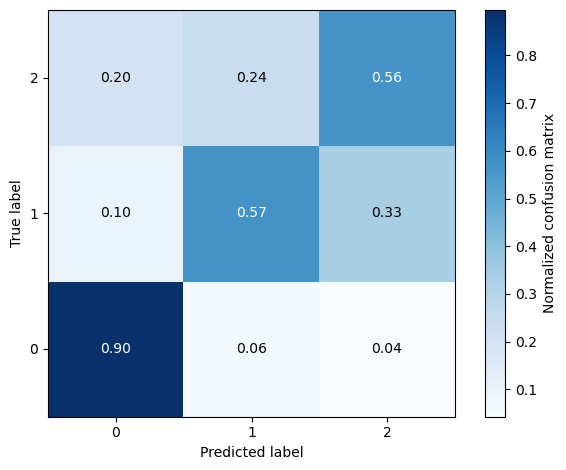

Epoch 189/200 - Learning Rate: 0.000080


Train Loss: 0.660410 | Val Loss: 0.568339 | Val Acc: 0.871 | Balanced Acc: 0.728
Epoch 189/200 took 253.09 seconds


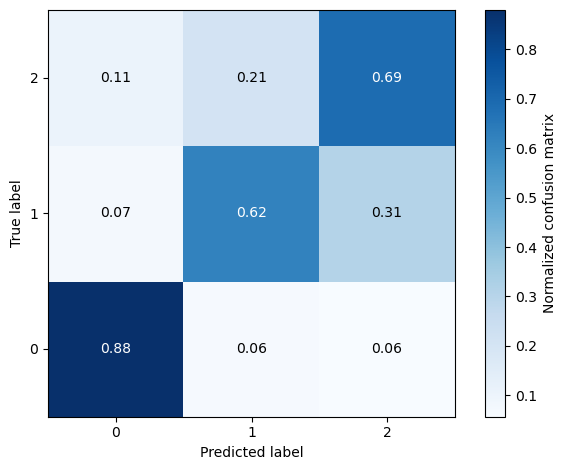

Epoch 190/200 - Learning Rate: 0.000080


Train Loss: 0.662444 | Val Loss: 0.570268 | Val Acc: 0.875 | Balanced Acc: 0.704
Epoch 190/200 took 253.02 seconds


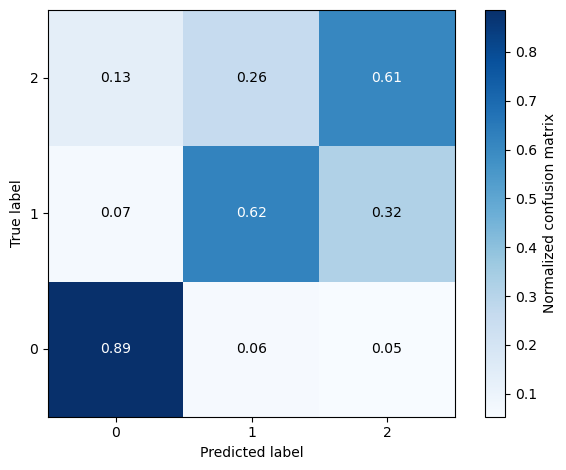

Epoch 191/200 - Learning Rate: 0.000080


Train Loss: 0.661369 | Val Loss: 0.557495 | Val Acc: 0.893 | Balanced Acc: 0.742
Epoch 191/200 took 253.78 seconds


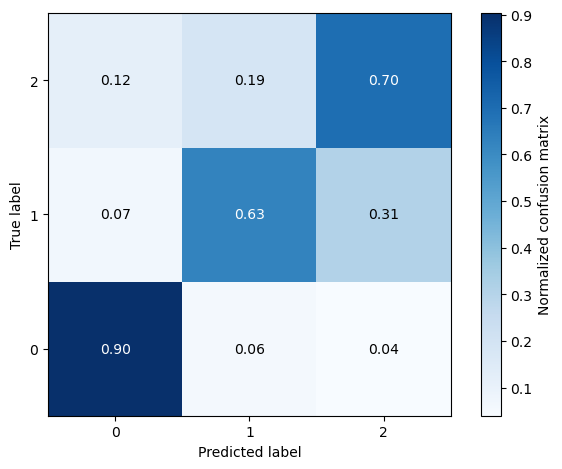

Epoch 192/200 - Learning Rate: 0.000080


Train Loss: 0.666727 | Val Loss: 0.561868 | Val Acc: 0.889 | Balanced Acc: 0.712
Epoch 192/200 took 253.50 seconds


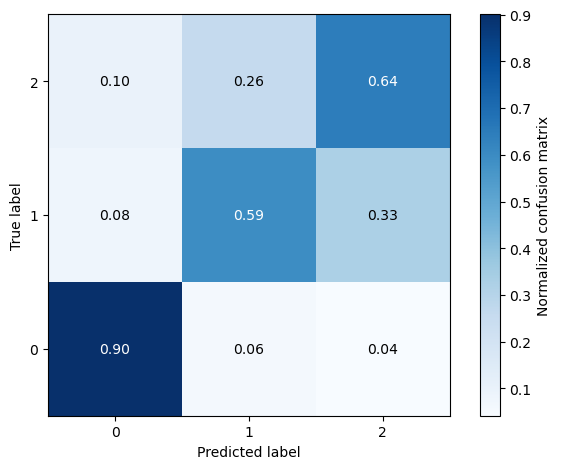

Epoch 193/200 - Learning Rate: 0.000080


Train Loss: 0.660267 | Val Loss: 0.574479 | Val Acc: 0.883 | Balanced Acc: 0.711
Epoch 193/200 took 254.27 seconds


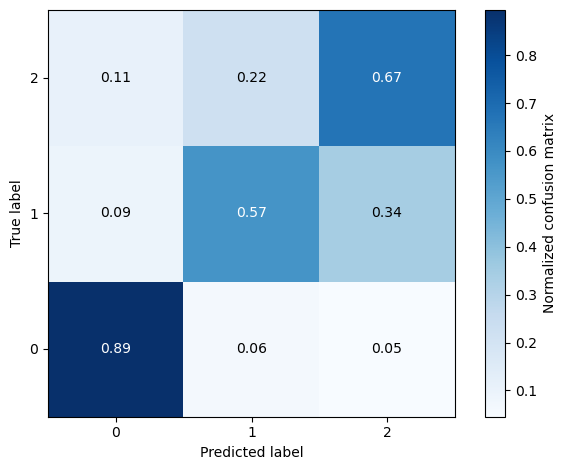

Epoch 194/200 - Learning Rate: 0.000080


Train Loss: 0.661163 | Val Loss: 0.580702 | Val Acc: 0.869 | Balanced Acc: 0.712
Epoch 194/200 took 254.29 seconds


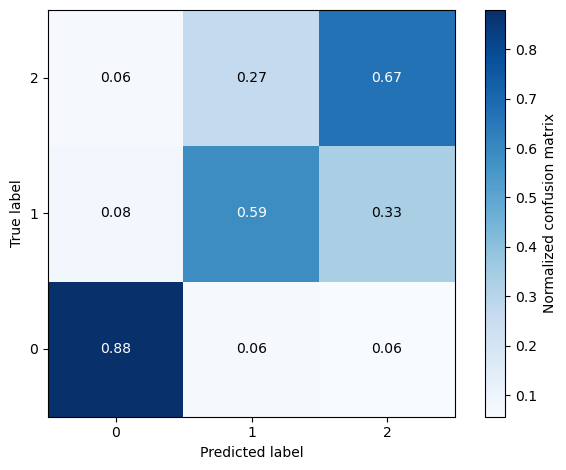

Epoch 195/200 - Learning Rate: 0.000080


Train Loss: 0.658320 | Val Loss: 0.568107 | Val Acc: 0.878 | Balanced Acc: 0.723
Epoch 195/200 took 253.38 seconds


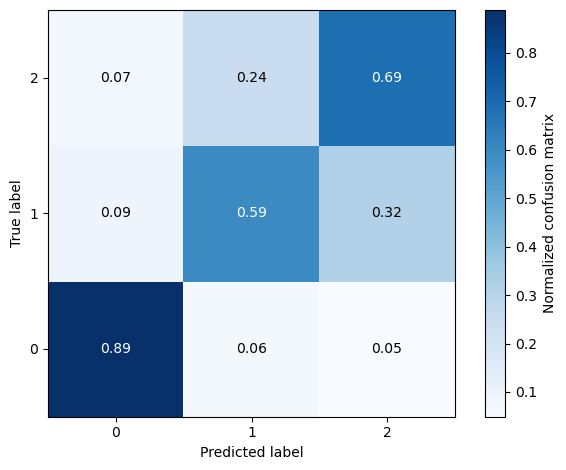

Epoch 196/200 - Learning Rate: 0.000080


Train Loss: 0.657112 | Val Loss: 0.560780 | Val Acc: 0.885 | Balanced Acc: 0.722
Epoch 196/200 took 254.85 seconds


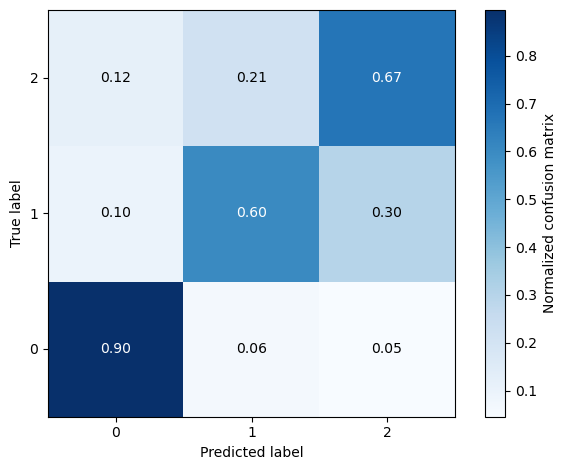

Epoch 197/200 - Learning Rate: 0.000080


Train Loss: 0.660979 | Val Loss: 0.585778 | Val Acc: 0.869 | Balanced Acc: 0.706
Epoch 197/200 took 253.81 seconds


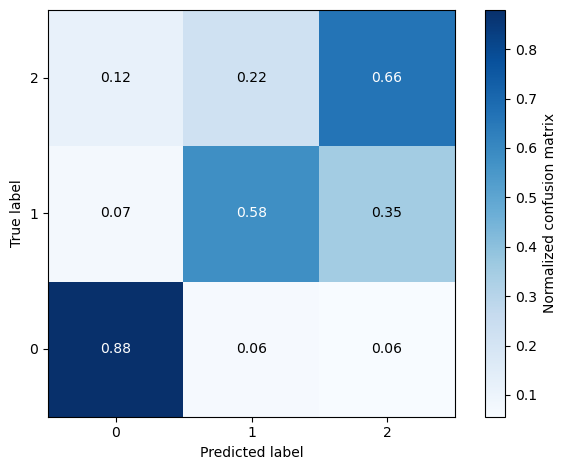

Epoch 198/200 - Learning Rate: 0.000080


Train Loss: 0.659001 | Val Loss: 0.591013 | Val Acc: 0.871 | Balanced Acc: 0.725
Epoch 198/200 took 253.89 seconds


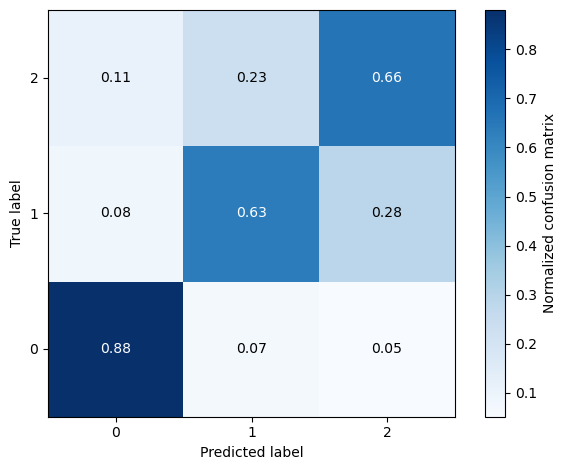

Epoch 199/200 - Learning Rate: 0.000080


Train Loss: 0.664194 | Val Loss: 0.578784 | Val Acc: 0.873 | Balanced Acc: 0.716
Epoch 199/200 took 253.04 seconds


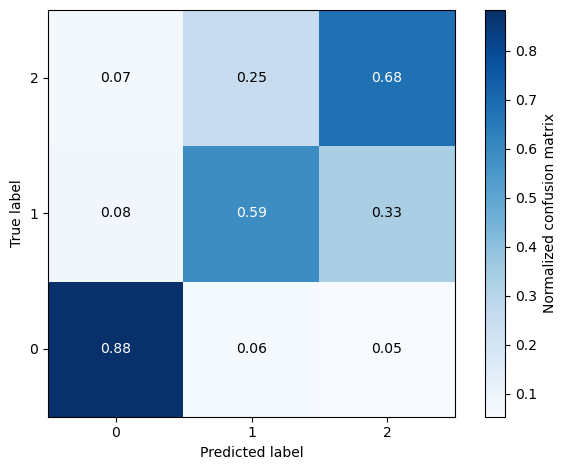

Epoch 200/200 - Learning Rate: 0.000080


Train Loss: 0.658120 | Val Loss: 0.576348 | Val Acc: 0.874 | Balanced Acc: 0.715
Epoch 200/200 took 253.73 seconds


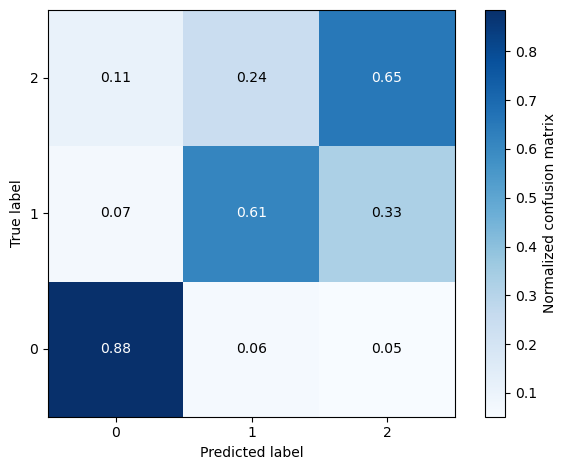

In [27]:
swin_multi_train_losses = []
swin_multi_val_losses = []

best_val_loss = np.inf
best_bal_acc = 0.5
best_combined_acc = 1

for epoch in range(epochs):
    start_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {current_lr:.6f}")

    train_loss = AF.training_epoch(swin_multi, swin_multi_train_loader, optimizer, criterion, device, scheduler = None, unsqueezeY = False)
    val_loss, val_acc, all_preds, all_labels, bal_acc = AF.nonbinary_multilabel_evaluate(swin_multi, swin_multi_val_loader, criterion, device, desc = 'validation')

    # Step the scheduler
    #scheduler.step()

    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Val Acc: {val_acc:.3f} | Balanced Acc: {bal_acc:.3f}")

    swin_multi_train_losses.append(train_loss)
    swin_multi_val_losses.append(val_loss)
    
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs} took {epoch_time:.2f} seconds")

    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     torch.save(swin_multi.state_dict(), "swin_nonbinary_best_model.pth")

    if bal_acc > 0.49 or (bal_acc + val_acc) > 1:
        af.plot_confusion_matrix(all_labels, all_preds, classes=None, normalize=True, title=None, cmap=plt.cm.Blues)
        plt.show()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(swin_multi.state_dict(), "zoobot_nonbinary_best_model_val_loss.pth")
    
    if bal_acc > best_bal_acc:
        best_bal_acc = bal_acc
        torch.save(swin_multi.state_dict(), "zoobot_nonbinary_best_model_bal_acc.pth")

    if bal_acc + val_acc > best_combined_acc:
        best_combined_acc = bal_acc + val_acc
        torch.save(swin_multi.state_dict(), "zoobot_nonbinary_best_model_combined_acc.pth")

swin_multi_epoch_loss, swin_multi_epoch_acc, swin_multi_all_preds, swin_multi_all_labels, swin_multi_bal_acc = AF.nonbinary_multilabel_evaluate(swin_multi, swin_multi_test_loader,
                                                                                                                  criterion, device)

In [28]:
print(best_bal_acc, best_combined_acc)

0.7418556813005367 1.6351775991087558


Text(0, 0.5, 'Loss')

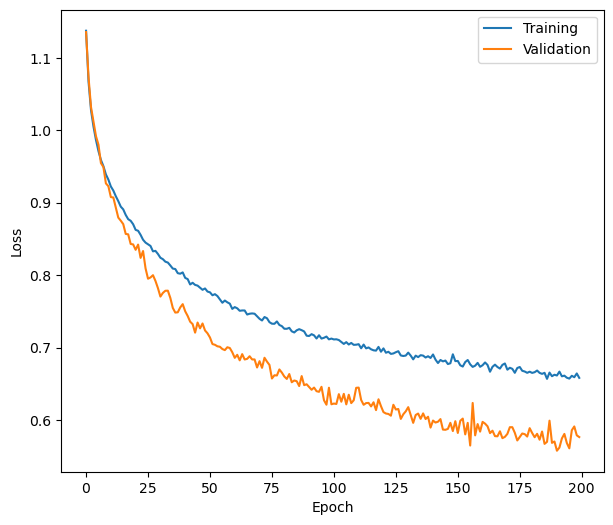

In [29]:
if epoch+1 == epochs:
    ep = epochs
else:
    ep = epoch
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(np.arange(ep), swin_multi_train_losses, label="Training")
ax.plot(np.arange(ep), swin_multi_val_losses, label="Validation")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

In [44]:
#torch.save(swin_multi.state_dict(), "zoobot_nonbinary_final_epoch_model.pth")

0.8727957541516863
0.7207318835298073


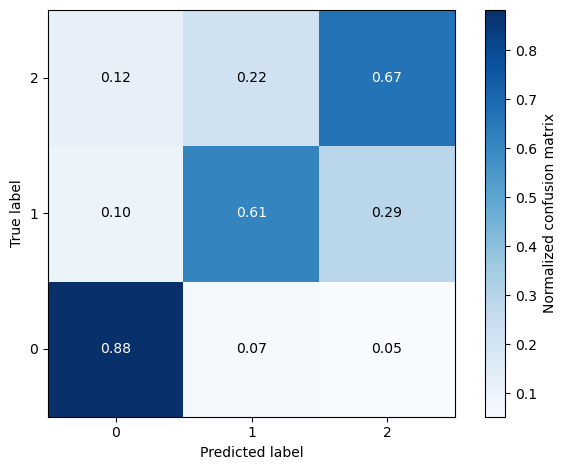

In [47]:
swin_multi_combined_acc_model = timm.create_model('hf_hub:mwalmsley/zoobot-encoder-efficientnet_b0', pretrained=False, num_classes=3)

# Freeze all parameters first
for param in swin_multi_combined_acc_model.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in swin_multi_combined_acc_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_multi_combined_acc_model = swin_multi_combined_acc_model.to(device)

state_dict = torch.load("zoobot_nonbinary_final_epoch_model.pth", map_location=device)
swin_multi_combined_acc_model.load_state_dict(state_dict)

swin_multi_epoch_loss, swin_multi_epoch_acc, swin_multi_all_preds, swin_multi_all_labels, swin_multi_bal_acc = AF.nonbinary_multilabel_evaluate(swin_multi_combined_acc_model, swin_multi_test_loader,
                                                                                                                  criterion, device)
print(swin_multi_epoch_acc)
print(swin_multi_bal_acc)
af.plot_confusion_matrix(swin_multi_all_labels, swin_multi_all_preds, classes=None, normalize=True, title=None, cmap=plt.cm.Blues)

In [45]:
swin_multi_epoch_loss, swin_multi_epoch_acc, swin_multi_all_preds, swin_multi_all_labels, swin_multi_bal_acc = AF.nonbinary_multilabel_evaluate(swin_multi, swin_multi_test_loader,
                                                                                                                  criterion, device)

0.8733093648347886
0.7291112306188318


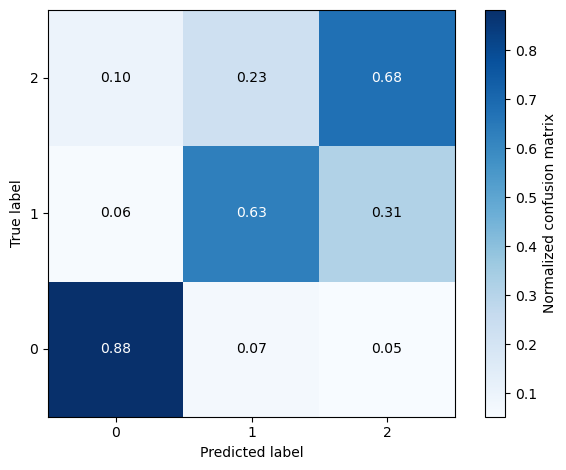

In [46]:
print(swin_multi_epoch_acc)
print(swin_multi_bal_acc)
af.plot_confusion_matrix(swin_multi_all_labels, swin_multi_all_preds, classes=None, normalize=True, title=None, cmap=plt.cm.Blues)

In [38]:
swin_multi_combined_acc_model = timm.create_model('hf_hub:mwalmsley/zoobot-encoder-efficientnet_b0', pretrained=False, num_classes=3)

# Freeze all parameters first
for param in swin_multi_combined_acc_model.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in swin_multi_combined_acc_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_multi_combined_acc_model = swin_multi_combined_acc_model.to(device)

0.8899161102550933
0.7433946582813581


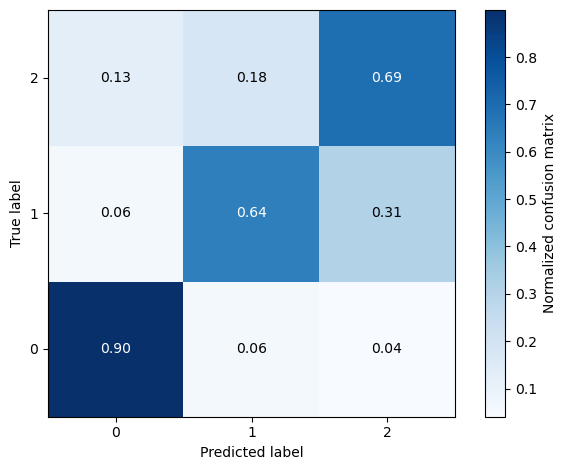

In [39]:
state_dict = torch.load("zoobot_nonbinary_best_model_combined_acc_3.pth", map_location=device)
swin_multi_combined_acc_model.load_state_dict(state_dict)

swin_multi_epoch_loss, swin_multi_epoch_acc, swin_multi_all_preds, swin_multi_all_labels, swin_multi_bal_acc = AF.nonbinary_multilabel_evaluate(swin_multi_combined_acc_model, swin_multi_test_loader,
                                                                                                                  criterion, device)
print(swin_multi_epoch_acc)
print(swin_multi_bal_acc)
af.plot_confusion_matrix(swin_multi_all_labels, swin_multi_all_preds, classes=None, normalize=True, title=None, cmap=plt.cm.Blues)

In [40]:
swin_multi_bal_acc_model = timm.create_model('hf_hub:mwalmsley/zoobot-encoder-efficientnet_b0', pretrained=False, num_classes=3)

# Freeze all parameters first
for param in swin_multi_bal_acc_model.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in swin_multi_bal_acc_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_multi_bal_acc_model = swin_multi_bal_acc_model.to(device)

0.8900873138161274
0.7457679993643765


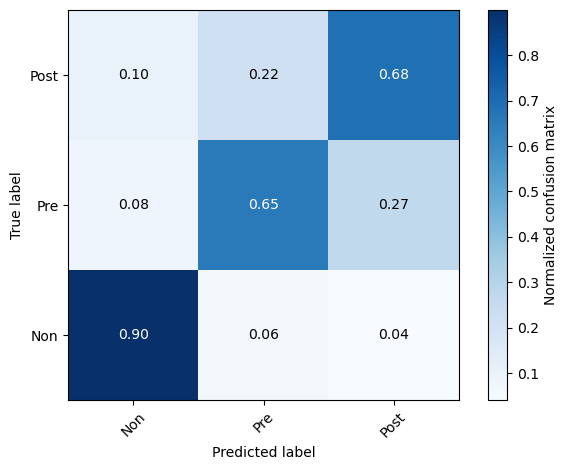

In [41]:
state_dict = torch.load("zoobot_nonbinary_best_model_bal_acc_3.pth", map_location=device)
swin_multi_bal_acc_model.load_state_dict(state_dict)

swin_multi_epoch_loss, swin_multi_epoch_acc, swin_multi_all_preds, swin_multi_all_labels, swin_multi_bal_acc = AF.nonbinary_multilabel_evaluate(swin_multi_bal_acc_model, swin_multi_test_loader,
                                                                                                                  criterion, device)
print(swin_multi_epoch_acc)
print(swin_multi_bal_acc)
af.plot_confusion_matrix(swin_multi_all_labels, swin_multi_all_preds, classes=['Non','Pre','Post'], normalize=True, title=None, cmap=plt.cm.Blues)

In [42]:
swin_multi_val_loss_model = timm.create_model('hf_hub:mwalmsley/zoobot-encoder-efficientnet_b0', pretrained=False, num_classes=3)

# Freeze all parameters first
for param in swin_multi_val_loss_model.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in swin_multi_val_loss_model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_multi_val_loss_model = swin_multi_val_loss_model.to(device)

0.8894024995719911
0.7337559873523646


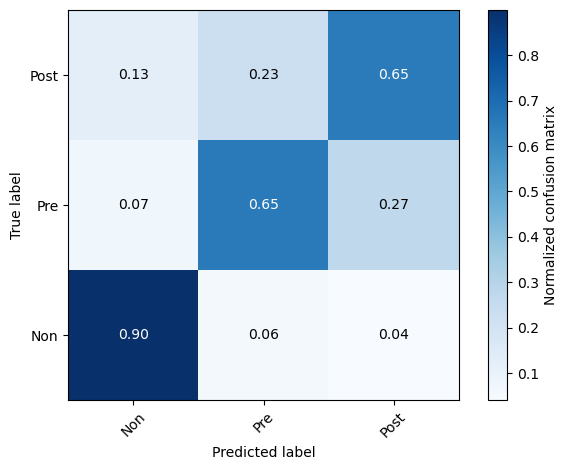

In [43]:
state_dict = torch.load("zoobot_nonbinary_best_model_val_loss_3.pth", map_location=device)
swin_multi_val_loss_model.load_state_dict(state_dict)

swin_multi_epoch_loss, swin_multi_epoch_acc, swin_multi_all_preds, swin_multi_all_labels, swin_multi_bal_acc = AF.nonbinary_multilabel_evaluate(swin_multi_val_loss_model, swin_multi_test_loader,
                                                                                                                  criterion, device)
print(swin_multi_epoch_acc)
print(swin_multi_bal_acc)
af.plot_confusion_matrix(swin_multi_all_labels, swin_multi_all_preds, classes=['Non','Pre','Post'], normalize=True, title=None, cmap=plt.cm.Blues)

zoobot requires many more epochs to reach a minimum loss and the minimum is approx. double, we assume this is because swin can capture global and is much better at then determining if there is multiple galaxies in the image which is the biggest indicator of non-merger or merger and swin gets this much quicker and more effectively

Our hypothesis is that global features are much more important for differentiating between non-mergers and mergers but local features may be more important for differentiating pre and post mergers.